In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_e_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 92)
(1755717, 3)
validation
(308504, 92)
(308504, 3)
test
(223783, 92)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 784643 (2.99 MB)


Trainable params: 784643 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 3:22 - loss: 1.3127 - STD: 0.2453 - MAE: 0.4244

  7/176 [>.............................] - ETA: 1s - loss: 1.1472 - STD: 0.1138 - MAE: 0.4355  

 13/176 [=>............................] - ETA: 1s - loss: 1.1182 - STD: 0.0979 - MAE: 0.4344

 20/176 [==>...........................] - ETA: 1s - loss: 1.1055 - STD: 0.0979 - MAE: 0.4329

 26/176 [===>..........................] - ETA: 1s - loss: 1.0988 - STD: 0.0863 - MAE: 0.4339

 32/176 [====>.........................] - ETA: 1s - loss: 1.0934 - STD: 0.0846 - MAE: 0.4336

 39/176 [=====>........................] - ETA: 1s - loss: 1.0879 - STD: 0.0850 - MAE: 0.4327

 45/176 [======>.......................] - ETA: 1s - loss: 1.0830 - STD: 0.0822 - MAE: 0.4322

 51/176 [=======>......................] - ETA: 1s - loss: 1.0755 - STD: 0.0831 - MAE: 0.4305

 57/176 [========>.....................] - ETA: 1s - loss: 1.0643 - STD: 0.0872 - MAE: 0.4270

 63/176 [=========>....................] - ETA: 0s - loss: 1.0504 - STD: 0.0954 - MAE: 0.4218

 70/176 [==========>...................] - ETA: 0s - loss: 1.0351 - STD: 0.1074 - MAE: 0.4148

 77/176 [============>.................] - ETA: 0s - loss: 1.0207 - STD: 0.1163 - MAE: 0.4090

 84/176 [=============>................] - ETA: 0s - loss: 1.0075 - STD: 0.1244 - MAE: 0.4038

 90/176 [==============>...............] - ETA: 0s - loss: 0.9970 - STD: 0.1311 - MAE: 0.3994

 96/176 [===============>..............] - ETA: 0s - loss: 0.9878 - STD: 0.1371 - MAE: 0.3955

103/176 [================>.............] - ETA: 0s - loss: 0.9777 - STD: 0.1434 - MAE: 0.3912

110/176 [=================>............] - ETA: 0s - loss: 0.9686 - STD: 0.1492 - MAE: 0.3874

117/176 [==================>...........] - ETA: 0s - loss: 0.9602 - STD: 0.1546 - MAE: 0.3838

119/176 [===================>..........] - ETA: 0s - loss: 0.9585 - STD: 0.1560 - MAE: 0.3828

125/176 [====================>.........] - ETA: 0s - loss: 0.9520 - STD: 0.1601 - MAE: 0.3801

132/176 [=====================>........] - ETA: 0s - loss: 0.9448 - STD: 0.1646 - MAE: 0.3770

138/176 [======================>.......] - ETA: 0s - loss: 0.9393 - STD: 0.1681 - MAE: 0.3747

145/176 [=======================>......] - ETA: 0s - loss: 0.9335 - STD: 0.1718 - MAE: 0.3721

152/176 [========================>.....] - ETA: 0s - loss: 0.9278 - STD: 0.1753 - MAE: 0.3697

158/176 [=========================>....] - ETA: 0s - loss: 0.9234 - STD: 0.1781 - MAE: 0.3678

165/176 [===========================>..] - ETA: 0s - loss: 0.9187 - STD: 0.1811 - MAE: 0.3658

172/176 [============================>.] - ETA: 0s - loss: 0.9143 - STD: 0.1838 - MAE: 0.3639

176/176 [==============================] - 4s 16ms/step - loss: 0.9119 - STD: 0.1853 - MAE: 0.3629 - val_loss: 0.8101 - val_STD: 0.2692 - val_MAE: 0.3070


Epoch 2/10000


  1/176 [..............................] - ETA: 4s - loss: 0.8151 - STD: 0.2532 - MAE: 0.3180

  7/176 [>.............................] - ETA: 1s - loss: 0.8067 - STD: 0.2511 - MAE: 0.3174

 14/176 [=>............................] - ETA: 1s - loss: 0.8029 - STD: 0.2525 - MAE: 0.3158

 21/176 [==>...........................] - ETA: 1s - loss: 0.8024 - STD: 0.2523 - MAE: 0.3158

 28/176 [===>..........................] - ETA: 1s - loss: 0.8012 - STD: 0.2530 - MAE: 0.3151

 35/176 [====>.........................] - ETA: 1s - loss: 0.7995 - STD: 0.2536 - MAE: 0.3145

 42/176 [======>.......................] - ETA: 1s - loss: 0.7978 - STD: 0.2541 - MAE: 0.3139

 48/176 [=======>......................] - ETA: 1s - loss: 0.7965 - STD: 0.2548 - MAE: 0.3132

 54/176 [========>.....................] - ETA: 1s - loss: 0.7954 - STD: 0.2553 - MAE: 0.3127

 61/176 [=========>....................] - ETA: 0s - loss: 0.7938 - STD: 0.2557 - MAE: 0.3122

 68/176 [==========>...................] - ETA: 0s - loss: 0.7925 - STD: 0.2563 - MAE: 0.3116

 75/176 [===========>..................] - ETA: 0s - loss: 0.7914 - STD: 0.2567 - MAE: 0.3112

 82/176 [============>.................] - ETA: 0s - loss: 0.7901 - STD: 0.2572 - MAE: 0.3106

 89/176 [==============>...............] - ETA: 0s - loss: 0.7890 - STD: 0.2577 - MAE: 0.3102

 96/176 [===============>..............] - ETA: 0s - loss: 0.7877 - STD: 0.2582 - MAE: 0.3097

103/176 [================>.............] - ETA: 0s - loss: 0.7865 - STD: 0.2588 - MAE: 0.3092

110/176 [=================>............] - ETA: 0s - loss: 0.7853 - STD: 0.2594 - MAE: 0.3086

116/176 [==================>...........] - ETA: 0s - loss: 0.7846 - STD: 0.2596 - MAE: 0.3083

123/176 [===================>..........] - ETA: 0s - loss: 0.7834 - STD: 0.2601 - MAE: 0.3079

130/176 [=====================>........] - ETA: 0s - loss: 0.7821 - STD: 0.2606 - MAE: 0.3074

137/176 [======================>.......] - ETA: 0s - loss: 0.7811 - STD: 0.2610 - MAE: 0.3070

143/176 [=======================>......] - ETA: 0s - loss: 0.7802 - STD: 0.2613 - MAE: 0.3066

149/176 [========================>.....] - ETA: 0s - loss: 0.7795 - STD: 0.2616 - MAE: 0.3064

155/176 [=========================>....] - ETA: 0s - loss: 0.7788 - STD: 0.2620 - MAE: 0.3060

162/176 [==========================>...] - ETA: 0s - loss: 0.7779 - STD: 0.2624 - MAE: 0.3057

169/176 [===========================>..] - ETA: 0s - loss: 0.7770 - STD: 0.2627 - MAE: 0.3054

176/176 [==============================] - ETA: 0s - loss: 0.7761 - STD: 0.2630 - MAE: 0.3050

176/176 [==============================] - 2s 9ms/step - loss: 0.7761 - STD: 0.2630 - MAE: 0.3050 - val_loss: 0.7554 - val_STD: 0.2837 - val_MAE: 0.2886


Epoch 3/10000


  1/176 [..............................] - ETA: 4s - loss: 0.7546 - STD: 0.2699 - MAE: 0.2976

  8/176 [>.............................] - ETA: 1s - loss: 0.7510 - STD: 0.2733 - MAE: 0.2950

 15/176 [=>............................] - ETA: 1s - loss: 0.7516 - STD: 0.2726 - MAE: 0.2956

 22/176 [==>...........................] - ETA: 1s - loss: 0.7516 - STD: 0.2721 - MAE: 0.2959

 29/176 [===>..........................] - ETA: 1s - loss: 0.7513 - STD: 0.2726 - MAE: 0.2957

 36/176 [=====>........................] - ETA: 1s - loss: 0.7505 - STD: 0.2726 - MAE: 0.2955

 43/176 [======>.......................] - ETA: 1s - loss: 0.7501 - STD: 0.2727 - MAE: 0.2954

 50/176 [=======>......................] - ETA: 1s - loss: 0.7491 - STD: 0.2731 - MAE: 0.2950

 57/176 [========>.....................] - ETA: 0s - loss: 0.7490 - STD: 0.2733 - MAE: 0.2949

 64/176 [=========>....................] - ETA: 0s - loss: 0.7487 - STD: 0.2734 - MAE: 0.2947

 71/176 [===========>..................] - ETA: 0s - loss: 0.7476 - STD: 0.2735 - MAE: 0.2945

 78/176 [============>.................] - ETA: 0s - loss: 0.7470 - STD: 0.2737 - MAE: 0.2943

 85/176 [=============>................] - ETA: 0s - loss: 0.7460 - STD: 0.2742 - MAE: 0.2938

 92/176 [==============>...............] - ETA: 0s - loss: 0.7451 - STD: 0.2744 - MAE: 0.2935

 99/176 [===============>..............] - ETA: 0s - loss: 0.7445 - STD: 0.2746 - MAE: 0.2933

106/176 [=================>............] - ETA: 0s - loss: 0.7444 - STD: 0.2749 - MAE: 0.2931

113/176 [==================>...........] - ETA: 0s - loss: 0.7447 - STD: 0.2751 - MAE: 0.2930

119/176 [===================>..........] - ETA: 0s - loss: 0.7445 - STD: 0.2753 - MAE: 0.2929

125/176 [====================>.........] - ETA: 0s - loss: 0.7443 - STD: 0.2753 - MAE: 0.2929

132/176 [=====================>........] - ETA: 0s - loss: 0.7438 - STD: 0.2753 - MAE: 0.2928

139/176 [======================>.......] - ETA: 0s - loss: 0.7431 - STD: 0.2755 - MAE: 0.2925

146/176 [=======================>......] - ETA: 0s - loss: 0.7427 - STD: 0.2756 - MAE: 0.2924

153/176 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2758 - MAE: 0.2921

160/176 [==========================>...] - ETA: 0s - loss: 0.7415 - STD: 0.2760 - MAE: 0.2920

167/176 [===========================>..] - ETA: 0s - loss: 0.7408 - STD: 0.2762 - MAE: 0.2917

174/176 [============================>.] - ETA: 0s - loss: 0.7405 - STD: 0.2763 - MAE: 0.2916

176/176 [==============================] - 2s 9ms/step - loss: 0.7403 - STD: 0.2764 - MAE: 0.2915 - val_loss: 0.7245 - val_STD: 0.2908 - val_MAE: 0.2789


Epoch 4/10000


  1/176 [..............................] - ETA: 4s - loss: 0.7398 - STD: 0.2770 - MAE: 0.2912

  8/176 [>.............................] - ETA: 1s - loss: 0.7315 - STD: 0.2792 - MAE: 0.2886

 15/176 [=>............................] - ETA: 1s - loss: 0.7277 - STD: 0.2811 - MAE: 0.2866

 22/176 [==>...........................] - ETA: 1s - loss: 0.7266 - STD: 0.2803 - MAE: 0.2869

 29/176 [===>..........................] - ETA: 1s - loss: 0.7257 - STD: 0.2811 - MAE: 0.2862

 36/176 [=====>........................] - ETA: 1s - loss: 0.7248 - STD: 0.2810 - MAE: 0.2861

 43/176 [======>.......................] - ETA: 1s - loss: 0.7241 - STD: 0.2816 - MAE: 0.2856

 50/176 [=======>......................] - ETA: 1s - loss: 0.7242 - STD: 0.2818 - MAE: 0.2855

 57/176 [========>.....................] - ETA: 0s - loss: 0.7242 - STD: 0.2816 - MAE: 0.2856

 64/176 [=========>....................] - ETA: 0s - loss: 0.7240 - STD: 0.2817 - MAE: 0.2855

 70/176 [==========>...................] - ETA: 0s - loss: 0.7244 - STD: 0.2817 - MAE: 0.2856

 77/176 [============>.................] - ETA: 0s - loss: 0.7243 - STD: 0.2817 - MAE: 0.2856

 84/176 [=============>................] - ETA: 0s - loss: 0.7244 - STD: 0.2817 - MAE: 0.2856

 90/176 [==============>...............] - ETA: 0s - loss: 0.7241 - STD: 0.2818 - MAE: 0.2855

 96/176 [===============>..............] - ETA: 0s - loss: 0.7237 - STD: 0.2818 - MAE: 0.2854

103/176 [================>.............] - ETA: 0s - loss: 0.7232 - STD: 0.2821 - MAE: 0.2851

110/176 [=================>............] - ETA: 0s - loss: 0.7230 - STD: 0.2822 - MAE: 0.2850

117/176 [==================>...........] - ETA: 0s - loss: 0.7227 - STD: 0.2822 - MAE: 0.2850

123/176 [===================>..........] - ETA: 0s - loss: 0.7228 - STD: 0.2824 - MAE: 0.2849

129/176 [====================>.........] - ETA: 0s - loss: 0.7228 - STD: 0.2823 - MAE: 0.2849

136/176 [======================>.......] - ETA: 0s - loss: 0.7228 - STD: 0.2823 - MAE: 0.2849

142/176 [=======================>......] - ETA: 0s - loss: 0.7227 - STD: 0.2824 - MAE: 0.2849

149/176 [========================>.....] - ETA: 0s - loss: 0.7226 - STD: 0.2825 - MAE: 0.2848

156/176 [=========================>....] - ETA: 0s - loss: 0.7227 - STD: 0.2826 - MAE: 0.2847

163/176 [==========================>...] - ETA: 0s - loss: 0.7227 - STD: 0.2826 - MAE: 0.2847

170/176 [===========================>..] - ETA: 0s - loss: 0.7225 - STD: 0.2827 - MAE: 0.2847

176/176 [==============================] - 2s 9ms/step - loss: 0.7225 - STD: 0.2827 - MAE: 0.2846 - val_loss: 0.7186 - val_STD: 0.3041 - val_MAE: 0.2707


Epoch 5/10000


  1/176 [..............................] - ETA: 3s - loss: 0.7055 - STD: 0.2904 - MAE: 0.2769

  7/176 [>.............................] - ETA: 1s - loss: 0.7137 - STD: 0.2852 - MAE: 0.2815

 14/176 [=>............................] - ETA: 1s - loss: 0.7137 - STD: 0.2858 - MAE: 0.2812

 21/176 [==>...........................] - ETA: 1s - loss: 0.7156 - STD: 0.2859 - MAE: 0.2815

 28/176 [===>..........................] - ETA: 1s - loss: 0.7161 - STD: 0.2852 - MAE: 0.2820

 35/176 [====>.........................] - ETA: 1s - loss: 0.7155 - STD: 0.2851 - MAE: 0.2819

 42/176 [======>.......................] - ETA: 1s - loss: 0.7155 - STD: 0.2851 - MAE: 0.2819

 49/176 [=======>......................] - ETA: 1s - loss: 0.7147 - STD: 0.2853 - MAE: 0.2816

 56/176 [========>.....................] - ETA: 0s - loss: 0.7148 - STD: 0.2853 - MAE: 0.2816

 63/176 [=========>....................] - ETA: 0s - loss: 0.7145 - STD: 0.2854 - MAE: 0.2816

 69/176 [==========>...................] - ETA: 0s - loss: 0.7144 - STD: 0.2855 - MAE: 0.2814

 76/176 [===========>..................] - ETA: 0s - loss: 0.7143 - STD: 0.2855 - MAE: 0.2814

 83/176 [=============>................] - ETA: 0s - loss: 0.7141 - STD: 0.2855 - MAE: 0.2814

 89/176 [==============>...............] - ETA: 0s - loss: 0.7144 - STD: 0.2855 - MAE: 0.2814

 96/176 [===============>..............] - ETA: 0s - loss: 0.7145 - STD: 0.2857 - MAE: 0.2814

103/176 [================>.............] - ETA: 0s - loss: 0.7146 - STD: 0.2858 - MAE: 0.2813

110/176 [=================>............] - ETA: 0s - loss: 0.7142 - STD: 0.2857 - MAE: 0.2813

117/176 [==================>...........] - ETA: 0s - loss: 0.7139 - STD: 0.2857 - MAE: 0.2812

124/176 [====================>.........] - ETA: 0s - loss: 0.7136 - STD: 0.2859 - MAE: 0.2810

130/176 [=====================>........] - ETA: 0s - loss: 0.7133 - STD: 0.2859 - MAE: 0.2810

137/176 [======================>.......] - ETA: 0s - loss: 0.7130 - STD: 0.2861 - MAE: 0.2809

144/176 [=======================>......] - ETA: 0s - loss: 0.7128 - STD: 0.2861 - MAE: 0.2808

151/176 [========================>.....] - ETA: 0s - loss: 0.7127 - STD: 0.2862 - MAE: 0.2807

158/176 [=========================>....] - ETA: 0s - loss: 0.7128 - STD: 0.2862 - MAE: 0.2808

165/176 [===========================>..] - ETA: 0s - loss: 0.7126 - STD: 0.2862 - MAE: 0.2807

172/176 [============================>.] - ETA: 0s - loss: 0.7123 - STD: 0.2863 - MAE: 0.2806

176/176 [==============================] - 2s 9ms/step - loss: 0.7122 - STD: 0.2863 - MAE: 0.2806 - val_loss: 0.7071 - val_STD: 0.2993 - val_MAE: 0.2710


Epoch 6/10000


  1/176 [..............................] - ETA: 4s - loss: 0.7001 - STD: 0.2865 - MAE: 0.2783

  8/176 [>.............................] - ETA: 1s - loss: 0.7029 - STD: 0.2877 - MAE: 0.2780

 15/176 [=>............................] - ETA: 1s - loss: 0.7059 - STD: 0.2878 - MAE: 0.2786

 21/176 [==>...........................] - ETA: 1s - loss: 0.7076 - STD: 0.2882 - MAE: 0.2787

 28/176 [===>..........................] - ETA: 1s - loss: 0.7072 - STD: 0.2882 - MAE: 0.2786

 35/176 [====>.........................] - ETA: 1s - loss: 0.7080 - STD: 0.2879 - MAE: 0.2789

 41/176 [=====>........................] - ETA: 1s - loss: 0.7070 - STD: 0.2881 - MAE: 0.2786

 47/176 [=======>......................] - ETA: 1s - loss: 0.7070 - STD: 0.2883 - MAE: 0.2785

 54/176 [========>.....................] - ETA: 1s - loss: 0.7070 - STD: 0.2883 - MAE: 0.2784

 61/176 [=========>....................] - ETA: 0s - loss: 0.7069 - STD: 0.2884 - MAE: 0.2784

 68/176 [==========>...................] - ETA: 0s - loss: 0.7072 - STD: 0.2882 - MAE: 0.2785

 75/176 [===========>..................] - ETA: 0s - loss: 0.7072 - STD: 0.2882 - MAE: 0.2785

 81/176 [============>.................] - ETA: 0s - loss: 0.7073 - STD: 0.2882 - MAE: 0.2785

 88/176 [==============>...............] - ETA: 0s - loss: 0.7072 - STD: 0.2882 - MAE: 0.2785

 95/176 [===============>..............] - ETA: 0s - loss: 0.7072 - STD: 0.2882 - MAE: 0.2785

102/176 [================>.............] - ETA: 0s - loss: 0.7072 - STD: 0.2881 - MAE: 0.2786

109/176 [=================>............] - ETA: 0s - loss: 0.7072 - STD: 0.2881 - MAE: 0.2785

116/176 [==================>...........] - ETA: 0s - loss: 0.7071 - STD: 0.2883 - MAE: 0.2785

123/176 [===================>..........] - ETA: 0s - loss: 0.7070 - STD: 0.2882 - MAE: 0.2784

130/176 [=====================>........] - ETA: 0s - loss: 0.7068 - STD: 0.2883 - MAE: 0.2784

137/176 [======================>.......] - ETA: 0s - loss: 0.7070 - STD: 0.2883 - MAE: 0.2784

144/176 [=======================>......] - ETA: 0s - loss: 0.7071 - STD: 0.2884 - MAE: 0.2784

151/176 [========================>.....] - ETA: 0s - loss: 0.7073 - STD: 0.2883 - MAE: 0.2784

158/176 [=========================>....] - ETA: 0s - loss: 0.7073 - STD: 0.2882 - MAE: 0.2785

165/176 [===========================>..] - ETA: 0s - loss: 0.7072 - STD: 0.2883 - MAE: 0.2784

172/176 [============================>.] - ETA: 0s - loss: 0.7071 - STD: 0.2883 - MAE: 0.2784

176/176 [==============================] - 2s 9ms/step - loss: 0.7071 - STD: 0.2884 - MAE: 0.2784 - val_loss: 0.7027 - val_STD: 0.2994 - val_MAE: 0.2704


Epoch 7/10000


  1/176 [..............................] - ETA: 4s - loss: 0.7035 - STD: 0.2875 - MAE: 0.2780

  8/176 [>.............................] - ETA: 1s - loss: 0.7029 - STD: 0.2890 - MAE: 0.2773

 15/176 [=>............................] - ETA: 1s - loss: 0.7035 - STD: 0.2891 - MAE: 0.2772

 22/176 [==>...........................] - ETA: 1s - loss: 0.7035 - STD: 0.2897 - MAE: 0.2769

 29/176 [===>..........................] - ETA: 1s - loss: 0.7033 - STD: 0.2893 - MAE: 0.2771

 36/176 [=====>........................] - ETA: 1s - loss: 0.7037 - STD: 0.2894 - MAE: 0.2771

 43/176 [======>.......................] - ETA: 1s - loss: 0.7033 - STD: 0.2897 - MAE: 0.2768

 50/176 [=======>......................] - ETA: 1s - loss: 0.7033 - STD: 0.2898 - MAE: 0.2768

 57/176 [========>.....................] - ETA: 0s - loss: 0.7029 - STD: 0.2899 - MAE: 0.2766

 64/176 [=========>....................] - ETA: 0s - loss: 0.7031 - STD: 0.2895 - MAE: 0.2769

 71/176 [===========>..................] - ETA: 0s - loss: 0.7033 - STD: 0.2895 - MAE: 0.2770

 78/176 [============>.................] - ETA: 0s - loss: 0.7029 - STD: 0.2896 - MAE: 0.2768

 85/176 [=============>................] - ETA: 0s - loss: 0.7029 - STD: 0.2898 - MAE: 0.2767

 92/176 [==============>...............] - ETA: 0s - loss: 0.7030 - STD: 0.2897 - MAE: 0.2768

 99/176 [===============>..............] - ETA: 0s - loss: 0.7030 - STD: 0.2897 - MAE: 0.2768

106/176 [=================>............] - ETA: 0s - loss: 0.7028 - STD: 0.2898 - MAE: 0.2767

113/176 [==================>...........] - ETA: 0s - loss: 0.7024 - STD: 0.2898 - MAE: 0.2766

120/176 [===================>..........] - ETA: 0s - loss: 0.7025 - STD: 0.2898 - MAE: 0.2766

127/176 [====================>.........] - ETA: 0s - loss: 0.7023 - STD: 0.2898 - MAE: 0.2766

134/176 [=====================>........] - ETA: 0s - loss: 0.7020 - STD: 0.2898 - MAE: 0.2765

140/176 [======================>.......] - ETA: 0s - loss: 0.7020 - STD: 0.2899 - MAE: 0.2765

147/176 [========================>.....] - ETA: 0s - loss: 0.7026 - STD: 0.2899 - MAE: 0.2766

154/176 [=========================>....] - ETA: 0s - loss: 0.7028 - STD: 0.2897 - MAE: 0.2767

161/176 [==========================>...] - ETA: 0s - loss: 0.7027 - STD: 0.2897 - MAE: 0.2767

167/176 [===========================>..] - ETA: 0s - loss: 0.7028 - STD: 0.2898 - MAE: 0.2767

174/176 [============================>.] - ETA: 0s - loss: 0.7027 - STD: 0.2898 - MAE: 0.2767

176/176 [==============================] - 2s 9ms/step - loss: 0.7027 - STD: 0.2897 - MAE: 0.2767 - val_loss: 0.7007 - val_STD: 0.3020 - val_MAE: 0.2687


Epoch 8/10000


  1/176 [..............................] - ETA: 3s - loss: 0.6979 - STD: 0.2902 - MAE: 0.2752

  8/176 [>.............................] - ETA: 1s - loss: 0.7011 - STD: 0.2912 - MAE: 0.2755

 15/176 [=>............................] - ETA: 1s - loss: 0.7030 - STD: 0.2906 - MAE: 0.2763

 22/176 [==>...........................] - ETA: 1s - loss: 0.7027 - STD: 0.2898 - MAE: 0.2767

 29/176 [===>..........................] - ETA: 1s - loss: 0.7031 - STD: 0.2901 - MAE: 0.2766

 36/176 [=====>........................] - ETA: 1s - loss: 0.7023 - STD: 0.2901 - MAE: 0.2764

 42/176 [======>.......................] - ETA: 1s - loss: 0.7012 - STD: 0.2903 - MAE: 0.2760

 49/176 [=======>......................] - ETA: 1s - loss: 0.6999 - STD: 0.2906 - MAE: 0.2756

 55/176 [========>.....................] - ETA: 0s - loss: 0.6992 - STD: 0.2907 - MAE: 0.2754

 62/176 [=========>....................] - ETA: 0s - loss: 0.6991 - STD: 0.2909 - MAE: 0.2752

 69/176 [==========>...................] - ETA: 0s - loss: 0.6988 - STD: 0.2910 - MAE: 0.2751

 76/176 [===========>..................] - ETA: 0s - loss: 0.6991 - STD: 0.2911 - MAE: 0.2751

 83/176 [=============>................] - ETA: 0s - loss: 0.6994 - STD: 0.2910 - MAE: 0.2753

 90/176 [==============>...............] - ETA: 0s - loss: 0.6991 - STD: 0.2909 - MAE: 0.2753

 97/176 [===============>..............] - ETA: 0s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2752

104/176 [================>.............] - ETA: 0s - loss: 0.6995 - STD: 0.2909 - MAE: 0.2753

111/176 [=================>............] - ETA: 0s - loss: 0.6995 - STD: 0.2908 - MAE: 0.2754

118/176 [===================>..........] - ETA: 0s - loss: 0.6992 - STD: 0.2908 - MAE: 0.2754

124/176 [====================>.........] - ETA: 0s - loss: 0.6993 - STD: 0.2908 - MAE: 0.2754

131/176 [=====================>........] - ETA: 0s - loss: 0.6993 - STD: 0.2908 - MAE: 0.2754

138/176 [======================>.......] - ETA: 0s - loss: 0.6991 - STD: 0.2908 - MAE: 0.2754

145/176 [=======================>......] - ETA: 0s - loss: 0.6989 - STD: 0.2909 - MAE: 0.2753

152/176 [========================>.....] - ETA: 0s - loss: 0.6990 - STD: 0.2910 - MAE: 0.2752

158/176 [=========================>....] - ETA: 0s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2753

165/176 [===========================>..] - ETA: 0s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2753

172/176 [============================>.] - ETA: 0s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2753

176/176 [==============================] - 2s 9ms/step - loss: 0.6990 - STD: 0.2909 - MAE: 0.2753 - val_loss: 0.7042 - val_STD: 0.3016 - val_MAE: 0.2688


Epoch 9/10000


  1/176 [..............................] - ETA: 4s - loss: 0.7055 - STD: 0.2908 - MAE: 0.2770

  8/176 [>.............................] - ETA: 1s - loss: 0.6992 - STD: 0.2897 - MAE: 0.2760

 15/176 [=>............................] - ETA: 1s - loss: 0.7003 - STD: 0.2899 - MAE: 0.2762

 22/176 [==>...........................] - ETA: 1s - loss: 0.7001 - STD: 0.2905 - MAE: 0.2758

 29/176 [===>..........................] - ETA: 1s - loss: 0.6990 - STD: 0.2908 - MAE: 0.2753

 36/176 [=====>........................] - ETA: 1s - loss: 0.6984 - STD: 0.2907 - MAE: 0.2752

 43/176 [======>.......................] - ETA: 1s - loss: 0.6982 - STD: 0.2911 - MAE: 0.2750

 50/176 [=======>......................] - ETA: 1s - loss: 0.6986 - STD: 0.2911 - MAE: 0.2751

 57/176 [========>.....................] - ETA: 0s - loss: 0.6983 - STD: 0.2913 - MAE: 0.2749

 64/176 [=========>....................] - ETA: 0s - loss: 0.6984 - STD: 0.2912 - MAE: 0.2750

 71/176 [===========>..................] - ETA: 0s - loss: 0.6980 - STD: 0.2914 - MAE: 0.2748

 78/176 [============>.................] - ETA: 0s - loss: 0.6979 - STD: 0.2914 - MAE: 0.2748

 85/176 [=============>................] - ETA: 0s - loss: 0.6978 - STD: 0.2914 - MAE: 0.2747

 92/176 [==============>...............] - ETA: 0s - loss: 0.6974 - STD: 0.2914 - MAE: 0.2746

 99/176 [===============>..............] - ETA: 0s - loss: 0.6971 - STD: 0.2914 - MAE: 0.2746

106/176 [=================>............] - ETA: 0s - loss: 0.6973 - STD: 0.2915 - MAE: 0.2746

112/176 [==================>...........] - ETA: 0s - loss: 0.6971 - STD: 0.2915 - MAE: 0.2745

119/176 [===================>..........] - ETA: 0s - loss: 0.6968 - STD: 0.2916 - MAE: 0.2744

126/176 [====================>.........] - ETA: 0s - loss: 0.6967 - STD: 0.2916 - MAE: 0.2744

133/176 [=====================>........] - ETA: 0s - loss: 0.6967 - STD: 0.2916 - MAE: 0.2744

140/176 [======================>.......] - ETA: 0s - loss: 0.6968 - STD: 0.2917 - MAE: 0.2743

147/176 [========================>.....] - ETA: 0s - loss: 0.6966 - STD: 0.2918 - MAE: 0.2743

154/176 [=========================>....] - ETA: 0s - loss: 0.6968 - STD: 0.2917 - MAE: 0.2744

161/176 [==========================>...] - ETA: 0s - loss: 0.6967 - STD: 0.2917 - MAE: 0.2744

168/176 [===========================>..] - ETA: 0s - loss: 0.6969 - STD: 0.2917 - MAE: 0.2744

175/176 [============================>.] - ETA: 0s - loss: 0.6967 - STD: 0.2917 - MAE: 0.2743

176/176 [==============================] - 2s 9ms/step - loss: 0.6967 - STD: 0.2917 - MAE: 0.2743 - val_loss: 0.6953 - val_STD: 0.2961 - val_MAE: 0.2709


Epoch 10/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6999 - STD: 0.2840 - MAE: 0.2795

  8/176 [>.............................] - ETA: 1s - loss: 0.6948 - STD: 0.2910 - MAE: 0.2743

 15/176 [=>............................] - ETA: 1s - loss: 0.6926 - STD: 0.2917 - MAE: 0.2734

 22/176 [==>...........................] - ETA: 1s - loss: 0.6919 - STD: 0.2925 - MAE: 0.2728

 29/176 [===>..........................] - ETA: 1s - loss: 0.6927 - STD: 0.2924 - MAE: 0.2731

 36/176 [=====>........................] - ETA: 1s - loss: 0.6938 - STD: 0.2924 - MAE: 0.2733

 43/176 [======>.......................] - ETA: 1s - loss: 0.6938 - STD: 0.2925 - MAE: 0.2733

 49/176 [=======>......................] - ETA: 1s - loss: 0.6947 - STD: 0.2925 - MAE: 0.2735

 55/176 [========>.....................] - ETA: 0s - loss: 0.6942 - STD: 0.2926 - MAE: 0.2733

 62/176 [=========>....................] - ETA: 0s - loss: 0.6948 - STD: 0.2923 - MAE: 0.2736

 69/176 [==========>...................] - ETA: 0s - loss: 0.6945 - STD: 0.2922 - MAE: 0.2736

 76/176 [===========>..................] - ETA: 0s - loss: 0.6942 - STD: 0.2922 - MAE: 0.2735

 83/176 [=============>................] - ETA: 0s - loss: 0.6942 - STD: 0.2922 - MAE: 0.2736

 90/176 [==============>...............] - ETA: 0s - loss: 0.6939 - STD: 0.2924 - MAE: 0.2734

 97/176 [===============>..............] - ETA: 0s - loss: 0.6938 - STD: 0.2923 - MAE: 0.2734

104/176 [================>.............] - ETA: 0s - loss: 0.6938 - STD: 0.2924 - MAE: 0.2733

111/176 [=================>............] - ETA: 0s - loss: 0.6935 - STD: 0.2924 - MAE: 0.2733

118/176 [===================>..........] - ETA: 0s - loss: 0.6937 - STD: 0.2924 - MAE: 0.2733

125/176 [====================>.........] - ETA: 0s - loss: 0.6939 - STD: 0.2924 - MAE: 0.2734

132/176 [=====================>........] - ETA: 0s - loss: 0.6938 - STD: 0.2924 - MAE: 0.2733

139/176 [======================>.......] - ETA: 0s - loss: 0.6934 - STD: 0.2925 - MAE: 0.2732

146/176 [=======================>......] - ETA: 0s - loss: 0.6930 - STD: 0.2926 - MAE: 0.2731

153/176 [=========================>....] - ETA: 0s - loss: 0.6930 - STD: 0.2926 - MAE: 0.2731

160/176 [==========================>...] - ETA: 0s - loss: 0.6929 - STD: 0.2926 - MAE: 0.2731

167/176 [===========================>..] - ETA: 0s - loss: 0.6930 - STD: 0.2926 - MAE: 0.2731

174/176 [============================>.] - ETA: 0s - loss: 0.6932 - STD: 0.2926 - MAE: 0.2731

176/176 [==============================] - 2s 9ms/step - loss: 0.6932 - STD: 0.2926 - MAE: 0.2731 - val_loss: 0.6930 - val_STD: 0.3053 - val_MAE: 0.2652


Epoch 11/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6981 - STD: 0.2942 - MAE: 0.2728

  8/176 [>.............................] - ETA: 1s - loss: 0.6939 - STD: 0.2917 - MAE: 0.2736

 15/176 [=>............................] - ETA: 1s - loss: 0.6925 - STD: 0.2927 - MAE: 0.2729

 22/176 [==>...........................] - ETA: 1s - loss: 0.6932 - STD: 0.2927 - MAE: 0.2731

 29/176 [===>..........................] - ETA: 1s - loss: 0.6930 - STD: 0.2923 - MAE: 0.2732

 35/176 [====>.........................] - ETA: 1s - loss: 0.6929 - STD: 0.2926 - MAE: 0.2730

 41/176 [=====>........................] - ETA: 1s - loss: 0.6927 - STD: 0.2929 - MAE: 0.2728

 47/176 [=======>......................] - ETA: 1s - loss: 0.6915 - STD: 0.2931 - MAE: 0.2724

 53/176 [========>.....................] - ETA: 0s - loss: 0.6913 - STD: 0.2930 - MAE: 0.2725

 60/176 [=========>....................] - ETA: 0s - loss: 0.6907 - STD: 0.2932 - MAE: 0.2723

 67/176 [==========>...................] - ETA: 0s - loss: 0.6905 - STD: 0.2931 - MAE: 0.2722

 73/176 [===========>..................] - ETA: 0s - loss: 0.6908 - STD: 0.2931 - MAE: 0.2723

 80/176 [============>.................] - ETA: 0s - loss: 0.6913 - STD: 0.2933 - MAE: 0.2723

 87/176 [=============>................] - ETA: 0s - loss: 0.6920 - STD: 0.2932 - MAE: 0.2725

 93/176 [==============>...............] - ETA: 0s - loss: 0.6922 - STD: 0.2931 - MAE: 0.2726

100/176 [================>.............] - ETA: 0s - loss: 0.6920 - STD: 0.2928 - MAE: 0.2727

107/176 [=================>............] - ETA: 0s - loss: 0.6919 - STD: 0.2930 - MAE: 0.2726

114/176 [==================>...........] - ETA: 0s - loss: 0.6918 - STD: 0.2930 - MAE: 0.2726

121/176 [===================>..........] - ETA: 0s - loss: 0.6913 - STD: 0.2930 - MAE: 0.2724

128/176 [====================>.........] - ETA: 0s - loss: 0.6913 - STD: 0.2932 - MAE: 0.2723

135/176 [======================>.......] - ETA: 0s - loss: 0.6914 - STD: 0.2932 - MAE: 0.2723

142/176 [=======================>......] - ETA: 0s - loss: 0.6913 - STD: 0.2932 - MAE: 0.2723

149/176 [========================>.....] - ETA: 0s - loss: 0.6913 - STD: 0.2932 - MAE: 0.2723

156/176 [=========================>....] - ETA: 0s - loss: 0.6911 - STD: 0.2933 - MAE: 0.2722

163/176 [==========================>...] - ETA: 0s - loss: 0.6910 - STD: 0.2933 - MAE: 0.2722

169/176 [===========================>..] - ETA: 0s - loss: 0.6911 - STD: 0.2933 - MAE: 0.2722

176/176 [==============================] - ETA: 0s - loss: 0.6909 - STD: 0.2933 - MAE: 0.2722

176/176 [==============================] - 2s 9ms/step - loss: 0.6909 - STD: 0.2933 - MAE: 0.2722 - val_loss: 0.7003 - val_STD: 0.3008 - val_MAE: 0.2683


Epoch 12/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6919 - STD: 0.2929 - MAE: 0.2731

  7/176 [>.............................] - ETA: 1s - loss: 0.6890 - STD: 0.2923 - MAE: 0.2726

 13/176 [=>............................] - ETA: 1s - loss: 0.6883 - STD: 0.2943 - MAE: 0.2712

 19/176 [==>...........................] - ETA: 1s - loss: 0.6888 - STD: 0.2942 - MAE: 0.2713

 26/176 [===>..........................] - ETA: 1s - loss: 0.6886 - STD: 0.2941 - MAE: 0.2713

 33/176 [====>.........................] - ETA: 1s - loss: 0.6887 - STD: 0.2936 - MAE: 0.2716

 40/176 [=====>........................] - ETA: 1s - loss: 0.6887 - STD: 0.2938 - MAE: 0.2715

 47/176 [=======>......................] - ETA: 1s - loss: 0.6892 - STD: 0.2937 - MAE: 0.2716

 54/176 [========>.....................] - ETA: 1s - loss: 0.6896 - STD: 0.2937 - MAE: 0.2717

 61/176 [=========>....................] - ETA: 0s - loss: 0.6899 - STD: 0.2937 - MAE: 0.2717

 68/176 [==========>...................] - ETA: 0s - loss: 0.6897 - STD: 0.2937 - MAE: 0.2717

 75/176 [===========>..................] - ETA: 0s - loss: 0.6895 - STD: 0.2936 - MAE: 0.2717

 82/176 [============>.................] - ETA: 0s - loss: 0.6892 - STD: 0.2935 - MAE: 0.2717

 88/176 [==============>...............] - ETA: 0s - loss: 0.6889 - STD: 0.2936 - MAE: 0.2716

 95/176 [===============>..............] - ETA: 0s - loss: 0.6891 - STD: 0.2937 - MAE: 0.2716

101/176 [================>.............] - ETA: 0s - loss: 0.6890 - STD: 0.2936 - MAE: 0.2716

108/176 [=================>............] - ETA: 0s - loss: 0.6890 - STD: 0.2937 - MAE: 0.2715

115/176 [==================>...........] - ETA: 0s - loss: 0.6886 - STD: 0.2939 - MAE: 0.2714

122/176 [===================>..........] - ETA: 0s - loss: 0.6884 - STD: 0.2939 - MAE: 0.2713

129/176 [====================>.........] - ETA: 0s - loss: 0.6883 - STD: 0.2939 - MAE: 0.2713

136/176 [======================>.......] - ETA: 0s - loss: 0.6881 - STD: 0.2939 - MAE: 0.2712

142/176 [=======================>......] - ETA: 0s - loss: 0.6880 - STD: 0.2940 - MAE: 0.2711

149/176 [========================>.....] - ETA: 0s - loss: 0.6877 - STD: 0.2941 - MAE: 0.2710

156/176 [=========================>....] - ETA: 0s - loss: 0.6874 - STD: 0.2941 - MAE: 0.2709

163/176 [==========================>...] - ETA: 0s - loss: 0.6872 - STD: 0.2943 - MAE: 0.2708

170/176 [===========================>..] - ETA: 0s - loss: 0.6869 - STD: 0.2943 - MAE: 0.2707

176/176 [==============================] - 2s 9ms/step - loss: 0.6869 - STD: 0.2944 - MAE: 0.2706 - val_loss: 0.6874 - val_STD: 0.3033 - val_MAE: 0.2652


Epoch 13/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6816 - STD: 0.2929 - MAE: 0.2706

  7/176 [>.............................] - ETA: 1s - loss: 0.6821 - STD: 0.2955 - MAE: 0.2691

 14/176 [=>............................] - ETA: 1s - loss: 0.6825 - STD: 0.2947 - MAE: 0.2695

 21/176 [==>...........................] - ETA: 1s - loss: 0.6822 - STD: 0.2955 - MAE: 0.2690

 27/176 [===>..........................] - ETA: 1s - loss: 0.6827 - STD: 0.2957 - MAE: 0.2689

 34/176 [====>.........................] - ETA: 1s - loss: 0.6841 - STD: 0.2961 - MAE: 0.2690

 41/176 [=====>........................] - ETA: 1s - loss: 0.6847 - STD: 0.2953 - MAE: 0.2696

 47/176 [=======>......................] - ETA: 1s - loss: 0.6850 - STD: 0.2955 - MAE: 0.2696

 54/176 [========>.....................] - ETA: 1s - loss: 0.6858 - STD: 0.2952 - MAE: 0.2699

 61/176 [=========>....................] - ETA: 0s - loss: 0.6850 - STD: 0.2956 - MAE: 0.2695

 68/176 [==========>...................] - ETA: 0s - loss: 0.6849 - STD: 0.2954 - MAE: 0.2696

 75/176 [===========>..................] - ETA: 0s - loss: 0.6842 - STD: 0.2955 - MAE: 0.2694

 82/176 [============>.................] - ETA: 0s - loss: 0.6838 - STD: 0.2954 - MAE: 0.2693

 89/176 [==============>...............] - ETA: 0s - loss: 0.6840 - STD: 0.2956 - MAE: 0.2693

 96/176 [===============>..............] - ETA: 0s - loss: 0.6838 - STD: 0.2955 - MAE: 0.2693

103/176 [================>.............] - ETA: 0s - loss: 0.6841 - STD: 0.2957 - MAE: 0.2692

110/176 [=================>............] - ETA: 0s - loss: 0.6851 - STD: 0.2956 - MAE: 0.2695

117/176 [==================>...........] - ETA: 0s - loss: 0.6851 - STD: 0.2958 - MAE: 0.2694

124/176 [====================>.........] - ETA: 0s - loss: 0.6852 - STD: 0.2956 - MAE: 0.2695

131/176 [=====================>........] - ETA: 0s - loss: 0.6850 - STD: 0.2955 - MAE: 0.2695

138/176 [======================>.......] - ETA: 0s - loss: 0.6848 - STD: 0.2954 - MAE: 0.2695

145/176 [=======================>......] - ETA: 0s - loss: 0.6846 - STD: 0.2953 - MAE: 0.2696

152/176 [========================>.....] - ETA: 0s - loss: 0.6844 - STD: 0.2954 - MAE: 0.2695

158/176 [=========================>....] - ETA: 0s - loss: 0.6845 - STD: 0.2954 - MAE: 0.2695

165/176 [===========================>..] - ETA: 0s - loss: 0.6844 - STD: 0.2955 - MAE: 0.2694

172/176 [============================>.] - ETA: 0s - loss: 0.6843 - STD: 0.2955 - MAE: 0.2694

176/176 [==============================] - 2s 9ms/step - loss: 0.6842 - STD: 0.2955 - MAE: 0.2694 - val_loss: 0.6893 - val_STD: 0.3102 - val_MAE: 0.2612


Epoch 14/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6879 - STD: 0.3001 - MAE: 0.2675

  8/176 [>.............................] - ETA: 1s - loss: 0.6879 - STD: 0.2950 - MAE: 0.2705

 15/176 [=>............................] - ETA: 1s - loss: 0.6852 - STD: 0.2957 - MAE: 0.2695

 22/176 [==>...........................] - ETA: 1s - loss: 0.6842 - STD: 0.2961 - MAE: 0.2690

 28/176 [===>..........................] - ETA: 1s - loss: 0.6841 - STD: 0.2963 - MAE: 0.2689

 35/176 [====>.........................] - ETA: 1s - loss: 0.6842 - STD: 0.2960 - MAE: 0.2690

 42/176 [======>.......................] - ETA: 1s - loss: 0.6844 - STD: 0.2959 - MAE: 0.2691

 49/176 [=======>......................] - ETA: 1s - loss: 0.6844 - STD: 0.2957 - MAE: 0.2692

 56/176 [========>.....................] - ETA: 0s - loss: 0.6832 - STD: 0.2958 - MAE: 0.2690

 63/176 [=========>....................] - ETA: 0s - loss: 0.6835 - STD: 0.2958 - MAE: 0.2690

 70/176 [==========>...................] - ETA: 0s - loss: 0.6835 - STD: 0.2960 - MAE: 0.2689

 77/176 [============>.................] - ETA: 0s - loss: 0.6831 - STD: 0.2962 - MAE: 0.2687

 84/176 [=============>................] - ETA: 0s - loss: 0.6832 - STD: 0.2964 - MAE: 0.2686

 91/176 [==============>...............] - ETA: 0s - loss: 0.6838 - STD: 0.2962 - MAE: 0.2688

 98/176 [===============>..............] - ETA: 0s - loss: 0.6838 - STD: 0.2962 - MAE: 0.2688

105/176 [================>.............] - ETA: 0s - loss: 0.6836 - STD: 0.2961 - MAE: 0.2689

112/176 [==================>...........] - ETA: 0s - loss: 0.6834 - STD: 0.2960 - MAE: 0.2689

119/176 [===================>..........] - ETA: 0s - loss: 0.6831 - STD: 0.2961 - MAE: 0.2688

126/176 [====================>.........] - ETA: 0s - loss: 0.6831 - STD: 0.2961 - MAE: 0.2688

133/176 [=====================>........] - ETA: 0s - loss: 0.6828 - STD: 0.2961 - MAE: 0.2687

140/176 [======================>.......] - ETA: 0s - loss: 0.6827 - STD: 0.2960 - MAE: 0.2688

147/176 [========================>.....] - ETA: 0s - loss: 0.6824 - STD: 0.2961 - MAE: 0.2686

154/176 [=========================>....] - ETA: 0s - loss: 0.6823 - STD: 0.2961 - MAE: 0.2686

161/176 [==========================>...] - ETA: 0s - loss: 0.6821 - STD: 0.2962 - MAE: 0.2685

168/176 [===========================>..] - ETA: 0s - loss: 0.6819 - STD: 0.2963 - MAE: 0.2684

175/176 [============================>.] - ETA: 0s - loss: 0.6817 - STD: 0.2963 - MAE: 0.2684

176/176 [==============================] - 2s 9ms/step - loss: 0.6817 - STD: 0.2963 - MAE: 0.2684 - val_loss: 0.6826 - val_STD: 0.3039 - val_MAE: 0.2635


Epoch 15/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6819 - STD: 0.2942 - MAE: 0.2698

  8/176 [>.............................] - ETA: 1s - loss: 0.6776 - STD: 0.2973 - MAE: 0.2670

 15/176 [=>............................] - ETA: 1s - loss: 0.6767 - STD: 0.2972 - MAE: 0.2668

 22/176 [==>...........................] - ETA: 1s - loss: 0.6770 - STD: 0.2970 - MAE: 0.2670

 29/176 [===>..........................] - ETA: 1s - loss: 0.6771 - STD: 0.2968 - MAE: 0.2671

 36/176 [=====>........................] - ETA: 1s - loss: 0.6769 - STD: 0.2973 - MAE: 0.2667

 42/176 [======>.......................] - ETA: 1s - loss: 0.6773 - STD: 0.2972 - MAE: 0.2669

 49/176 [=======>......................] - ETA: 1s - loss: 0.6785 - STD: 0.2975 - MAE: 0.2670

 56/176 [========>.....................] - ETA: 0s - loss: 0.6794 - STD: 0.2975 - MAE: 0.2672

 63/176 [=========>....................] - ETA: 0s - loss: 0.6792 - STD: 0.2973 - MAE: 0.2673

 70/176 [==========>...................] - ETA: 0s - loss: 0.6787 - STD: 0.2972 - MAE: 0.2672

 76/176 [===========>..................] - ETA: 0s - loss: 0.6786 - STD: 0.2972 - MAE: 0.2672

 83/176 [=============>................] - ETA: 0s - loss: 0.6786 - STD: 0.2972 - MAE: 0.2672

 90/176 [==============>...............] - ETA: 0s - loss: 0.6791 - STD: 0.2974 - MAE: 0.2672

 97/176 [===============>..............] - ETA: 0s - loss: 0.6795 - STD: 0.2973 - MAE: 0.2673

104/176 [================>.............] - ETA: 0s - loss: 0.6796 - STD: 0.2971 - MAE: 0.2675

111/176 [=================>............] - ETA: 0s - loss: 0.6796 - STD: 0.2970 - MAE: 0.2675

118/176 [===================>..........] - ETA: 0s - loss: 0.6796 - STD: 0.2970 - MAE: 0.2676

125/176 [====================>.........] - ETA: 0s - loss: 0.6796 - STD: 0.2971 - MAE: 0.2675

131/176 [=====================>........] - ETA: 0s - loss: 0.6800 - STD: 0.2971 - MAE: 0.2676

138/176 [======================>.......] - ETA: 0s - loss: 0.6800 - STD: 0.2970 - MAE: 0.2676

145/176 [=======================>......] - ETA: 0s - loss: 0.6798 - STD: 0.2970 - MAE: 0.2676

152/176 [========================>.....] - ETA: 0s - loss: 0.6796 - STD: 0.2970 - MAE: 0.2675

159/176 [==========================>...] - ETA: 0s - loss: 0.6796 - STD: 0.2971 - MAE: 0.2675

166/176 [===========================>..] - ETA: 0s - loss: 0.6797 - STD: 0.2970 - MAE: 0.2675

173/176 [============================>.] - ETA: 0s - loss: 0.6796 - STD: 0.2971 - MAE: 0.2675

176/176 [==============================] - 2s 9ms/step - loss: 0.6796 - STD: 0.2971 - MAE: 0.2675 - val_loss: 0.6856 - val_STD: 0.3047 - val_MAE: 0.2636


Epoch 16/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6879 - STD: 0.2947 - MAE: 0.2703

  7/176 [>.............................] - ETA: 1s - loss: 0.6813 - STD: 0.2977 - MAE: 0.2675

 13/176 [=>............................] - ETA: 1s - loss: 0.6806 - STD: 0.2974 - MAE: 0.2676

 20/176 [==>...........................] - ETA: 1s - loss: 0.6801 - STD: 0.2972 - MAE: 0.2676

 27/176 [===>..........................] - ETA: 1s - loss: 0.6796 - STD: 0.2974 - MAE: 0.2674

 34/176 [====>.........................] - ETA: 1s - loss: 0.6802 - STD: 0.2978 - MAE: 0.2673

 41/176 [=====>........................] - ETA: 1s - loss: 0.6801 - STD: 0.2976 - MAE: 0.2673

 48/176 [=======>......................] - ETA: 1s - loss: 0.6807 - STD: 0.2974 - MAE: 0.2675

 55/176 [========>.....................] - ETA: 0s - loss: 0.6804 - STD: 0.2974 - MAE: 0.2675

 62/176 [=========>....................] - ETA: 0s - loss: 0.6804 - STD: 0.2972 - MAE: 0.2676

 69/176 [==========>...................] - ETA: 0s - loss: 0.6808 - STD: 0.2973 - MAE: 0.2676

 76/176 [===========>..................] - ETA: 0s - loss: 0.6803 - STD: 0.2973 - MAE: 0.2675

 83/176 [=============>................] - ETA: 0s - loss: 0.6800 - STD: 0.2973 - MAE: 0.2675

 90/176 [==============>...............] - ETA: 0s - loss: 0.6800 - STD: 0.2973 - MAE: 0.2675

 97/176 [===============>..............] - ETA: 0s - loss: 0.6803 - STD: 0.2972 - MAE: 0.2676

104/176 [================>.............] - ETA: 0s - loss: 0.6800 - STD: 0.2972 - MAE: 0.2675

111/176 [=================>............] - ETA: 0s - loss: 0.6796 - STD: 0.2973 - MAE: 0.2674

118/176 [===================>..........] - ETA: 0s - loss: 0.6792 - STD: 0.2973 - MAE: 0.2673

125/176 [====================>.........] - ETA: 0s - loss: 0.6787 - STD: 0.2973 - MAE: 0.2672

132/176 [=====================>........] - ETA: 0s - loss: 0.6786 - STD: 0.2973 - MAE: 0.2671

139/176 [======================>.......] - ETA: 0s - loss: 0.6785 - STD: 0.2973 - MAE: 0.2671

146/176 [=======================>......] - ETA: 0s - loss: 0.6781 - STD: 0.2974 - MAE: 0.2670

153/176 [=========================>....] - ETA: 0s - loss: 0.6778 - STD: 0.2975 - MAE: 0.2669

160/176 [==========================>...] - ETA: 0s - loss: 0.6776 - STD: 0.2976 - MAE: 0.2668

167/176 [===========================>..] - ETA: 0s - loss: 0.6774 - STD: 0.2976 - MAE: 0.2667

174/176 [============================>.] - ETA: 0s - loss: 0.6771 - STD: 0.2976 - MAE: 0.2666

176/176 [==============================] - 2s 9ms/step - loss: 0.6770 - STD: 0.2976 - MAE: 0.2666 - val_loss: 0.6824 - val_STD: 0.3117 - val_MAE: 0.2587


Epoch 17/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6799 - STD: 0.2986 - MAE: 0.2669

  8/176 [>.............................] - ETA: 1s - loss: 0.6732 - STD: 0.2979 - MAE: 0.2657

 15/176 [=>............................] - ETA: 1s - loss: 0.6740 - STD: 0.2978 - MAE: 0.2659

 22/176 [==>...........................] - ETA: 1s - loss: 0.6724 - STD: 0.2983 - MAE: 0.2653

 28/176 [===>..........................] - ETA: 1s - loss: 0.6718 - STD: 0.2988 - MAE: 0.2649

 34/176 [====>.........................] - ETA: 1s - loss: 0.6731 - STD: 0.2988 - MAE: 0.2651

 41/176 [=====>........................] - ETA: 1s - loss: 0.6751 - STD: 0.2992 - MAE: 0.2653

 47/176 [=======>......................] - ETA: 1s - loss: 0.6764 - STD: 0.2991 - MAE: 0.2656

 54/176 [========>.....................] - ETA: 1s - loss: 0.6754 - STD: 0.2985 - MAE: 0.2657

 61/176 [=========>....................] - ETA: 0s - loss: 0.6753 - STD: 0.2986 - MAE: 0.2657

 68/176 [==========>...................] - ETA: 0s - loss: 0.6753 - STD: 0.2986 - MAE: 0.2657

 75/176 [===========>..................] - ETA: 0s - loss: 0.6751 - STD: 0.2985 - MAE: 0.2657

 82/176 [============>.................] - ETA: 0s - loss: 0.6752 - STD: 0.2984 - MAE: 0.2657

 89/176 [==============>...............] - ETA: 0s - loss: 0.6745 - STD: 0.2986 - MAE: 0.2655

 96/176 [===============>..............] - ETA: 0s - loss: 0.6744 - STD: 0.2986 - MAE: 0.2655

103/176 [================>.............] - ETA: 0s - loss: 0.6747 - STD: 0.2987 - MAE: 0.2655

110/176 [=================>............] - ETA: 0s - loss: 0.6746 - STD: 0.2987 - MAE: 0.2655

117/176 [==================>...........] - ETA: 0s - loss: 0.6744 - STD: 0.2987 - MAE: 0.2654

124/176 [====================>.........] - ETA: 0s - loss: 0.6742 - STD: 0.2988 - MAE: 0.2654

131/176 [=====================>........] - ETA: 0s - loss: 0.6742 - STD: 0.2987 - MAE: 0.2654

137/176 [======================>.......] - ETA: 0s - loss: 0.6741 - STD: 0.2988 - MAE: 0.2653

144/176 [=======================>......] - ETA: 0s - loss: 0.6742 - STD: 0.2988 - MAE: 0.2653

151/176 [========================>.....] - ETA: 0s - loss: 0.6742 - STD: 0.2987 - MAE: 0.2654

158/176 [=========================>....] - ETA: 0s - loss: 0.6739 - STD: 0.2987 - MAE: 0.2653

165/176 [===========================>..] - ETA: 0s - loss: 0.6738 - STD: 0.2988 - MAE: 0.2653

172/176 [============================>.] - ETA: 0s - loss: 0.6736 - STD: 0.2988 - MAE: 0.2652

176/176 [==============================] - 2s 9ms/step - loss: 0.6733 - STD: 0.2988 - MAE: 0.2652 - val_loss: 0.6804 - val_STD: 0.3140 - val_MAE: 0.2568


Epoch 18/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6669 - STD: 0.3029 - MAE: 0.2611

  8/176 [>.............................] - ETA: 1s - loss: 0.6698 - STD: 0.2994 - MAE: 0.2641

 15/176 [=>............................] - ETA: 1s - loss: 0.6703 - STD: 0.3001 - MAE: 0.2638

 22/176 [==>...........................] - ETA: 1s - loss: 0.6708 - STD: 0.2998 - MAE: 0.2641

 29/176 [===>..........................] - ETA: 1s - loss: 0.6717 - STD: 0.2999 - MAE: 0.2642

 36/176 [=====>........................] - ETA: 1s - loss: 0.6711 - STD: 0.3001 - MAE: 0.2639

 43/176 [======>.......................] - ETA: 1s - loss: 0.6701 - STD: 0.2997 - MAE: 0.2639

 50/176 [=======>......................] - ETA: 1s - loss: 0.6700 - STD: 0.2999 - MAE: 0.2638

 57/176 [========>.....................] - ETA: 0s - loss: 0.6697 - STD: 0.3001 - MAE: 0.2636

 64/176 [=========>....................] - ETA: 0s - loss: 0.6693 - STD: 0.3002 - MAE: 0.2635

 71/176 [===========>..................] - ETA: 0s - loss: 0.6697 - STD: 0.3003 - MAE: 0.2635

 77/176 [============>.................] - ETA: 0s - loss: 0.6695 - STD: 0.3002 - MAE: 0.2635

 84/176 [=============>................] - ETA: 0s - loss: 0.6697 - STD: 0.3000 - MAE: 0.2636

 90/176 [==============>...............] - ETA: 0s - loss: 0.6699 - STD: 0.3001 - MAE: 0.2636

 97/176 [===============>..............] - ETA: 0s - loss: 0.6701 - STD: 0.3000 - MAE: 0.2637

103/176 [================>.............] - ETA: 0s - loss: 0.6698 - STD: 0.3001 - MAE: 0.2636

109/176 [=================>............] - ETA: 0s - loss: 0.6697 - STD: 0.3001 - MAE: 0.2636

116/176 [==================>...........] - ETA: 0s - loss: 0.6701 - STD: 0.3002 - MAE: 0.2636

123/176 [===================>..........] - ETA: 0s - loss: 0.6703 - STD: 0.3002 - MAE: 0.2637

129/176 [====================>.........] - ETA: 0s - loss: 0.6703 - STD: 0.3000 - MAE: 0.2638

135/176 [======================>.......] - ETA: 0s - loss: 0.6706 - STD: 0.3001 - MAE: 0.2638

142/176 [=======================>......] - ETA: 0s - loss: 0.6705 - STD: 0.2999 - MAE: 0.2639

149/176 [========================>.....] - ETA: 0s - loss: 0.6702 - STD: 0.3000 - MAE: 0.2638

156/176 [=========================>....] - ETA: 0s - loss: 0.6702 - STD: 0.3000 - MAE: 0.2637

163/176 [==========================>...] - ETA: 0s - loss: 0.6702 - STD: 0.3001 - MAE: 0.2637

170/176 [===========================>..] - ETA: 0s - loss: 0.6705 - STD: 0.3002 - MAE: 0.2637

176/176 [==============================] - 2s 9ms/step - loss: 0.6708 - STD: 0.3002 - MAE: 0.2638 - val_loss: 0.6798 - val_STD: 0.3081 - val_MAE: 0.2604


Epoch 19/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6776 - STD: 0.2950 - MAE: 0.2679

  8/176 [>.............................] - ETA: 1s - loss: 0.6737 - STD: 0.2971 - MAE: 0.2662

 15/176 [=>............................] - ETA: 1s - loss: 0.6712 - STD: 0.2974 - MAE: 0.2655

 22/176 [==>...........................] - ETA: 1s - loss: 0.6727 - STD: 0.2985 - MAE: 0.2651

 29/176 [===>..........................] - ETA: 1s - loss: 0.6732 - STD: 0.2990 - MAE: 0.2650

 36/176 [=====>........................] - ETA: 1s - loss: 0.6729 - STD: 0.2991 - MAE: 0.2648

 43/176 [======>.......................] - ETA: 1s - loss: 0.6724 - STD: 0.2988 - MAE: 0.2649

 50/176 [=======>......................] - ETA: 1s - loss: 0.6726 - STD: 0.2990 - MAE: 0.2648

 57/176 [========>.....................] - ETA: 0s - loss: 0.6719 - STD: 0.2993 - MAE: 0.2645

 63/176 [=========>....................] - ETA: 0s - loss: 0.6715 - STD: 0.2994 - MAE: 0.2644

 70/176 [==========>...................] - ETA: 0s - loss: 0.6714 - STD: 0.2993 - MAE: 0.2644

 77/176 [============>.................] - ETA: 0s - loss: 0.6716 - STD: 0.2993 - MAE: 0.2644

 83/176 [=============>................] - ETA: 0s - loss: 0.6715 - STD: 0.2993 - MAE: 0.2644

 90/176 [==============>...............] - ETA: 0s - loss: 0.6714 - STD: 0.2995 - MAE: 0.2643

 96/176 [===============>..............] - ETA: 0s - loss: 0.6716 - STD: 0.2995 - MAE: 0.2643

102/176 [================>.............] - ETA: 0s - loss: 0.6713 - STD: 0.2996 - MAE: 0.2642

108/176 [=================>............] - ETA: 0s - loss: 0.6708 - STD: 0.2997 - MAE: 0.2640

115/176 [==================>...........] - ETA: 0s - loss: 0.6706 - STD: 0.2998 - MAE: 0.2639

121/176 [===================>..........] - ETA: 0s - loss: 0.6706 - STD: 0.2998 - MAE: 0.2639

127/176 [====================>.........] - ETA: 0s - loss: 0.6702 - STD: 0.2998 - MAE: 0.2639

133/176 [=====================>........] - ETA: 0s - loss: 0.6700 - STD: 0.2998 - MAE: 0.2638

140/176 [======================>.......] - ETA: 0s - loss: 0.6696 - STD: 0.3000 - MAE: 0.2636

147/176 [========================>.....] - ETA: 0s - loss: 0.6691 - STD: 0.3000 - MAE: 0.2635

154/176 [=========================>....] - ETA: 0s - loss: 0.6690 - STD: 0.3000 - MAE: 0.2634

161/176 [==========================>...] - ETA: 0s - loss: 0.6686 - STD: 0.3001 - MAE: 0.2633

168/176 [===========================>..] - ETA: 0s - loss: 0.6683 - STD: 0.3002 - MAE: 0.2632

175/176 [============================>.] - ETA: 0s - loss: 0.6681 - STD: 0.3004 - MAE: 0.2631

176/176 [==============================] - 2s 9ms/step - loss: 0.6681 - STD: 0.3003 - MAE: 0.2631 - val_loss: 0.6750 - val_STD: 0.3159 - val_MAE: 0.2550


Epoch 20/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6592 - STD: 0.3024 - MAE: 0.2604

  8/176 [>.............................] - ETA: 1s - loss: 0.6595 - STD: 0.3033 - MAE: 0.2596

 15/176 [=>............................] - ETA: 1s - loss: 0.6615 - STD: 0.3028 - MAE: 0.2602

 22/176 [==>...........................] - ETA: 1s - loss: 0.6612 - STD: 0.3028 - MAE: 0.2601

 29/176 [===>..........................] - ETA: 1s - loss: 0.6620 - STD: 0.3029 - MAE: 0.2602

 36/176 [=====>........................] - ETA: 1s - loss: 0.6635 - STD: 0.3028 - MAE: 0.2606

 43/176 [======>.......................] - ETA: 1s - loss: 0.6643 - STD: 0.3025 - MAE: 0.2610

 49/176 [=======>......................] - ETA: 1s - loss: 0.6653 - STD: 0.3024 - MAE: 0.2613

 55/176 [========>.....................] - ETA: 0s - loss: 0.6658 - STD: 0.3024 - MAE: 0.2614

 61/176 [=========>....................] - ETA: 0s - loss: 0.6655 - STD: 0.3022 - MAE: 0.2614

 67/176 [==========>...................] - ETA: 0s - loss: 0.6656 - STD: 0.3022 - MAE: 0.2615

 73/176 [===========>..................] - ETA: 0s - loss: 0.6658 - STD: 0.3018 - MAE: 0.2617

 79/176 [============>.................] - ETA: 0s - loss: 0.6657 - STD: 0.3019 - MAE: 0.2616

 86/176 [=============>................] - ETA: 0s - loss: 0.6659 - STD: 0.3018 - MAE: 0.2618

 93/176 [==============>...............] - ETA: 0s - loss: 0.6655 - STD: 0.3019 - MAE: 0.2616

 99/176 [===============>..............] - ETA: 0s - loss: 0.6656 - STD: 0.3019 - MAE: 0.2616

105/176 [================>.............] - ETA: 0s - loss: 0.6660 - STD: 0.3018 - MAE: 0.2618

111/176 [=================>............] - ETA: 0s - loss: 0.6662 - STD: 0.3017 - MAE: 0.2619

117/176 [==================>...........] - ETA: 0s - loss: 0.6661 - STD: 0.3017 - MAE: 0.2619

123/176 [===================>..........] - ETA: 0s - loss: 0.6661 - STD: 0.3016 - MAE: 0.2619

130/176 [=====================>........] - ETA: 0s - loss: 0.6657 - STD: 0.3017 - MAE: 0.2618

137/176 [======================>.......] - ETA: 0s - loss: 0.6657 - STD: 0.3017 - MAE: 0.2618

144/176 [=======================>......] - ETA: 0s - loss: 0.6655 - STD: 0.3017 - MAE: 0.2618

151/176 [========================>.....] - ETA: 0s - loss: 0.6654 - STD: 0.3017 - MAE: 0.2617

158/176 [=========================>....] - ETA: 0s - loss: 0.6653 - STD: 0.3017 - MAE: 0.2617

165/176 [===========================>..] - ETA: 0s - loss: 0.6650 - STD: 0.3018 - MAE: 0.2616

172/176 [============================>.] - ETA: 0s - loss: 0.6650 - STD: 0.3018 - MAE: 0.2615

176/176 [==============================] - 2s 9ms/step - loss: 0.6651 - STD: 0.3018 - MAE: 0.2616 - val_loss: 0.6728 - val_STD: 0.3131 - val_MAE: 0.2561


Epoch 21/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6554 - STD: 0.3006 - MAE: 0.2602

  8/176 [>.............................] - ETA: 1s - loss: 0.6638 - STD: 0.3018 - MAE: 0.2612

 15/176 [=>............................] - ETA: 1s - loss: 0.6605 - STD: 0.3026 - MAE: 0.2601

 22/176 [==>...........................] - ETA: 1s - loss: 0.6613 - STD: 0.3030 - MAE: 0.2601

 29/176 [===>..........................] - ETA: 1s - loss: 0.6614 - STD: 0.3029 - MAE: 0.2601

 36/176 [=====>........................] - ETA: 1s - loss: 0.6626 - STD: 0.3028 - MAE: 0.2604

 43/176 [======>.......................] - ETA: 1s - loss: 0.6637 - STD: 0.3026 - MAE: 0.2608

 50/176 [=======>......................] - ETA: 1s - loss: 0.6649 - STD: 0.3022 - MAE: 0.2613

 57/176 [========>.....................] - ETA: 0s - loss: 0.6649 - STD: 0.3020 - MAE: 0.2614

 63/176 [=========>....................] - ETA: 0s - loss: 0.6642 - STD: 0.3024 - MAE: 0.2610

 70/176 [==========>...................] - ETA: 0s - loss: 0.6642 - STD: 0.3025 - MAE: 0.2610

 77/176 [============>.................] - ETA: 0s - loss: 0.6645 - STD: 0.3024 - MAE: 0.2611

 83/176 [=============>................] - ETA: 0s - loss: 0.6644 - STD: 0.3024 - MAE: 0.2611

 90/176 [==============>...............] - ETA: 0s - loss: 0.6646 - STD: 0.3024 - MAE: 0.2611

 96/176 [===============>..............] - ETA: 0s - loss: 0.6650 - STD: 0.3024 - MAE: 0.2612

102/176 [================>.............] - ETA: 0s - loss: 0.6647 - STD: 0.3024 - MAE: 0.2612

109/176 [=================>............] - ETA: 0s - loss: 0.6642 - STD: 0.3024 - MAE: 0.2611

116/176 [==================>...........] - ETA: 0s - loss: 0.6643 - STD: 0.3024 - MAE: 0.2611

122/176 [===================>..........] - ETA: 0s - loss: 0.6642 - STD: 0.3025 - MAE: 0.2610

129/176 [====================>.........] - ETA: 0s - loss: 0.6644 - STD: 0.3024 - MAE: 0.2611

135/176 [======================>.......] - ETA: 0s - loss: 0.6645 - STD: 0.3023 - MAE: 0.2612

142/176 [=======================>......] - ETA: 0s - loss: 0.6644 - STD: 0.3022 - MAE: 0.2612

149/176 [========================>.....] - ETA: 0s - loss: 0.6639 - STD: 0.3023 - MAE: 0.2610

156/176 [=========================>....] - ETA: 0s - loss: 0.6636 - STD: 0.3023 - MAE: 0.2609

162/176 [==========================>...] - ETA: 0s - loss: 0.6634 - STD: 0.3024 - MAE: 0.2609

169/176 [===========================>..] - ETA: 0s - loss: 0.6632 - STD: 0.3025 - MAE: 0.2608

175/176 [============================>.] - ETA: 0s - loss: 0.6631 - STD: 0.3025 - MAE: 0.2607

176/176 [==============================] - 2s 9ms/step - loss: 0.6631 - STD: 0.3025 - MAE: 0.2607 - val_loss: 0.6705 - val_STD: 0.3146 - val_MAE: 0.2546


Epoch 22/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6563 - STD: 0.2996 - MAE: 0.2608

  8/176 [>.............................] - ETA: 1s - loss: 0.6603 - STD: 0.3015 - MAE: 0.2610

 15/176 [=>............................] - ETA: 1s - loss: 0.6600 - STD: 0.3025 - MAE: 0.2602

 22/176 [==>...........................] - ETA: 1s - loss: 0.6621 - STD: 0.3031 - MAE: 0.2603

 29/176 [===>..........................] - ETA: 1s - loss: 0.6644 - STD: 0.3031 - MAE: 0.2607

 36/176 [=====>........................] - ETA: 1s - loss: 0.6663 - STD: 0.3029 - MAE: 0.2612

 43/176 [======>.......................] - ETA: 1s - loss: 0.6663 - STD: 0.3027 - MAE: 0.2613

 50/176 [=======>......................] - ETA: 1s - loss: 0.6653 - STD: 0.3024 - MAE: 0.2612

 57/176 [========>.....................] - ETA: 0s - loss: 0.6642 - STD: 0.3025 - MAE: 0.2610

 64/176 [=========>....................] - ETA: 0s - loss: 0.6639 - STD: 0.3027 - MAE: 0.2608

 70/176 [==========>...................] - ETA: 0s - loss: 0.6638 - STD: 0.3026 - MAE: 0.2608

 76/176 [===========>..................] - ETA: 0s - loss: 0.6637 - STD: 0.3026 - MAE: 0.2608

 83/176 [=============>................] - ETA: 0s - loss: 0.6633 - STD: 0.3027 - MAE: 0.2606

 89/176 [==============>...............] - ETA: 0s - loss: 0.6632 - STD: 0.3028 - MAE: 0.2605

 95/176 [===============>..............] - ETA: 0s - loss: 0.6630 - STD: 0.3028 - MAE: 0.2605

101/176 [================>.............] - ETA: 0s - loss: 0.6626 - STD: 0.3029 - MAE: 0.2604

107/176 [=================>............] - ETA: 0s - loss: 0.6620 - STD: 0.3030 - MAE: 0.2602

114/176 [==================>...........] - ETA: 0s - loss: 0.6620 - STD: 0.3030 - MAE: 0.2602

121/176 [===================>..........] - ETA: 0s - loss: 0.6623 - STD: 0.3031 - MAE: 0.2602

127/176 [====================>.........] - ETA: 0s - loss: 0.6623 - STD: 0.3031 - MAE: 0.2602

133/176 [=====================>........] - ETA: 0s - loss: 0.6621 - STD: 0.3031 - MAE: 0.2601

140/176 [======================>.......] - ETA: 0s - loss: 0.6620 - STD: 0.3032 - MAE: 0.2601

146/176 [=======================>......] - ETA: 0s - loss: 0.6619 - STD: 0.3032 - MAE: 0.2600

152/176 [========================>.....] - ETA: 0s - loss: 0.6618 - STD: 0.3032 - MAE: 0.2600

159/176 [==========================>...] - ETA: 0s - loss: 0.6617 - STD: 0.3032 - MAE: 0.2600

166/176 [===========================>..] - ETA: 0s - loss: 0.6616 - STD: 0.3032 - MAE: 0.2600

173/176 [============================>.] - ETA: 0s - loss: 0.6618 - STD: 0.3032 - MAE: 0.2601

176/176 [==============================] - 2s 9ms/step - loss: 0.6616 - STD: 0.3032 - MAE: 0.2600 - val_loss: 0.6723 - val_STD: 0.3224 - val_MAE: 0.2500


Epoch 23/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6575 - STD: 0.3069 - MAE: 0.2567

  8/176 [>.............................] - ETA: 1s - loss: 0.6599 - STD: 0.3034 - MAE: 0.2595

 15/176 [=>............................] - ETA: 1s - loss: 0.6587 - STD: 0.3038 - MAE: 0.2590

 22/176 [==>...........................] - ETA: 1s - loss: 0.6581 - STD: 0.3043 - MAE: 0.2585

 29/176 [===>..........................] - ETA: 1s - loss: 0.6575 - STD: 0.3044 - MAE: 0.2584

 36/176 [=====>........................] - ETA: 1s - loss: 0.6578 - STD: 0.3042 - MAE: 0.2586

 42/176 [======>.......................] - ETA: 1s - loss: 0.6571 - STD: 0.3044 - MAE: 0.2583

 48/176 [=======>......................] - ETA: 1s - loss: 0.6574 - STD: 0.3044 - MAE: 0.2583

 54/176 [========>.....................] - ETA: 1s - loss: 0.6574 - STD: 0.3045 - MAE: 0.2583

 60/176 [=========>....................] - ETA: 0s - loss: 0.6573 - STD: 0.3044 - MAE: 0.2583

 67/176 [==========>...................] - ETA: 0s - loss: 0.6571 - STD: 0.3045 - MAE: 0.2583

 74/176 [===========>..................] - ETA: 0s - loss: 0.6570 - STD: 0.3043 - MAE: 0.2583

 81/176 [============>.................] - ETA: 0s - loss: 0.6573 - STD: 0.3044 - MAE: 0.2584

 88/176 [==============>...............] - ETA: 0s - loss: 0.6575 - STD: 0.3044 - MAE: 0.2584

 95/176 [===============>..............] - ETA: 0s - loss: 0.6574 - STD: 0.3045 - MAE: 0.2583

101/176 [================>.............] - ETA: 0s - loss: 0.6577 - STD: 0.3046 - MAE: 0.2583

107/176 [=================>............] - ETA: 0s - loss: 0.6578 - STD: 0.3046 - MAE: 0.2583

113/176 [==================>...........] - ETA: 0s - loss: 0.6576 - STD: 0.3045 - MAE: 0.2584

120/176 [===================>..........] - ETA: 0s - loss: 0.6577 - STD: 0.3045 - MAE: 0.2584

127/176 [====================>.........] - ETA: 0s - loss: 0.6578 - STD: 0.3044 - MAE: 0.2584

134/176 [=====================>........] - ETA: 0s - loss: 0.6581 - STD: 0.3044 - MAE: 0.2585

140/176 [======================>.......] - ETA: 0s - loss: 0.6583 - STD: 0.3044 - MAE: 0.2586

146/176 [=======================>......] - ETA: 0s - loss: 0.6582 - STD: 0.3043 - MAE: 0.2586

153/176 [=========================>....] - ETA: 0s - loss: 0.6583 - STD: 0.3043 - MAE: 0.2586

160/176 [==========================>...] - ETA: 0s - loss: 0.6586 - STD: 0.3044 - MAE: 0.2586

167/176 [===========================>..] - ETA: 0s - loss: 0.6590 - STD: 0.3044 - MAE: 0.2587

174/176 [============================>.] - ETA: 0s - loss: 0.6591 - STD: 0.3043 - MAE: 0.2588

176/176 [==============================] - 2s 9ms/step - loss: 0.6590 - STD: 0.3042 - MAE: 0.2588 - val_loss: 0.6646 - val_STD: 0.3140 - val_MAE: 0.2540


Epoch 24/10000


  1/176 [..............................] - ETA: 3s - loss: 0.6659 - STD: 0.2989 - MAE: 0.2633

  8/176 [>.............................] - ETA: 1s - loss: 0.6542 - STD: 0.3034 - MAE: 0.2581

 15/176 [=>............................] - ETA: 1s - loss: 0.6545 - STD: 0.3039 - MAE: 0.2580

 22/176 [==>...........................] - ETA: 1s - loss: 0.6556 - STD: 0.3042 - MAE: 0.2580

 28/176 [===>..........................] - ETA: 1s - loss: 0.6559 - STD: 0.3045 - MAE: 0.2579

 34/176 [====>.........................] - ETA: 1s - loss: 0.6568 - STD: 0.3041 - MAE: 0.2583

 41/176 [=====>........................] - ETA: 1s - loss: 0.6569 - STD: 0.3041 - MAE: 0.2584

 47/176 [=======>......................] - ETA: 1s - loss: 0.6565 - STD: 0.3044 - MAE: 0.2581

 54/176 [========>.....................] - ETA: 1s - loss: 0.6561 - STD: 0.3047 - MAE: 0.2579

 61/176 [=========>....................] - ETA: 0s - loss: 0.6559 - STD: 0.3046 - MAE: 0.2579

 67/176 [==========>...................] - ETA: 0s - loss: 0.6556 - STD: 0.3047 - MAE: 0.2578

 73/176 [===========>..................] - ETA: 0s - loss: 0.6553 - STD: 0.3047 - MAE: 0.2577

 80/176 [============>.................] - ETA: 0s - loss: 0.6555 - STD: 0.3047 - MAE: 0.2578

 87/176 [=============>................] - ETA: 0s - loss: 0.6554 - STD: 0.3048 - MAE: 0.2577

 94/176 [===============>..............] - ETA: 0s - loss: 0.6556 - STD: 0.3048 - MAE: 0.2577

101/176 [================>.............] - ETA: 0s - loss: 0.6554 - STD: 0.3048 - MAE: 0.2577

108/176 [=================>............] - ETA: 0s - loss: 0.6555 - STD: 0.3048 - MAE: 0.2577

114/176 [==================>...........] - ETA: 0s - loss: 0.6552 - STD: 0.3050 - MAE: 0.2576

120/176 [===================>..........] - ETA: 0s - loss: 0.6551 - STD: 0.3050 - MAE: 0.2575

127/176 [====================>.........] - ETA: 0s - loss: 0.6552 - STD: 0.3051 - MAE: 0.2575

134/176 [=====================>........] - ETA: 0s - loss: 0.6559 - STD: 0.3050 - MAE: 0.2577

141/176 [=======================>......] - ETA: 0s - loss: 0.6566 - STD: 0.3050 - MAE: 0.2579

148/176 [========================>.....] - ETA: 0s - loss: 0.6575 - STD: 0.3049 - MAE: 0.2581

155/176 [=========================>....] - ETA: 0s - loss: 0.6578 - STD: 0.3048 - MAE: 0.2582

162/176 [==========================>...] - ETA: 0s - loss: 0.6578 - STD: 0.3047 - MAE: 0.2583

169/176 [===========================>..] - ETA: 0s - loss: 0.6578 - STD: 0.3047 - MAE: 0.2583

176/176 [==============================] - ETA: 0s - loss: 0.6580 - STD: 0.3047 - MAE: 0.2583

176/176 [==============================] - 2s 9ms/step - loss: 0.6580 - STD: 0.3047 - MAE: 0.2583 - val_loss: 0.6664 - val_STD: 0.3155 - val_MAE: 0.2532


Epoch 25/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6533 - STD: 0.3011 - MAE: 0.2596

  8/176 [>.............................] - ETA: 1s - loss: 0.6607 - STD: 0.3035 - MAE: 0.2596

 15/176 [=>............................] - ETA: 1s - loss: 0.6580 - STD: 0.3047 - MAE: 0.2583

 22/176 [==>...........................] - ETA: 1s - loss: 0.6568 - STD: 0.3043 - MAE: 0.2583

 29/176 [===>..........................] - ETA: 1s - loss: 0.6572 - STD: 0.3042 - MAE: 0.2585

 36/176 [=====>........................] - ETA: 1s - loss: 0.6565 - STD: 0.3043 - MAE: 0.2582

 43/176 [======>.......................] - ETA: 1s - loss: 0.6561 - STD: 0.3043 - MAE: 0.2582

 49/176 [=======>......................] - ETA: 1s - loss: 0.6560 - STD: 0.3045 - MAE: 0.2580

 55/176 [========>.....................] - ETA: 0s - loss: 0.6559 - STD: 0.3048 - MAE: 0.2578

 62/176 [=========>....................] - ETA: 0s - loss: 0.6558 - STD: 0.3047 - MAE: 0.2579

 69/176 [==========>...................] - ETA: 0s - loss: 0.6560 - STD: 0.3047 - MAE: 0.2579

 76/176 [===========>..................] - ETA: 0s - loss: 0.6556 - STD: 0.3048 - MAE: 0.2577

 83/176 [=============>................] - ETA: 0s - loss: 0.6548 - STD: 0.3050 - MAE: 0.2575

 89/176 [==============>...............] - ETA: 0s - loss: 0.6550 - STD: 0.3049 - MAE: 0.2576

 95/176 [===============>..............] - ETA: 0s - loss: 0.6551 - STD: 0.3051 - MAE: 0.2575

102/176 [================>.............] - ETA: 0s - loss: 0.6549 - STD: 0.3052 - MAE: 0.2573

108/176 [=================>............] - ETA: 0s - loss: 0.6548 - STD: 0.3052 - MAE: 0.2573

115/176 [==================>...........] - ETA: 0s - loss: 0.6548 - STD: 0.3052 - MAE: 0.2573

122/176 [===================>..........] - ETA: 0s - loss: 0.6543 - STD: 0.3053 - MAE: 0.2572

129/176 [====================>.........] - ETA: 0s - loss: 0.6541 - STD: 0.3054 - MAE: 0.2571

136/176 [======================>.......] - ETA: 0s - loss: 0.6539 - STD: 0.3054 - MAE: 0.2570

143/176 [=======================>......] - ETA: 0s - loss: 0.6542 - STD: 0.3055 - MAE: 0.2571

150/176 [========================>.....] - ETA: 0s - loss: 0.6543 - STD: 0.3054 - MAE: 0.2571

157/176 [=========================>....] - ETA: 0s - loss: 0.6547 - STD: 0.3054 - MAE: 0.2572

164/176 [==========================>...] - ETA: 0s - loss: 0.6553 - STD: 0.3054 - MAE: 0.2573

171/176 [============================>.] - ETA: 0s - loss: 0.6554 - STD: 0.3053 - MAE: 0.2574

176/176 [==============================] - 2s 9ms/step - loss: 0.6554 - STD: 0.3053 - MAE: 0.2574 - val_loss: 0.6705 - val_STD: 0.3223 - val_MAE: 0.2497


Epoch 26/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6581 - STD: 0.3083 - MAE: 0.2568

  8/176 [>.............................] - ETA: 1s - loss: 0.6594 - STD: 0.3029 - MAE: 0.2598

 15/176 [=>............................] - ETA: 1s - loss: 0.6599 - STD: 0.3036 - MAE: 0.2594

 22/176 [==>...........................] - ETA: 1s - loss: 0.6560 - STD: 0.3043 - MAE: 0.2581

 28/176 [===>..........................] - ETA: 1s - loss: 0.6544 - STD: 0.3050 - MAE: 0.2574

 35/176 [====>.........................] - ETA: 1s - loss: 0.6537 - STD: 0.3053 - MAE: 0.2571

 42/176 [======>.......................] - ETA: 1s - loss: 0.6534 - STD: 0.3055 - MAE: 0.2568

 48/176 [=======>......................] - ETA: 1s - loss: 0.6535 - STD: 0.3055 - MAE: 0.2570

 55/176 [========>.....................] - ETA: 0s - loss: 0.6536 - STD: 0.3055 - MAE: 0.2569

 62/176 [=========>....................] - ETA: 0s - loss: 0.6535 - STD: 0.3057 - MAE: 0.2568

 69/176 [==========>...................] - ETA: 0s - loss: 0.6535 - STD: 0.3057 - MAE: 0.2568

 76/176 [===========>..................] - ETA: 0s - loss: 0.6540 - STD: 0.3057 - MAE: 0.2569

 83/176 [=============>................] - ETA: 0s - loss: 0.6548 - STD: 0.3057 - MAE: 0.2570

 90/176 [==============>...............] - ETA: 0s - loss: 0.6555 - STD: 0.3056 - MAE: 0.2573

 96/176 [===============>..............] - ETA: 0s - loss: 0.6558 - STD: 0.3055 - MAE: 0.2574

103/176 [================>.............] - ETA: 0s - loss: 0.6559 - STD: 0.3054 - MAE: 0.2574

109/176 [=================>............] - ETA: 0s - loss: 0.6555 - STD: 0.3054 - MAE: 0.2574

116/176 [==================>...........] - ETA: 0s - loss: 0.6553 - STD: 0.3056 - MAE: 0.2572

122/176 [===================>..........] - ETA: 0s - loss: 0.6554 - STD: 0.3055 - MAE: 0.2573

129/176 [====================>.........] - ETA: 0s - loss: 0.6552 - STD: 0.3055 - MAE: 0.2572

135/176 [======================>.......] - ETA: 0s - loss: 0.6553 - STD: 0.3055 - MAE: 0.2573

142/176 [=======================>......] - ETA: 0s - loss: 0.6551 - STD: 0.3056 - MAE: 0.2572

149/176 [========================>.....] - ETA: 0s - loss: 0.6552 - STD: 0.3056 - MAE: 0.2572

155/176 [=========================>....] - ETA: 0s - loss: 0.6551 - STD: 0.3057 - MAE: 0.2571

162/176 [==========================>...] - ETA: 0s - loss: 0.6549 - STD: 0.3057 - MAE: 0.2571

169/176 [===========================>..] - ETA: 0s - loss: 0.6549 - STD: 0.3056 - MAE: 0.2571

176/176 [==============================] - ETA: 0s - loss: 0.6547 - STD: 0.3057 - MAE: 0.2570

176/176 [==============================] - 2s 9ms/step - loss: 0.6547 - STD: 0.3057 - MAE: 0.2570 - val_loss: 0.6647 - val_STD: 0.3180 - val_MAE: 0.2513


Epoch 27/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6561 - STD: 0.3041 - MAE: 0.2589

  8/176 [>.............................] - ETA: 1s - loss: 0.6506 - STD: 0.3054 - MAE: 0.2564

 15/176 [=>............................] - ETA: 1s - loss: 0.6529 - STD: 0.3062 - MAE: 0.2564

 22/176 [==>...........................] - ETA: 1s - loss: 0.6544 - STD: 0.3060 - MAE: 0.2568

 29/176 [===>..........................] - ETA: 1s - loss: 0.6539 - STD: 0.3060 - MAE: 0.2567

 36/176 [=====>........................] - ETA: 1s - loss: 0.6537 - STD: 0.3059 - MAE: 0.2567

 43/176 [======>.......................] - ETA: 1s - loss: 0.6539 - STD: 0.3061 - MAE: 0.2566

 50/176 [=======>......................] - ETA: 1s - loss: 0.6537 - STD: 0.3059 - MAE: 0.2567

 56/176 [========>.....................] - ETA: 0s - loss: 0.6536 - STD: 0.3059 - MAE: 0.2567

 62/176 [=========>....................] - ETA: 0s - loss: 0.6537 - STD: 0.3061 - MAE: 0.2566

 68/176 [==========>...................] - ETA: 0s - loss: 0.6533 - STD: 0.3063 - MAE: 0.2563

 75/176 [===========>..................] - ETA: 0s - loss: 0.6540 - STD: 0.3062 - MAE: 0.2565

 82/176 [============>.................] - ETA: 0s - loss: 0.6552 - STD: 0.3064 - MAE: 0.2567

 89/176 [==============>...............] - ETA: 0s - loss: 0.6555 - STD: 0.3061 - MAE: 0.2569

 96/176 [===============>..............] - ETA: 0s - loss: 0.6549 - STD: 0.3060 - MAE: 0.2569

103/176 [================>.............] - ETA: 0s - loss: 0.6547 - STD: 0.3060 - MAE: 0.2568

110/176 [=================>............] - ETA: 0s - loss: 0.6546 - STD: 0.3061 - MAE: 0.2567

117/176 [==================>...........] - ETA: 0s - loss: 0.6546 - STD: 0.3060 - MAE: 0.2568

123/176 [===================>..........] - ETA: 0s - loss: 0.6544 - STD: 0.3060 - MAE: 0.2567

129/176 [====================>.........] - ETA: 0s - loss: 0.6544 - STD: 0.3060 - MAE: 0.2567

136/176 [======================>.......] - ETA: 0s - loss: 0.6545 - STD: 0.3060 - MAE: 0.2568

143/176 [=======================>......] - ETA: 0s - loss: 0.6542 - STD: 0.3061 - MAE: 0.2567

149/176 [========================>.....] - ETA: 0s - loss: 0.6540 - STD: 0.3061 - MAE: 0.2566

155/176 [=========================>....] - ETA: 0s - loss: 0.6540 - STD: 0.3061 - MAE: 0.2567

161/176 [==========================>...] - ETA: 0s - loss: 0.6538 - STD: 0.3061 - MAE: 0.2566

168/176 [===========================>..] - ETA: 0s - loss: 0.6536 - STD: 0.3062 - MAE: 0.2565

175/176 [============================>.] - ETA: 0s - loss: 0.6536 - STD: 0.3063 - MAE: 0.2564

176/176 [==============================] - 2s 9ms/step - loss: 0.6536 - STD: 0.3063 - MAE: 0.2565 - val_loss: 0.6603 - val_STD: 0.3166 - val_MAE: 0.2514


Epoch 28/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6381 - STD: 0.3037 - MAE: 0.2548

  7/176 [>.............................] - ETA: 1s - loss: 0.6453 - STD: 0.3064 - MAE: 0.2546

 14/176 [=>............................] - ETA: 1s - loss: 0.6503 - STD: 0.3058 - MAE: 0.2560

 21/176 [==>...........................] - ETA: 1s - loss: 0.6512 - STD: 0.3064 - MAE: 0.2559

 28/176 [===>..........................] - ETA: 1s - loss: 0.6514 - STD: 0.3063 - MAE: 0.2560

 35/176 [====>.........................] - ETA: 1s - loss: 0.6507 - STD: 0.3062 - MAE: 0.2559

 42/176 [======>.......................] - ETA: 1s - loss: 0.6515 - STD: 0.3067 - MAE: 0.2558

 49/176 [=======>......................] - ETA: 1s - loss: 0.6525 - STD: 0.3066 - MAE: 0.2560

 56/176 [========>.....................] - ETA: 0s - loss: 0.6532 - STD: 0.3064 - MAE: 0.2563

 63/176 [=========>....................] - ETA: 0s - loss: 0.6535 - STD: 0.3062 - MAE: 0.2565

 70/176 [==========>...................] - ETA: 0s - loss: 0.6537 - STD: 0.3064 - MAE: 0.2564

 77/176 [============>.................] - ETA: 0s - loss: 0.6536 - STD: 0.3062 - MAE: 0.2565

 84/176 [=============>................] - ETA: 0s - loss: 0.6532 - STD: 0.3062 - MAE: 0.2564

 91/176 [==============>...............] - ETA: 0s - loss: 0.6526 - STD: 0.3064 - MAE: 0.2562

 97/176 [===============>..............] - ETA: 0s - loss: 0.6527 - STD: 0.3065 - MAE: 0.2562

104/176 [================>.............] - ETA: 0s - loss: 0.6529 - STD: 0.3065 - MAE: 0.2562

111/176 [=================>............] - ETA: 0s - loss: 0.6529 - STD: 0.3066 - MAE: 0.2562

118/176 [===================>..........] - ETA: 0s - loss: 0.6527 - STD: 0.3065 - MAE: 0.2562

125/176 [====================>.........] - ETA: 0s - loss: 0.6529 - STD: 0.3064 - MAE: 0.2563

132/176 [=====================>........] - ETA: 0s - loss: 0.6531 - STD: 0.3065 - MAE: 0.2563

139/176 [======================>.......] - ETA: 0s - loss: 0.6530 - STD: 0.3065 - MAE: 0.2562

146/176 [=======================>......] - ETA: 0s - loss: 0.6531 - STD: 0.3065 - MAE: 0.2562

153/176 [=========================>....] - ETA: 0s - loss: 0.6530 - STD: 0.3065 - MAE: 0.2562

160/176 [==========================>...] - ETA: 0s - loss: 0.6527 - STD: 0.3065 - MAE: 0.2562

167/176 [===========================>..] - ETA: 0s - loss: 0.6527 - STD: 0.3066 - MAE: 0.2561

174/176 [============================>.] - ETA: 0s - loss: 0.6526 - STD: 0.3065 - MAE: 0.2561

176/176 [==============================] - 2s 9ms/step - loss: 0.6526 - STD: 0.3065 - MAE: 0.2561 - val_loss: 0.6710 - val_STD: 0.3247 - val_MAE: 0.2484


Epoch 29/10000


  1/176 [..............................] - ETA: 3s - loss: 0.6495 - STD: 0.3108 - MAE: 0.2526

  8/176 [>.............................] - ETA: 1s - loss: 0.6491 - STD: 0.3075 - MAE: 0.2549

 15/176 [=>............................] - ETA: 1s - loss: 0.6515 - STD: 0.3065 - MAE: 0.2558

 22/176 [==>...........................] - ETA: 1s - loss: 0.6513 - STD: 0.3068 - MAE: 0.2557

 29/176 [===>..........................] - ETA: 1s - loss: 0.6501 - STD: 0.3069 - MAE: 0.2553

 36/176 [=====>........................] - ETA: 1s - loss: 0.6503 - STD: 0.3071 - MAE: 0.2553

 43/176 [======>.......................] - ETA: 1s - loss: 0.6499 - STD: 0.3070 - MAE: 0.2552

 50/176 [=======>......................] - ETA: 0s - loss: 0.6497 - STD: 0.3069 - MAE: 0.2553

 56/176 [========>.....................] - ETA: 0s - loss: 0.6495 - STD: 0.3071 - MAE: 0.2551

 63/176 [=========>....................] - ETA: 0s - loss: 0.6493 - STD: 0.3071 - MAE: 0.2551

 69/176 [==========>...................] - ETA: 0s - loss: 0.6493 - STD: 0.3072 - MAE: 0.2550

 76/176 [===========>..................] - ETA: 0s - loss: 0.6496 - STD: 0.3071 - MAE: 0.2551

 83/176 [=============>................] - ETA: 0s - loss: 0.6494 - STD: 0.3070 - MAE: 0.2551

 90/176 [==============>...............] - ETA: 0s - loss: 0.6492 - STD: 0.3072 - MAE: 0.2550

 97/176 [===============>..............] - ETA: 0s - loss: 0.6495 - STD: 0.3071 - MAE: 0.2551

104/176 [================>.............] - ETA: 0s - loss: 0.6496 - STD: 0.3072 - MAE: 0.2551

111/176 [=================>............] - ETA: 0s - loss: 0.6495 - STD: 0.3072 - MAE: 0.2550

118/176 [===================>..........] - ETA: 0s - loss: 0.6493 - STD: 0.3072 - MAE: 0.2550

125/176 [====================>.........] - ETA: 0s - loss: 0.6492 - STD: 0.3073 - MAE: 0.2549

131/176 [=====================>........] - ETA: 0s - loss: 0.6494 - STD: 0.3073 - MAE: 0.2550

137/176 [======================>.......] - ETA: 0s - loss: 0.6491 - STD: 0.3074 - MAE: 0.2549

144/176 [=======================>......] - ETA: 0s - loss: 0.6490 - STD: 0.3075 - MAE: 0.2548

151/176 [========================>.....] - ETA: 0s - loss: 0.6489 - STD: 0.3075 - MAE: 0.2548

158/176 [=========================>....] - ETA: 0s - loss: 0.6491 - STD: 0.3074 - MAE: 0.2548

165/176 [===========================>..] - ETA: 0s - loss: 0.6492 - STD: 0.3075 - MAE: 0.2548

172/176 [============================>.] - ETA: 0s - loss: 0.6494 - STD: 0.3074 - MAE: 0.2549

176/176 [==============================] - 2s 9ms/step - loss: 0.6495 - STD: 0.3074 - MAE: 0.2549 - val_loss: 0.6666 - val_STD: 0.3198 - val_MAE: 0.2506


Epoch 30/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6674 - STD: 0.3052 - MAE: 0.2598

  8/176 [>.............................] - ETA: 1s - loss: 0.6567 - STD: 0.3065 - MAE: 0.2570

 15/176 [=>............................] - ETA: 1s - loss: 0.6559 - STD: 0.3070 - MAE: 0.2565

 22/176 [==>...........................] - ETA: 1s - loss: 0.6560 - STD: 0.3069 - MAE: 0.2565

 29/176 [===>..........................] - ETA: 1s - loss: 0.6574 - STD: 0.3070 - MAE: 0.2567

 36/176 [=====>........................] - ETA: 1s - loss: 0.6563 - STD: 0.3070 - MAE: 0.2565

 43/176 [======>.......................] - ETA: 1s - loss: 0.6546 - STD: 0.3072 - MAE: 0.2560

 50/176 [=======>......................] - ETA: 1s - loss: 0.6536 - STD: 0.3070 - MAE: 0.2560

 57/176 [========>.....................] - ETA: 0s - loss: 0.6536 - STD: 0.3070 - MAE: 0.2560

 64/176 [=========>....................] - ETA: 0s - loss: 0.6529 - STD: 0.3070 - MAE: 0.2558

 70/176 [==========>...................] - ETA: 0s - loss: 0.6526 - STD: 0.3072 - MAE: 0.2556

 77/176 [============>.................] - ETA: 0s - loss: 0.6526 - STD: 0.3071 - MAE: 0.2557

 83/176 [=============>................] - ETA: 0s - loss: 0.6525 - STD: 0.3071 - MAE: 0.2557

 90/176 [==============>...............] - ETA: 0s - loss: 0.6523 - STD: 0.3072 - MAE: 0.2556

 96/176 [===============>..............] - ETA: 0s - loss: 0.6520 - STD: 0.3072 - MAE: 0.2555

103/176 [================>.............] - ETA: 0s - loss: 0.6518 - STD: 0.3071 - MAE: 0.2556

109/176 [=================>............] - ETA: 0s - loss: 0.6516 - STD: 0.3072 - MAE: 0.2555

115/176 [==================>...........] - ETA: 0s - loss: 0.6514 - STD: 0.3072 - MAE: 0.2554

122/176 [===================>..........] - ETA: 0s - loss: 0.6514 - STD: 0.3072 - MAE: 0.2554

128/176 [====================>.........] - ETA: 0s - loss: 0.6512 - STD: 0.3073 - MAE: 0.2554

134/176 [=====================>........] - ETA: 0s - loss: 0.6515 - STD: 0.3073 - MAE: 0.2554

140/176 [======================>.......] - ETA: 0s - loss: 0.6514 - STD: 0.3073 - MAE: 0.2554

146/176 [=======================>......] - ETA: 0s - loss: 0.6514 - STD: 0.3071 - MAE: 0.2555

152/176 [========================>.....] - ETA: 0s - loss: 0.6511 - STD: 0.3072 - MAE: 0.2554

159/176 [==========================>...] - ETA: 0s - loss: 0.6510 - STD: 0.3073 - MAE: 0.2553

165/176 [===========================>..] - ETA: 0s - loss: 0.6510 - STD: 0.3073 - MAE: 0.2553

172/176 [============================>.] - ETA: 0s - loss: 0.6511 - STD: 0.3073 - MAE: 0.2554

176/176 [==============================] - 2s 9ms/step - loss: 0.6511 - STD: 0.3072 - MAE: 0.2554 - val_loss: 0.6682 - val_STD: 0.3243 - val_MAE: 0.2482


Epoch 31/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6555 - STD: 0.3101 - MAE: 0.2554

  8/176 [>.............................] - ETA: 1s - loss: 0.6510 - STD: 0.3061 - MAE: 0.2562

 15/176 [=>............................] - ETA: 1s - loss: 0.6488 - STD: 0.3072 - MAE: 0.2550

 22/176 [==>...........................] - ETA: 1s - loss: 0.6476 - STD: 0.3076 - MAE: 0.2544

 29/176 [===>..........................] - ETA: 1s - loss: 0.6474 - STD: 0.3074 - MAE: 0.2545

 36/176 [=====>........................] - ETA: 1s - loss: 0.6473 - STD: 0.3076 - MAE: 0.2543

 43/176 [======>.......................] - ETA: 1s - loss: 0.6470 - STD: 0.3077 - MAE: 0.2542

 50/176 [=======>......................] - ETA: 1s - loss: 0.6459 - STD: 0.3080 - MAE: 0.2538

 57/176 [========>.....................] - ETA: 0s - loss: 0.6467 - STD: 0.3081 - MAE: 0.2539

 64/176 [=========>....................] - ETA: 0s - loss: 0.6467 - STD: 0.3079 - MAE: 0.2540

 71/176 [===========>..................] - ETA: 0s - loss: 0.6463 - STD: 0.3081 - MAE: 0.2539

 78/176 [============>.................] - ETA: 0s - loss: 0.6465 - STD: 0.3081 - MAE: 0.2539

 85/176 [=============>................] - ETA: 0s - loss: 0.6468 - STD: 0.3080 - MAE: 0.2540

 92/176 [==============>...............] - ETA: 0s - loss: 0.6471 - STD: 0.3082 - MAE: 0.2540

 99/176 [===============>..............] - ETA: 0s - loss: 0.6470 - STD: 0.3081 - MAE: 0.2540

105/176 [================>.............] - ETA: 0s - loss: 0.6469 - STD: 0.3082 - MAE: 0.2539

111/176 [=================>............] - ETA: 0s - loss: 0.6468 - STD: 0.3081 - MAE: 0.2539

118/176 [===================>..........] - ETA: 0s - loss: 0.6472 - STD: 0.3082 - MAE: 0.2540

125/176 [====================>.........] - ETA: 0s - loss: 0.6477 - STD: 0.3081 - MAE: 0.2541

132/176 [=====================>........] - ETA: 0s - loss: 0.6476 - STD: 0.3081 - MAE: 0.2541

139/176 [======================>.......] - ETA: 0s - loss: 0.6474 - STD: 0.3081 - MAE: 0.2541

145/176 [=======================>......] - ETA: 0s - loss: 0.6477 - STD: 0.3081 - MAE: 0.2541

152/176 [========================>.....] - ETA: 0s - loss: 0.6477 - STD: 0.3081 - MAE: 0.2542

159/176 [==========================>...] - ETA: 0s - loss: 0.6477 - STD: 0.3082 - MAE: 0.2541

165/176 [===========================>..] - ETA: 0s - loss: 0.6475 - STD: 0.3081 - MAE: 0.2541

172/176 [============================>.] - ETA: 0s - loss: 0.6474 - STD: 0.3081 - MAE: 0.2541

176/176 [==============================] - 2s 9ms/step - loss: 0.6473 - STD: 0.3081 - MAE: 0.2540 - val_loss: 0.6649 - val_STD: 0.3201 - val_MAE: 0.2496


Epoch 32/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6456 - STD: 0.3064 - MAE: 0.2546

  8/176 [>.............................] - ETA: 1s - loss: 0.6473 - STD: 0.3083 - MAE: 0.2539

 15/176 [=>............................] - ETA: 1s - loss: 0.6494 - STD: 0.3075 - MAE: 0.2549

 21/176 [==>...........................] - ETA: 1s - loss: 0.6498 - STD: 0.3081 - MAE: 0.2546

 27/176 [===>..........................] - ETA: 1s - loss: 0.6477 - STD: 0.3089 - MAE: 0.2537

 34/176 [====>.........................] - ETA: 1s - loss: 0.6476 - STD: 0.3088 - MAE: 0.2537

 40/176 [=====>........................] - ETA: 1s - loss: 0.6482 - STD: 0.3085 - MAE: 0.2540

 47/176 [=======>......................] - ETA: 1s - loss: 0.6484 - STD: 0.3084 - MAE: 0.2541

 54/176 [========>.....................] - ETA: 1s - loss: 0.6479 - STD: 0.3083 - MAE: 0.2540

 61/176 [=========>....................] - ETA: 0s - loss: 0.6480 - STD: 0.3082 - MAE: 0.2541

 68/176 [==========>...................] - ETA: 0s - loss: 0.6476 - STD: 0.3083 - MAE: 0.2539

 75/176 [===========>..................] - ETA: 0s - loss: 0.6474 - STD: 0.3083 - MAE: 0.2539

 82/176 [============>.................] - ETA: 0s - loss: 0.6471 - STD: 0.3084 - MAE: 0.2538

 88/176 [==============>...............] - ETA: 0s - loss: 0.6470 - STD: 0.3084 - MAE: 0.2538

 95/176 [===============>..............] - ETA: 0s - loss: 0.6467 - STD: 0.3086 - MAE: 0.2536

102/176 [================>.............] - ETA: 0s - loss: 0.6463 - STD: 0.3086 - MAE: 0.2535

108/176 [=================>............] - ETA: 0s - loss: 0.6462 - STD: 0.3086 - MAE: 0.2535

115/176 [==================>...........] - ETA: 0s - loss: 0.6461 - STD: 0.3086 - MAE: 0.2535

122/176 [===================>..........] - ETA: 0s - loss: 0.6461 - STD: 0.3086 - MAE: 0.2534

129/176 [====================>.........] - ETA: 0s - loss: 0.6458 - STD: 0.3086 - MAE: 0.2534

135/176 [======================>.......] - ETA: 0s - loss: 0.6457 - STD: 0.3087 - MAE: 0.2534

142/176 [=======================>......] - ETA: 0s - loss: 0.6456 - STD: 0.3087 - MAE: 0.2533

149/176 [========================>.....] - ETA: 0s - loss: 0.6454 - STD: 0.3088 - MAE: 0.2532

156/176 [=========================>....] - ETA: 0s - loss: 0.6454 - STD: 0.3088 - MAE: 0.2532

163/176 [==========================>...] - ETA: 0s - loss: 0.6455 - STD: 0.3088 - MAE: 0.2532

170/176 [===========================>..] - ETA: 0s - loss: 0.6454 - STD: 0.3088 - MAE: 0.2532

176/176 [==============================] - 2s 9ms/step - loss: 0.6454 - STD: 0.3088 - MAE: 0.2532 - val_loss: 0.6633 - val_STD: 0.3167 - val_MAE: 0.2516


Epoch 33/10000


  1/176 [..............................] - ETA: 3s - loss: 0.6449 - STD: 0.3041 - MAE: 0.2560

  8/176 [>.............................] - ETA: 1s - loss: 0.6445 - STD: 0.3088 - MAE: 0.2531

 14/176 [=>............................] - ETA: 1s - loss: 0.6449 - STD: 0.3099 - MAE: 0.2526

 20/176 [==>...........................] - ETA: 1s - loss: 0.6466 - STD: 0.3104 - MAE: 0.2525

 26/176 [===>..........................] - ETA: 1s - loss: 0.6492 - STD: 0.3094 - MAE: 0.2537

 33/176 [====>.........................] - ETA: 1s - loss: 0.6500 - STD: 0.3086 - MAE: 0.2543

 40/176 [=====>........................] - ETA: 1s - loss: 0.6489 - STD: 0.3090 - MAE: 0.2539

 47/176 [=======>......................] - ETA: 1s - loss: 0.6492 - STD: 0.3087 - MAE: 0.2541

 54/176 [========>.....................] - ETA: 0s - loss: 0.6492 - STD: 0.3086 - MAE: 0.2541

 61/176 [=========>....................] - ETA: 0s - loss: 0.6491 - STD: 0.3086 - MAE: 0.2541

 68/176 [==========>...................] - ETA: 0s - loss: 0.6491 - STD: 0.3084 - MAE: 0.2542

 74/176 [===========>..................] - ETA: 0s - loss: 0.6498 - STD: 0.3084 - MAE: 0.2544

 81/176 [============>.................] - ETA: 0s - loss: 0.6500 - STD: 0.3085 - MAE: 0.2544

 87/176 [=============>................] - ETA: 0s - loss: 0.6501 - STD: 0.3086 - MAE: 0.2543

 94/176 [===============>..............] - ETA: 0s - loss: 0.6499 - STD: 0.3084 - MAE: 0.2544

101/176 [================>.............] - ETA: 0s - loss: 0.6492 - STD: 0.3084 - MAE: 0.2543

108/176 [=================>............] - ETA: 0s - loss: 0.6489 - STD: 0.3084 - MAE: 0.2542

115/176 [==================>...........] - ETA: 0s - loss: 0.6490 - STD: 0.3084 - MAE: 0.2542

122/176 [===================>..........] - ETA: 0s - loss: 0.6488 - STD: 0.3084 - MAE: 0.2542

129/176 [====================>.........] - ETA: 0s - loss: 0.6484 - STD: 0.3086 - MAE: 0.2540

136/176 [======================>.......] - ETA: 0s - loss: 0.6484 - STD: 0.3086 - MAE: 0.2540

142/176 [=======================>......] - ETA: 0s - loss: 0.6482 - STD: 0.3086 - MAE: 0.2539

149/176 [========================>.....] - ETA: 0s - loss: 0.6479 - STD: 0.3086 - MAE: 0.2539

156/176 [=========================>....] - ETA: 0s - loss: 0.6477 - STD: 0.3085 - MAE: 0.2539

163/176 [==========================>...] - ETA: 0s - loss: 0.6481 - STD: 0.3086 - MAE: 0.2539

170/176 [===========================>..] - ETA: 0s - loss: 0.6480 - STD: 0.3085 - MAE: 0.2539

176/176 [==============================] - 2s 9ms/step - loss: 0.6478 - STD: 0.3085 - MAE: 0.2539 - val_loss: 0.6643 - val_STD: 0.3246 - val_MAE: 0.2469


Epoch 34/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6493 - STD: 0.3115 - MAE: 0.2524

  8/176 [>.............................] - ETA: 1s - loss: 0.6481 - STD: 0.3088 - MAE: 0.2538

 15/176 [=>............................] - ETA: 1s - loss: 0.6478 - STD: 0.3084 - MAE: 0.2539

 22/176 [==>...........................] - ETA: 1s - loss: 0.6473 - STD: 0.3085 - MAE: 0.2538

 29/176 [===>..........................] - ETA: 1s - loss: 0.6467 - STD: 0.3086 - MAE: 0.2537

 36/176 [=====>........................] - ETA: 1s - loss: 0.6466 - STD: 0.3085 - MAE: 0.2537

 43/176 [======>.......................] - ETA: 1s - loss: 0.6466 - STD: 0.3087 - MAE: 0.2535

 50/176 [=======>......................] - ETA: 1s - loss: 0.6465 - STD: 0.3088 - MAE: 0.2534

 57/176 [========>.....................] - ETA: 0s - loss: 0.6466 - STD: 0.3090 - MAE: 0.2534

 64/176 [=========>....................] - ETA: 0s - loss: 0.6474 - STD: 0.3091 - MAE: 0.2535

 71/176 [===========>..................] - ETA: 0s - loss: 0.6480 - STD: 0.3090 - MAE: 0.2537

 77/176 [============>.................] - ETA: 0s - loss: 0.6483 - STD: 0.3088 - MAE: 0.2539

 84/176 [=============>................] - ETA: 0s - loss: 0.6485 - STD: 0.3087 - MAE: 0.2540

 91/176 [==============>...............] - ETA: 0s - loss: 0.6485 - STD: 0.3085 - MAE: 0.2541

 98/176 [===============>..............] - ETA: 0s - loss: 0.6491 - STD: 0.3085 - MAE: 0.2542

105/176 [================>.............] - ETA: 0s - loss: 0.6487 - STD: 0.3084 - MAE: 0.2542

112/176 [==================>...........] - ETA: 0s - loss: 0.6485 - STD: 0.3085 - MAE: 0.2541

119/176 [===================>..........] - ETA: 0s - loss: 0.6482 - STD: 0.3084 - MAE: 0.2540

126/176 [====================>.........] - ETA: 0s - loss: 0.6478 - STD: 0.3085 - MAE: 0.2539

133/176 [=====================>........] - ETA: 0s - loss: 0.6474 - STD: 0.3086 - MAE: 0.2538

140/176 [======================>.......] - ETA: 0s - loss: 0.6474 - STD: 0.3086 - MAE: 0.2538

147/176 [========================>.....] - ETA: 0s - loss: 0.6473 - STD: 0.3086 - MAE: 0.2537

154/176 [=========================>....] - ETA: 0s - loss: 0.6470 - STD: 0.3087 - MAE: 0.2537

160/176 [==========================>...] - ETA: 0s - loss: 0.6467 - STD: 0.3087 - MAE: 0.2536

167/176 [===========================>..] - ETA: 0s - loss: 0.6462 - STD: 0.3088 - MAE: 0.2534

173/176 [============================>.] - ETA: 0s - loss: 0.6461 - STD: 0.3088 - MAE: 0.2534

176/176 [==============================] - 2s 9ms/step - loss: 0.6460 - STD: 0.3088 - MAE: 0.2533 - val_loss: 0.6590 - val_STD: 0.3169 - val_MAE: 0.2506


Epoch 35/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6567 - STD: 0.3041 - MAE: 0.2577

  8/176 [>.............................] - ETA: 1s - loss: 0.6461 - STD: 0.3087 - MAE: 0.2534

 15/176 [=>............................] - ETA: 1s - loss: 0.6423 - STD: 0.3094 - MAE: 0.2522

 22/176 [==>...........................] - ETA: 1s - loss: 0.6426 - STD: 0.3094 - MAE: 0.2522

 29/176 [===>..........................] - ETA: 1s - loss: 0.6424 - STD: 0.3098 - MAE: 0.2519

 36/176 [=====>........................] - ETA: 1s - loss: 0.6425 - STD: 0.3097 - MAE: 0.2520

 43/176 [======>.......................] - ETA: 1s - loss: 0.6422 - STD: 0.3098 - MAE: 0.2519

 50/176 [=======>......................] - ETA: 1s - loss: 0.6430 - STD: 0.3099 - MAE: 0.2520

 57/176 [========>.....................] - ETA: 0s - loss: 0.6426 - STD: 0.3099 - MAE: 0.2519

 64/176 [=========>....................] - ETA: 0s - loss: 0.6418 - STD: 0.3099 - MAE: 0.2518

 71/176 [===========>..................] - ETA: 0s - loss: 0.6419 - STD: 0.3100 - MAE: 0.2517

 78/176 [============>.................] - ETA: 0s - loss: 0.6420 - STD: 0.3100 - MAE: 0.2518

 85/176 [=============>................] - ETA: 0s - loss: 0.6424 - STD: 0.3099 - MAE: 0.2519

 92/176 [==============>...............] - ETA: 0s - loss: 0.6427 - STD: 0.3099 - MAE: 0.2520

 99/176 [===============>..............] - ETA: 0s - loss: 0.6426 - STD: 0.3098 - MAE: 0.2520

106/176 [=================>............] - ETA: 0s - loss: 0.6430 - STD: 0.3099 - MAE: 0.2520

113/176 [==================>...........] - ETA: 0s - loss: 0.6431 - STD: 0.3098 - MAE: 0.2521

120/176 [===================>..........] - ETA: 0s - loss: 0.6436 - STD: 0.3097 - MAE: 0.2523

127/176 [====================>.........] - ETA: 0s - loss: 0.6435 - STD: 0.3096 - MAE: 0.2523

134/176 [=====================>........] - ETA: 0s - loss: 0.6436 - STD: 0.3096 - MAE: 0.2524

140/176 [======================>.......] - ETA: 0s - loss: 0.6436 - STD: 0.3096 - MAE: 0.2523

147/176 [========================>.....] - ETA: 0s - loss: 0.6436 - STD: 0.3096 - MAE: 0.2523

154/176 [=========================>....] - ETA: 0s - loss: 0.6437 - STD: 0.3097 - MAE: 0.2523

161/176 [==========================>...] - ETA: 0s - loss: 0.6438 - STD: 0.3096 - MAE: 0.2524

168/176 [===========================>..] - ETA: 0s - loss: 0.6436 - STD: 0.3096 - MAE: 0.2523

175/176 [============================>.] - ETA: 0s - loss: 0.6436 - STD: 0.3097 - MAE: 0.2523

176/176 [==============================] - 2s 9ms/step - loss: 0.6436 - STD: 0.3096 - MAE: 0.2523 - val_loss: 0.6597 - val_STD: 0.3241 - val_MAE: 0.2463


Epoch 36/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6547 - STD: 0.3092 - MAE: 0.2548

  8/176 [>.............................] - ETA: 1s - loss: 0.6434 - STD: 0.3087 - MAE: 0.2531

 15/176 [=>............................] - ETA: 1s - loss: 0.6402 - STD: 0.3101 - MAE: 0.2515

 21/176 [==>...........................] - ETA: 1s - loss: 0.6403 - STD: 0.3105 - MAE: 0.2512

 28/176 [===>..........................] - ETA: 1s - loss: 0.6419 - STD: 0.3106 - MAE: 0.2516

 35/176 [====>.........................] - ETA: 1s - loss: 0.6449 - STD: 0.3103 - MAE: 0.2523

 42/176 [======>.......................] - ETA: 1s - loss: 0.6441 - STD: 0.3101 - MAE: 0.2523

 49/176 [=======>......................] - ETA: 1s - loss: 0.6445 - STD: 0.3098 - MAE: 0.2525

 56/176 [========>.....................] - ETA: 0s - loss: 0.6443 - STD: 0.3096 - MAE: 0.2526

 63/176 [=========>....................] - ETA: 0s - loss: 0.6439 - STD: 0.3096 - MAE: 0.2525

 70/176 [==========>...................] - ETA: 0s - loss: 0.6436 - STD: 0.3096 - MAE: 0.2524

 77/176 [============>.................] - ETA: 0s - loss: 0.6434 - STD: 0.3098 - MAE: 0.2523

 84/176 [=============>................] - ETA: 0s - loss: 0.6432 - STD: 0.3098 - MAE: 0.2522

 91/176 [==============>...............] - ETA: 0s - loss: 0.6429 - STD: 0.3100 - MAE: 0.2520

 97/176 [===============>..............] - ETA: 0s - loss: 0.6431 - STD: 0.3100 - MAE: 0.2520

104/176 [================>.............] - ETA: 0s - loss: 0.6428 - STD: 0.3099 - MAE: 0.2520

111/176 [=================>............] - ETA: 0s - loss: 0.6430 - STD: 0.3099 - MAE: 0.2521

118/176 [===================>..........] - ETA: 0s - loss: 0.6431 - STD: 0.3099 - MAE: 0.2521

125/176 [====================>.........] - ETA: 0s - loss: 0.6431 - STD: 0.3098 - MAE: 0.2522

132/176 [=====================>........] - ETA: 0s - loss: 0.6429 - STD: 0.3098 - MAE: 0.2521

139/176 [======================>.......] - ETA: 0s - loss: 0.6431 - STD: 0.3098 - MAE: 0.2521

146/176 [=======================>......] - ETA: 0s - loss: 0.6431 - STD: 0.3098 - MAE: 0.2521

153/176 [=========================>....] - ETA: 0s - loss: 0.6430 - STD: 0.3098 - MAE: 0.2521

159/176 [==========================>...] - ETA: 0s - loss: 0.6429 - STD: 0.3098 - MAE: 0.2521

166/176 [===========================>..] - ETA: 0s - loss: 0.6428 - STD: 0.3099 - MAE: 0.2520

173/176 [============================>.] - ETA: 0s - loss: 0.6427 - STD: 0.3099 - MAE: 0.2520

176/176 [==============================] - 2s 9ms/step - loss: 0.6426 - STD: 0.3099 - MAE: 0.2520 - val_loss: 0.6621 - val_STD: 0.3221 - val_MAE: 0.2480


Epoch 37/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6295 - STD: 0.3107 - MAE: 0.2488

  8/176 [>.............................] - ETA: 1s - loss: 0.6363 - STD: 0.3113 - MAE: 0.2499

 15/176 [=>............................] - ETA: 1s - loss: 0.6372 - STD: 0.3112 - MAE: 0.2501

 22/176 [==>...........................] - ETA: 1s - loss: 0.6392 - STD: 0.3111 - MAE: 0.2505

 29/176 [===>..........................] - ETA: 1s - loss: 0.6389 - STD: 0.3108 - MAE: 0.2506

 36/176 [=====>........................] - ETA: 1s - loss: 0.6389 - STD: 0.3109 - MAE: 0.2505

 43/176 [======>.......................] - ETA: 1s - loss: 0.6396 - STD: 0.3106 - MAE: 0.2509

 50/176 [=======>......................] - ETA: 1s - loss: 0.6406 - STD: 0.3107 - MAE: 0.2510

 57/176 [========>.....................] - ETA: 0s - loss: 0.6410 - STD: 0.3105 - MAE: 0.2512

 64/176 [=========>....................] - ETA: 0s - loss: 0.6414 - STD: 0.3107 - MAE: 0.2512

 71/176 [===========>..................] - ETA: 0s - loss: 0.6414 - STD: 0.3106 - MAE: 0.2512

 78/176 [============>.................] - ETA: 0s - loss: 0.6415 - STD: 0.3107 - MAE: 0.2512

 85/176 [=============>................] - ETA: 0s - loss: 0.6415 - STD: 0.3106 - MAE: 0.2513

 92/176 [==============>...............] - ETA: 0s - loss: 0.6417 - STD: 0.3105 - MAE: 0.2513

 99/176 [===============>..............] - ETA: 0s - loss: 0.6415 - STD: 0.3106 - MAE: 0.2513

105/176 [================>.............] - ETA: 0s - loss: 0.6417 - STD: 0.3106 - MAE: 0.2513

111/176 [=================>............] - ETA: 0s - loss: 0.6418 - STD: 0.3105 - MAE: 0.2514

118/176 [===================>..........] - ETA: 0s - loss: 0.6422 - STD: 0.3105 - MAE: 0.2515

125/176 [====================>.........] - ETA: 0s - loss: 0.6423 - STD: 0.3104 - MAE: 0.2516

132/176 [=====================>........] - ETA: 0s - loss: 0.6422 - STD: 0.3103 - MAE: 0.2516

139/176 [======================>.......] - ETA: 0s - loss: 0.6423 - STD: 0.3103 - MAE: 0.2517

146/176 [=======================>......] - ETA: 0s - loss: 0.6422 - STD: 0.3102 - MAE: 0.2517

153/176 [=========================>....] - ETA: 0s - loss: 0.6420 - STD: 0.3102 - MAE: 0.2516

160/176 [==========================>...] - ETA: 0s - loss: 0.6419 - STD: 0.3103 - MAE: 0.2516

167/176 [===========================>..] - ETA: 0s - loss: 0.6420 - STD: 0.3103 - MAE: 0.2516

174/176 [============================>.] - ETA: 0s - loss: 0.6422 - STD: 0.3102 - MAE: 0.2517

176/176 [==============================] - 2s 9ms/step - loss: 0.6423 - STD: 0.3103 - MAE: 0.2516 - val_loss: 0.6727 - val_STD: 0.3197 - val_MAE: 0.2510


Epoch 38/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6484 - STD: 0.3086 - MAE: 0.2541

  8/176 [>.............................] - ETA: 1s - loss: 0.6466 - STD: 0.3088 - MAE: 0.2535

 15/176 [=>............................] - ETA: 1s - loss: 0.6443 - STD: 0.3097 - MAE: 0.2525

 22/176 [==>...........................] - ETA: 1s - loss: 0.6464 - STD: 0.3096 - MAE: 0.2530

 29/176 [===>..........................] - ETA: 1s - loss: 0.6449 - STD: 0.3094 - MAE: 0.2528

 36/176 [=====>........................] - ETA: 1s - loss: 0.6438 - STD: 0.3096 - MAE: 0.2524

 43/176 [======>.......................] - ETA: 1s - loss: 0.6427 - STD: 0.3095 - MAE: 0.2523

 50/176 [=======>......................] - ETA: 0s - loss: 0.6415 - STD: 0.3098 - MAE: 0.2518

 57/176 [========>.....................] - ETA: 0s - loss: 0.6412 - STD: 0.3101 - MAE: 0.2516

 64/176 [=========>....................] - ETA: 0s - loss: 0.6407 - STD: 0.3103 - MAE: 0.2514

 71/176 [===========>..................] - ETA: 0s - loss: 0.6409 - STD: 0.3104 - MAE: 0.2513

 78/176 [============>.................] - ETA: 0s - loss: 0.6408 - STD: 0.3103 - MAE: 0.2513

 85/176 [=============>................] - ETA: 0s - loss: 0.6411 - STD: 0.3103 - MAE: 0.2514

 92/176 [==============>...............] - ETA: 0s - loss: 0.6407 - STD: 0.3103 - MAE: 0.2514

 99/176 [===============>..............] - ETA: 0s - loss: 0.6405 - STD: 0.3103 - MAE: 0.2513

106/176 [=================>............] - ETA: 0s - loss: 0.6407 - STD: 0.3104 - MAE: 0.2513

113/176 [==================>...........] - ETA: 0s - loss: 0.6411 - STD: 0.3104 - MAE: 0.2514

120/176 [===================>..........] - ETA: 0s - loss: 0.6413 - STD: 0.3103 - MAE: 0.2514

127/176 [====================>.........] - ETA: 0s - loss: 0.6413 - STD: 0.3103 - MAE: 0.2515

134/176 [=====================>........] - ETA: 0s - loss: 0.6413 - STD: 0.3104 - MAE: 0.2514

141/176 [=======================>......] - ETA: 0s - loss: 0.6413 - STD: 0.3103 - MAE: 0.2515

148/176 [========================>.....] - ETA: 0s - loss: 0.6414 - STD: 0.3104 - MAE: 0.2515

155/176 [=========================>....] - ETA: 0s - loss: 0.6414 - STD: 0.3104 - MAE: 0.2515

162/176 [==========================>...] - ETA: 0s - loss: 0.6411 - STD: 0.3104 - MAE: 0.2514

169/176 [===========================>..] - ETA: 0s - loss: 0.6409 - STD: 0.3104 - MAE: 0.2513

176/176 [==============================] - ETA: 0s - loss: 0.6407 - STD: 0.3104 - MAE: 0.2513

176/176 [==============================] - 2s 9ms/step - loss: 0.6407 - STD: 0.3104 - MAE: 0.2513 - val_loss: 0.6581 - val_STD: 0.3213 - val_MAE: 0.2478


Epoch 39/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6410 - STD: 0.3092 - MAE: 0.2519

  8/176 [>.............................] - ETA: 1s - loss: 0.6400 - STD: 0.3127 - MAE: 0.2496

 15/176 [=>............................] - ETA: 1s - loss: 0.6416 - STD: 0.3117 - MAE: 0.2506

 22/176 [==>...........................] - ETA: 1s - loss: 0.6411 - STD: 0.3115 - MAE: 0.2507

 28/176 [===>..........................] - ETA: 1s - loss: 0.6428 - STD: 0.3112 - MAE: 0.2513

 34/176 [====>.........................] - ETA: 1s - loss: 0.6434 - STD: 0.3107 - MAE: 0.2517

 40/176 [=====>........................] - ETA: 1s - loss: 0.6437 - STD: 0.3105 - MAE: 0.2519

 46/176 [======>.......................] - ETA: 1s - loss: 0.6428 - STD: 0.3105 - MAE: 0.2517

 53/176 [========>.....................] - ETA: 1s - loss: 0.6424 - STD: 0.3106 - MAE: 0.2516

 59/176 [=========>....................] - ETA: 0s - loss: 0.6417 - STD: 0.3108 - MAE: 0.2513

 65/176 [==========>...................] - ETA: 0s - loss: 0.6421 - STD: 0.3108 - MAE: 0.2514

 72/176 [===========>..................] - ETA: 0s - loss: 0.6409 - STD: 0.3108 - MAE: 0.2511

 78/176 [============>.................] - ETA: 0s - loss: 0.6406 - STD: 0.3107 - MAE: 0.2511

 84/176 [=============>................] - ETA: 0s - loss: 0.6399 - STD: 0.3108 - MAE: 0.2509

 90/176 [==============>...............] - ETA: 0s - loss: 0.6396 - STD: 0.3109 - MAE: 0.2508

 97/176 [===============>..............] - ETA: 0s - loss: 0.6398 - STD: 0.3109 - MAE: 0.2508

104/176 [================>.............] - ETA: 0s - loss: 0.6397 - STD: 0.3108 - MAE: 0.2508

111/176 [=================>............] - ETA: 0s - loss: 0.6396 - STD: 0.3109 - MAE: 0.2508

117/176 [==================>...........] - ETA: 0s - loss: 0.6393 - STD: 0.3109 - MAE: 0.2507

123/176 [===================>..........] - ETA: 0s - loss: 0.6392 - STD: 0.3110 - MAE: 0.2506

130/176 [=====================>........] - ETA: 0s - loss: 0.6392 - STD: 0.3109 - MAE: 0.2506

136/176 [======================>.......] - ETA: 0s - loss: 0.6389 - STD: 0.3110 - MAE: 0.2506

142/176 [=======================>......] - ETA: 0s - loss: 0.6390 - STD: 0.3110 - MAE: 0.2506

149/176 [========================>.....] - ETA: 0s - loss: 0.6393 - STD: 0.3110 - MAE: 0.2506

156/176 [=========================>....] - ETA: 0s - loss: 0.6395 - STD: 0.3111 - MAE: 0.2506

163/176 [==========================>...] - ETA: 0s - loss: 0.6396 - STD: 0.3110 - MAE: 0.2507

169/176 [===========================>..] - ETA: 0s - loss: 0.6395 - STD: 0.3110 - MAE: 0.2506

175/176 [============================>.] - ETA: 0s - loss: 0.6394 - STD: 0.3110 - MAE: 0.2506

176/176 [==============================] - 2s 9ms/step - loss: 0.6394 - STD: 0.3110 - MAE: 0.2506 - val_loss: 0.6587 - val_STD: 0.3248 - val_MAE: 0.2455


Epoch 40/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6491 - STD: 0.3134 - MAE: 0.2515

  8/176 [>.............................] - ETA: 1s - loss: 0.6378 - STD: 0.3116 - MAE: 0.2500

 15/176 [=>............................] - ETA: 1s - loss: 0.6377 - STD: 0.3111 - MAE: 0.2503

 21/176 [==>...........................] - ETA: 1s - loss: 0.6371 - STD: 0.3116 - MAE: 0.2498

 27/176 [===>..........................] - ETA: 1s - loss: 0.6367 - STD: 0.3111 - MAE: 0.2500

 34/176 [====>.........................] - ETA: 1s - loss: 0.6366 - STD: 0.3112 - MAE: 0.2499

 41/176 [=====>........................] - ETA: 1s - loss: 0.6365 - STD: 0.3113 - MAE: 0.2499

 48/176 [=======>......................] - ETA: 1s - loss: 0.6361 - STD: 0.3114 - MAE: 0.2497

 55/176 [========>.....................] - ETA: 0s - loss: 0.6356 - STD: 0.3116 - MAE: 0.2495

 62/176 [=========>....................] - ETA: 0s - loss: 0.6356 - STD: 0.3116 - MAE: 0.2495

 69/176 [==========>...................] - ETA: 0s - loss: 0.6354 - STD: 0.3116 - MAE: 0.2494

 76/176 [===========>..................] - ETA: 0s - loss: 0.6365 - STD: 0.3119 - MAE: 0.2495

 83/176 [=============>................] - ETA: 0s - loss: 0.6385 - STD: 0.3121 - MAE: 0.2498

 90/176 [==============>...............] - ETA: 0s - loss: 0.6396 - STD: 0.3116 - MAE: 0.2504

 97/176 [===============>..............] - ETA: 0s - loss: 0.6399 - STD: 0.3113 - MAE: 0.2506

104/176 [================>.............] - ETA: 0s - loss: 0.6400 - STD: 0.3111 - MAE: 0.2507

110/176 [=================>............] - ETA: 0s - loss: 0.6402 - STD: 0.3111 - MAE: 0.2508

116/176 [==================>...........] - ETA: 0s - loss: 0.6400 - STD: 0.3111 - MAE: 0.2507

123/176 [===================>..........] - ETA: 0s - loss: 0.6402 - STD: 0.3110 - MAE: 0.2508

130/176 [=====================>........] - ETA: 0s - loss: 0.6402 - STD: 0.3110 - MAE: 0.2508

137/176 [======================>.......] - ETA: 0s - loss: 0.6402 - STD: 0.3111 - MAE: 0.2508

144/176 [=======================>......] - ETA: 0s - loss: 0.6401 - STD: 0.3110 - MAE: 0.2508

151/176 [========================>.....] - ETA: 0s - loss: 0.6403 - STD: 0.3110 - MAE: 0.2508

158/176 [=========================>....] - ETA: 0s - loss: 0.6402 - STD: 0.3109 - MAE: 0.2509

165/176 [===========================>..] - ETA: 0s - loss: 0.6402 - STD: 0.3109 - MAE: 0.2509

172/176 [============================>.] - ETA: 0s - loss: 0.6398 - STD: 0.3109 - MAE: 0.2508

176/176 [==============================] - 2s 9ms/step - loss: 0.6397 - STD: 0.3110 - MAE: 0.2507 - val_loss: 0.6596 - val_STD: 0.3232 - val_MAE: 0.2468


Epoch 41/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6285 - STD: 0.3131 - MAE: 0.2467

  8/176 [>.............................] - ETA: 1s - loss: 0.6371 - STD: 0.3129 - MAE: 0.2489

 15/176 [=>............................] - ETA: 1s - loss: 0.6381 - STD: 0.3119 - MAE: 0.2498

 22/176 [==>...........................] - ETA: 1s - loss: 0.6373 - STD: 0.3117 - MAE: 0.2497

 29/176 [===>..........................] - ETA: 1s - loss: 0.6368 - STD: 0.3117 - MAE: 0.2496

 36/176 [=====>........................] - ETA: 1s - loss: 0.6357 - STD: 0.3119 - MAE: 0.2493

 43/176 [======>.......................] - ETA: 1s - loss: 0.6355 - STD: 0.3118 - MAE: 0.2493

 49/176 [=======>......................] - ETA: 1s - loss: 0.6358 - STD: 0.3117 - MAE: 0.2494

 55/176 [========>.....................] - ETA: 0s - loss: 0.6361 - STD: 0.3118 - MAE: 0.2494

 62/176 [=========>....................] - ETA: 0s - loss: 0.6361 - STD: 0.3118 - MAE: 0.2495

 69/176 [==========>...................] - ETA: 0s - loss: 0.6362 - STD: 0.3118 - MAE: 0.2495

 76/176 [===========>..................] - ETA: 0s - loss: 0.6363 - STD: 0.3118 - MAE: 0.2495

 83/176 [=============>................] - ETA: 0s - loss: 0.6366 - STD: 0.3116 - MAE: 0.2497

 90/176 [==============>...............] - ETA: 0s - loss: 0.6361 - STD: 0.3117 - MAE: 0.2495

 97/176 [===============>..............] - ETA: 0s - loss: 0.6359 - STD: 0.3118 - MAE: 0.2494

104/176 [================>.............] - ETA: 0s - loss: 0.6359 - STD: 0.3118 - MAE: 0.2494

111/176 [=================>............] - ETA: 0s - loss: 0.6359 - STD: 0.3118 - MAE: 0.2494

118/176 [===================>..........] - ETA: 0s - loss: 0.6362 - STD: 0.3117 - MAE: 0.2495

125/176 [====================>.........] - ETA: 0s - loss: 0.6361 - STD: 0.3117 - MAE: 0.2495

132/176 [=====================>........] - ETA: 0s - loss: 0.6362 - STD: 0.3117 - MAE: 0.2495

138/176 [======================>.......] - ETA: 0s - loss: 0.6364 - STD: 0.3116 - MAE: 0.2496

145/176 [=======================>......] - ETA: 0s - loss: 0.6360 - STD: 0.3117 - MAE: 0.2495

152/176 [========================>.....] - ETA: 0s - loss: 0.6360 - STD: 0.3117 - MAE: 0.2495

158/176 [=========================>....] - ETA: 0s - loss: 0.6361 - STD: 0.3118 - MAE: 0.2495

165/176 [===========================>..] - ETA: 0s - loss: 0.6360 - STD: 0.3118 - MAE: 0.2494

172/176 [============================>.] - ETA: 0s - loss: 0.6358 - STD: 0.3118 - MAE: 0.2494

176/176 [==============================] - 2s 9ms/step - loss: 0.6355 - STD: 0.3119 - MAE: 0.2493 - val_loss: 0.6560 - val_STD: 0.3239 - val_MAE: 0.2456


Epoch 42/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6404 - STD: 0.3133 - MAE: 0.2495

  7/176 [>.............................] - ETA: 1s - loss: 0.6347 - STD: 0.3130 - MAE: 0.2486

 14/176 [=>............................] - ETA: 1s - loss: 0.6331 - STD: 0.3134 - MAE: 0.2479

 21/176 [==>...........................] - ETA: 1s - loss: 0.6343 - STD: 0.3134 - MAE: 0.2481

 27/176 [===>..........................] - ETA: 1s - loss: 0.6350 - STD: 0.3127 - MAE: 0.2487

 34/176 [====>.........................] - ETA: 1s - loss: 0.6345 - STD: 0.3123 - MAE: 0.2488

 41/176 [=====>........................] - ETA: 1s - loss: 0.6340 - STD: 0.3124 - MAE: 0.2486

 47/176 [=======>......................] - ETA: 1s - loss: 0.6337 - STD: 0.3123 - MAE: 0.2486

 54/176 [========>.....................] - ETA: 1s - loss: 0.6336 - STD: 0.3122 - MAE: 0.2487

 61/176 [=========>....................] - ETA: 0s - loss: 0.6327 - STD: 0.3125 - MAE: 0.2483

 68/176 [==========>...................] - ETA: 0s - loss: 0.6326 - STD: 0.3126 - MAE: 0.2482

 74/176 [===========>..................] - ETA: 0s - loss: 0.6325 - STD: 0.3126 - MAE: 0.2482

 80/176 [============>.................] - ETA: 0s - loss: 0.6328 - STD: 0.3127 - MAE: 0.2482

 87/176 [=============>................] - ETA: 0s - loss: 0.6327 - STD: 0.3127 - MAE: 0.2482

 93/176 [==============>...............] - ETA: 0s - loss: 0.6331 - STD: 0.3126 - MAE: 0.2483

100/176 [================>.............] - ETA: 0s - loss: 0.6332 - STD: 0.3126 - MAE: 0.2484

106/176 [=================>............] - ETA: 0s - loss: 0.6330 - STD: 0.3126 - MAE: 0.2483

112/176 [==================>...........] - ETA: 0s - loss: 0.6331 - STD: 0.3126 - MAE: 0.2484

119/176 [===================>..........] - ETA: 0s - loss: 0.6331 - STD: 0.3127 - MAE: 0.2483

125/176 [====================>.........] - ETA: 0s - loss: 0.6331 - STD: 0.3127 - MAE: 0.2483

132/176 [=====================>........] - ETA: 0s - loss: 0.6332 - STD: 0.3126 - MAE: 0.2484

139/176 [======================>.......] - ETA: 0s - loss: 0.6334 - STD: 0.3126 - MAE: 0.2484

145/176 [=======================>......] - ETA: 0s - loss: 0.6336 - STD: 0.3126 - MAE: 0.2484

151/176 [========================>.....] - ETA: 0s - loss: 0.6340 - STD: 0.3126 - MAE: 0.2485

157/176 [=========================>....] - ETA: 0s - loss: 0.6342 - STD: 0.3125 - MAE: 0.2486

164/176 [==========================>...] - ETA: 0s - loss: 0.6350 - STD: 0.3126 - MAE: 0.2487

171/176 [============================>.] - ETA: 0s - loss: 0.6351 - STD: 0.3125 - MAE: 0.2488

176/176 [==============================] - 2s 9ms/step - loss: 0.6352 - STD: 0.3124 - MAE: 0.2489 - val_loss: 0.6577 - val_STD: 0.3241 - val_MAE: 0.2459


Epoch 43/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6449 - STD: 0.3122 - MAE: 0.2510

  8/176 [>.............................] - ETA: 1s - loss: 0.6346 - STD: 0.3115 - MAE: 0.2492

 13/176 [=>............................] - ETA: 1s - loss: 0.6365 - STD: 0.3108 - MAE: 0.2502

 19/176 [==>...........................] - ETA: 1s - loss: 0.6361 - STD: 0.3114 - MAE: 0.2498

 25/176 [===>..........................] - ETA: 1s - loss: 0.6372 - STD: 0.3115 - MAE: 0.2499

 31/176 [====>.........................] - ETA: 1s - loss: 0.6365 - STD: 0.3114 - MAE: 0.2498

 37/176 [=====>........................] - ETA: 1s - loss: 0.6361 - STD: 0.3114 - MAE: 0.2497

 44/176 [======>.......................] - ETA: 1s - loss: 0.6349 - STD: 0.3118 - MAE: 0.2492

 51/176 [=======>......................] - ETA: 1s - loss: 0.6349 - STD: 0.3120 - MAE: 0.2490

 57/176 [========>.....................] - ETA: 1s - loss: 0.6347 - STD: 0.3120 - MAE: 0.2490

 63/176 [=========>....................] - ETA: 0s - loss: 0.6345 - STD: 0.3122 - MAE: 0.2489

 69/176 [==========>...................] - ETA: 0s - loss: 0.6352 - STD: 0.3123 - MAE: 0.2489

 75/176 [===========>..................] - ETA: 0s - loss: 0.6356 - STD: 0.3122 - MAE: 0.2491

 81/176 [============>.................] - ETA: 0s - loss: 0.6353 - STD: 0.3121 - MAE: 0.2491

 87/176 [=============>................] - ETA: 0s - loss: 0.6352 - STD: 0.3122 - MAE: 0.2490

 93/176 [==============>...............] - ETA: 0s - loss: 0.6354 - STD: 0.3121 - MAE: 0.2491

 99/176 [===============>..............] - ETA: 0s - loss: 0.6350 - STD: 0.3122 - MAE: 0.2490

106/176 [=================>............] - ETA: 0s - loss: 0.6348 - STD: 0.3123 - MAE: 0.2489

112/176 [==================>...........] - ETA: 0s - loss: 0.6348 - STD: 0.3123 - MAE: 0.2489

118/176 [===================>..........] - ETA: 0s - loss: 0.6349 - STD: 0.3123 - MAE: 0.2489

124/176 [====================>.........] - ETA: 0s - loss: 0.6352 - STD: 0.3123 - MAE: 0.2490

130/176 [=====================>........] - ETA: 0s - loss: 0.6349 - STD: 0.3124 - MAE: 0.2488

136/176 [======================>.......] - ETA: 0s - loss: 0.6349 - STD: 0.3124 - MAE: 0.2489

142/176 [=======================>......] - ETA: 0s - loss: 0.6349 - STD: 0.3123 - MAE: 0.2489

148/176 [========================>.....] - ETA: 0s - loss: 0.6348 - STD: 0.3123 - MAE: 0.2489

154/176 [=========================>....] - ETA: 0s - loss: 0.6348 - STD: 0.3123 - MAE: 0.2489

160/176 [==========================>...] - ETA: 0s - loss: 0.6347 - STD: 0.3123 - MAE: 0.2488

166/176 [===========================>..] - ETA: 0s - loss: 0.6347 - STD: 0.3123 - MAE: 0.2488

172/176 [============================>.] - ETA: 0s - loss: 0.6346 - STD: 0.3124 - MAE: 0.2488

176/176 [==============================] - 2s 10ms/step - loss: 0.6345 - STD: 0.3125 - MAE: 0.2487 - val_loss: 0.6525 - val_STD: 0.3259 - val_MAE: 0.2437


Epoch 44/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6278 - STD: 0.3136 - MAE: 0.2462

  7/176 [>.............................] - ETA: 1s - loss: 0.6336 - STD: 0.3119 - MAE: 0.2489

 13/176 [=>............................] - ETA: 1s - loss: 0.6345 - STD: 0.3126 - MAE: 0.2488

 19/176 [==>...........................] - ETA: 1s - loss: 0.6337 - STD: 0.3130 - MAE: 0.2483

 25/176 [===>..........................] - ETA: 1s - loss: 0.6336 - STD: 0.3122 - MAE: 0.2488

 31/176 [====>.........................] - ETA: 1s - loss: 0.6328 - STD: 0.3124 - MAE: 0.2485

 37/176 [=====>........................] - ETA: 1s - loss: 0.6329 - STD: 0.3123 - MAE: 0.2486

 43/176 [======>.......................] - ETA: 1s - loss: 0.6327 - STD: 0.3123 - MAE: 0.2486

 49/176 [=======>......................] - ETA: 1s - loss: 0.6321 - STD: 0.3125 - MAE: 0.2483

 55/176 [========>.....................] - ETA: 1s - loss: 0.6319 - STD: 0.3128 - MAE: 0.2480

 61/176 [=========>....................] - ETA: 0s - loss: 0.6317 - STD: 0.3129 - MAE: 0.2479

 67/176 [==========>...................] - ETA: 0s - loss: 0.6327 - STD: 0.3128 - MAE: 0.2481

 73/176 [===========>..................] - ETA: 0s - loss: 0.6333 - STD: 0.3127 - MAE: 0.2484

 79/176 [============>.................] - ETA: 0s - loss: 0.6333 - STD: 0.3128 - MAE: 0.2483

 85/176 [=============>................] - ETA: 0s - loss: 0.6335 - STD: 0.3128 - MAE: 0.2483

 91/176 [==============>...............] - ETA: 0s - loss: 0.6333 - STD: 0.3128 - MAE: 0.2483

 98/176 [===============>..............] - ETA: 0s - loss: 0.6333 - STD: 0.3126 - MAE: 0.2484

104/176 [================>.............] - ETA: 0s - loss: 0.6332 - STD: 0.3127 - MAE: 0.2483

111/176 [=================>............] - ETA: 0s - loss: 0.6328 - STD: 0.3128 - MAE: 0.2482

118/176 [===================>..........] - ETA: 0s - loss: 0.6327 - STD: 0.3129 - MAE: 0.2481

125/176 [====================>.........] - ETA: 0s - loss: 0.6327 - STD: 0.3130 - MAE: 0.2481

132/176 [=====================>........] - ETA: 0s - loss: 0.6328 - STD: 0.3129 - MAE: 0.2481

138/176 [======================>.......] - ETA: 0s - loss: 0.6329 - STD: 0.3129 - MAE: 0.2482

145/176 [=======================>......] - ETA: 0s - loss: 0.6329 - STD: 0.3129 - MAE: 0.2482

151/176 [========================>.....] - ETA: 0s - loss: 0.6331 - STD: 0.3129 - MAE: 0.2482

157/176 [=========================>....] - ETA: 0s - loss: 0.6332 - STD: 0.3128 - MAE: 0.2483

164/176 [==========================>...] - ETA: 0s - loss: 0.6329 - STD: 0.3128 - MAE: 0.2482

170/176 [===========================>..] - ETA: 0s - loss: 0.6326 - STD: 0.3129 - MAE: 0.2481

176/176 [==============================] - 2s 9ms/step - loss: 0.6325 - STD: 0.3129 - MAE: 0.2481 - val_loss: 0.6505 - val_STD: 0.3240 - val_MAE: 0.2447


Epoch 45/10000


  1/176 [..............................] - ETA: 3s - loss: 0.6186 - STD: 0.3120 - MAE: 0.2454

  7/176 [>.............................] - ETA: 1s - loss: 0.6294 - STD: 0.3134 - MAE: 0.2469

 13/176 [=>............................] - ETA: 1s - loss: 0.6310 - STD: 0.3137 - MAE: 0.2471

 19/176 [==>...........................] - ETA: 1s - loss: 0.6314 - STD: 0.3135 - MAE: 0.2474

 26/176 [===>..........................] - ETA: 1s - loss: 0.6334 - STD: 0.3132 - MAE: 0.2480

 32/176 [====>.........................] - ETA: 1s - loss: 0.6330 - STD: 0.3131 - MAE: 0.2480

 39/176 [=====>........................] - ETA: 1s - loss: 0.6323 - STD: 0.3132 - MAE: 0.2477

 46/176 [======>.......................] - ETA: 1s - loss: 0.6313 - STD: 0.3132 - MAE: 0.2476

 52/176 [=======>......................] - ETA: 1s - loss: 0.6309 - STD: 0.3134 - MAE: 0.2474

 58/176 [========>.....................] - ETA: 0s - loss: 0.6305 - STD: 0.3135 - MAE: 0.2472

 64/176 [=========>....................] - ETA: 0s - loss: 0.6303 - STD: 0.3134 - MAE: 0.2473

 71/176 [===========>..................] - ETA: 0s - loss: 0.6300 - STD: 0.3134 - MAE: 0.2472

 77/176 [============>.................] - ETA: 0s - loss: 0.6299 - STD: 0.3135 - MAE: 0.2472

 83/176 [=============>................] - ETA: 0s - loss: 0.6298 - STD: 0.3135 - MAE: 0.2471

 90/176 [==============>...............] - ETA: 0s - loss: 0.6294 - STD: 0.3138 - MAE: 0.2469

 97/176 [===============>..............] - ETA: 0s - loss: 0.6295 - STD: 0.3137 - MAE: 0.2470

103/176 [================>.............] - ETA: 0s - loss: 0.6294 - STD: 0.3137 - MAE: 0.2469

109/176 [=================>............] - ETA: 0s - loss: 0.6297 - STD: 0.3137 - MAE: 0.2470

116/176 [==================>...........] - ETA: 0s - loss: 0.6298 - STD: 0.3137 - MAE: 0.2470

123/176 [===================>..........] - ETA: 0s - loss: 0.6298 - STD: 0.3136 - MAE: 0.2470

129/176 [====================>.........] - ETA: 0s - loss: 0.6297 - STD: 0.3136 - MAE: 0.2470

136/176 [======================>.......] - ETA: 0s - loss: 0.6301 - STD: 0.3137 - MAE: 0.2471

143/176 [=======================>......] - ETA: 0s - loss: 0.6304 - STD: 0.3136 - MAE: 0.2472

150/176 [========================>.....] - ETA: 0s - loss: 0.6304 - STD: 0.3136 - MAE: 0.2472

157/176 [=========================>....] - ETA: 0s - loss: 0.6304 - STD: 0.3136 - MAE: 0.2472

164/176 [==========================>...] - ETA: 0s - loss: 0.6305 - STD: 0.3135 - MAE: 0.2473

171/176 [============================>.] - ETA: 0s - loss: 0.6306 - STD: 0.3136 - MAE: 0.2473

176/176 [==============================] - 2s 9ms/step - loss: 0.6305 - STD: 0.3136 - MAE: 0.2472 - val_loss: 0.6522 - val_STD: 0.3202 - val_MAE: 0.2473


Epoch 46/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6288 - STD: 0.3096 - MAE: 0.2492

  8/176 [>.............................] - ETA: 1s - loss: 0.6299 - STD: 0.3118 - MAE: 0.2482

 15/176 [=>............................] - ETA: 1s - loss: 0.6280 - STD: 0.3137 - MAE: 0.2467

 22/176 [==>...........................] - ETA: 1s - loss: 0.6264 - STD: 0.3138 - MAE: 0.2464

 29/176 [===>..........................] - ETA: 1s - loss: 0.6266 - STD: 0.3139 - MAE: 0.2463

 36/176 [=====>........................] - ETA: 1s - loss: 0.6270 - STD: 0.3137 - MAE: 0.2466

 42/176 [======>.......................] - ETA: 1s - loss: 0.6276 - STD: 0.3140 - MAE: 0.2465

 48/176 [=======>......................] - ETA: 1s - loss: 0.6275 - STD: 0.3142 - MAE: 0.2463

 54/176 [========>.....................] - ETA: 1s - loss: 0.6282 - STD: 0.3138 - MAE: 0.2467

 60/176 [=========>....................] - ETA: 0s - loss: 0.6286 - STD: 0.3137 - MAE: 0.2468

 66/176 [==========>...................] - ETA: 0s - loss: 0.6281 - STD: 0.3139 - MAE: 0.2466

 72/176 [===========>..................] - ETA: 0s - loss: 0.6282 - STD: 0.3141 - MAE: 0.2465

 78/176 [============>.................] - ETA: 0s - loss: 0.6282 - STD: 0.3140 - MAE: 0.2466

 84/176 [=============>................] - ETA: 0s - loss: 0.6285 - STD: 0.3139 - MAE: 0.2466

 90/176 [==============>...............] - ETA: 0s - loss: 0.6291 - STD: 0.3138 - MAE: 0.2468

 97/176 [===============>..............] - ETA: 0s - loss: 0.6292 - STD: 0.3138 - MAE: 0.2469

103/176 [================>.............] - ETA: 0s - loss: 0.6294 - STD: 0.3138 - MAE: 0.2469

109/176 [=================>............] - ETA: 0s - loss: 0.6299 - STD: 0.3137 - MAE: 0.2471

115/176 [==================>...........] - ETA: 0s - loss: 0.6302 - STD: 0.3138 - MAE: 0.2471

121/176 [===================>..........] - ETA: 0s - loss: 0.6302 - STD: 0.3137 - MAE: 0.2472

127/176 [====================>.........] - ETA: 0s - loss: 0.6300 - STD: 0.3137 - MAE: 0.2471

134/176 [=====================>........] - ETA: 0s - loss: 0.6298 - STD: 0.3138 - MAE: 0.2470

140/176 [======================>.......] - ETA: 0s - loss: 0.6295 - STD: 0.3138 - MAE: 0.2469

146/176 [=======================>......] - ETA: 0s - loss: 0.6295 - STD: 0.3138 - MAE: 0.2469

152/176 [========================>.....] - ETA: 0s - loss: 0.6293 - STD: 0.3138 - MAE: 0.2469

159/176 [==========================>...] - ETA: 0s - loss: 0.6292 - STD: 0.3138 - MAE: 0.2468

165/176 [===========================>..] - ETA: 0s - loss: 0.6292 - STD: 0.3139 - MAE: 0.2468

171/176 [============================>.] - ETA: 0s - loss: 0.6292 - STD: 0.3139 - MAE: 0.2468

176/176 [==============================] - 2s 9ms/step - loss: 0.6292 - STD: 0.3139 - MAE: 0.2468 - val_loss: 0.6502 - val_STD: 0.3283 - val_MAE: 0.2419


Epoch 47/10000


  1/176 [..............................] - ETA: 3s - loss: 0.6134 - STD: 0.3171 - MAE: 0.2420

  8/176 [>.............................] - ETA: 1s - loss: 0.6231 - STD: 0.3151 - MAE: 0.2447

 15/176 [=>............................] - ETA: 1s - loss: 0.6242 - STD: 0.3145 - MAE: 0.2454

 22/176 [==>...........................] - ETA: 1s - loss: 0.6256 - STD: 0.3143 - MAE: 0.2458

 29/176 [===>..........................] - ETA: 1s - loss: 0.6257 - STD: 0.3150 - MAE: 0.2454

 36/176 [=====>........................] - ETA: 1s - loss: 0.6271 - STD: 0.3150 - MAE: 0.2457

 43/176 [======>.......................] - ETA: 1s - loss: 0.6280 - STD: 0.3147 - MAE: 0.2461

 50/176 [=======>......................] - ETA: 1s - loss: 0.6273 - STD: 0.3147 - MAE: 0.2459

 57/176 [========>.....................] - ETA: 0s - loss: 0.6270 - STD: 0.3146 - MAE: 0.2460

 64/176 [=========>....................] - ETA: 0s - loss: 0.6269 - STD: 0.3146 - MAE: 0.2460

 71/176 [===========>..................] - ETA: 0s - loss: 0.6269 - STD: 0.3146 - MAE: 0.2459

 78/176 [============>.................] - ETA: 0s - loss: 0.6269 - STD: 0.3147 - MAE: 0.2459

 85/176 [=============>................] - ETA: 0s - loss: 0.6272 - STD: 0.3146 - MAE: 0.2460

 92/176 [==============>...............] - ETA: 0s - loss: 0.6268 - STD: 0.3145 - MAE: 0.2459

 98/176 [===============>..............] - ETA: 0s - loss: 0.6268 - STD: 0.3147 - MAE: 0.2459

105/176 [================>.............] - ETA: 0s - loss: 0.6271 - STD: 0.3147 - MAE: 0.2459

112/176 [==================>...........] - ETA: 0s - loss: 0.6272 - STD: 0.3147 - MAE: 0.2459

119/176 [===================>..........] - ETA: 0s - loss: 0.6273 - STD: 0.3146 - MAE: 0.2460

125/176 [====================>.........] - ETA: 0s - loss: 0.6272 - STD: 0.3145 - MAE: 0.2461

132/176 [=====================>........] - ETA: 0s - loss: 0.6271 - STD: 0.3145 - MAE: 0.2460

139/176 [======================>.......] - ETA: 0s - loss: 0.6270 - STD: 0.3145 - MAE: 0.2460

146/176 [=======================>......] - ETA: 0s - loss: 0.6271 - STD: 0.3145 - MAE: 0.2461

153/176 [=========================>....] - ETA: 0s - loss: 0.6271 - STD: 0.3144 - MAE: 0.2461

160/176 [==========================>...] - ETA: 0s - loss: 0.6271 - STD: 0.3144 - MAE: 0.2461

166/176 [===========================>..] - ETA: 0s - loss: 0.6270 - STD: 0.3144 - MAE: 0.2461

172/176 [============================>.] - ETA: 0s - loss: 0.6268 - STD: 0.3144 - MAE: 0.2460

176/176 [==============================] - 2s 9ms/step - loss: 0.6268 - STD: 0.3144 - MAE: 0.2461 - val_loss: 0.6507 - val_STD: 0.3277 - val_MAE: 0.2424


Epoch 48/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6156 - STD: 0.3171 - MAE: 0.2420

  7/176 [>.............................] - ETA: 1s - loss: 0.6219 - STD: 0.3147 - MAE: 0.2448

 13/176 [=>............................] - ETA: 1s - loss: 0.6226 - STD: 0.3157 - MAE: 0.2445

 19/176 [==>...........................] - ETA: 1s - loss: 0.6244 - STD: 0.3148 - MAE: 0.2455

 25/176 [===>..........................] - ETA: 1s - loss: 0.6257 - STD: 0.3150 - MAE: 0.2456

 31/176 [====>.........................] - ETA: 1s - loss: 0.6267 - STD: 0.3151 - MAE: 0.2457

 37/176 [=====>........................] - ETA: 1s - loss: 0.6268 - STD: 0.3147 - MAE: 0.2459

 43/176 [======>.......................] - ETA: 1s - loss: 0.6271 - STD: 0.3149 - MAE: 0.2459

 49/176 [=======>......................] - ETA: 1s - loss: 0.6268 - STD: 0.3151 - MAE: 0.2457

 56/176 [========>.....................] - ETA: 1s - loss: 0.6278 - STD: 0.3151 - MAE: 0.2459

 62/176 [=========>....................] - ETA: 0s - loss: 0.6287 - STD: 0.3150 - MAE: 0.2461

 68/176 [==========>...................] - ETA: 0s - loss: 0.6278 - STD: 0.3149 - MAE: 0.2460

 74/176 [===========>..................] - ETA: 0s - loss: 0.6277 - STD: 0.3148 - MAE: 0.2460

 80/176 [============>.................] - ETA: 0s - loss: 0.6276 - STD: 0.3149 - MAE: 0.2460

 86/176 [=============>................] - ETA: 0s - loss: 0.6272 - STD: 0.3148 - MAE: 0.2459

 92/176 [==============>...............] - ETA: 0s - loss: 0.6271 - STD: 0.3148 - MAE: 0.2459

 98/176 [===============>..............] - ETA: 0s - loss: 0.6270 - STD: 0.3148 - MAE: 0.2459

104/176 [================>.............] - ETA: 0s - loss: 0.6268 - STD: 0.3148 - MAE: 0.2458

110/176 [=================>............] - ETA: 0s - loss: 0.6269 - STD: 0.3149 - MAE: 0.2458

116/176 [==================>...........] - ETA: 0s - loss: 0.6267 - STD: 0.3149 - MAE: 0.2458

122/176 [===================>..........] - ETA: 0s - loss: 0.6266 - STD: 0.3149 - MAE: 0.2457

128/176 [====================>.........] - ETA: 0s - loss: 0.6264 - STD: 0.3149 - MAE: 0.2457

135/176 [======================>.......] - ETA: 0s - loss: 0.6262 - STD: 0.3150 - MAE: 0.2456

142/176 [=======================>......] - ETA: 0s - loss: 0.6262 - STD: 0.3150 - MAE: 0.2456

148/176 [========================>.....] - ETA: 0s - loss: 0.6260 - STD: 0.3150 - MAE: 0.2455

154/176 [=========================>....] - ETA: 0s - loss: 0.6260 - STD: 0.3150 - MAE: 0.2456

161/176 [==========================>...] - ETA: 0s - loss: 0.6258 - STD: 0.3150 - MAE: 0.2455

167/176 [===========================>..] - ETA: 0s - loss: 0.6256 - STD: 0.3150 - MAE: 0.2455

173/176 [============================>.] - ETA: 0s - loss: 0.6256 - STD: 0.3151 - MAE: 0.2454

176/176 [==============================] - 2s 10ms/step - loss: 0.6255 - STD: 0.3151 - MAE: 0.2454 - val_loss: 0.6484 - val_STD: 0.3254 - val_MAE: 0.2433


Epoch 49/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6161 - STD: 0.3157 - MAE: 0.2434

  7/176 [>.............................] - ETA: 1s - loss: 0.6232 - STD: 0.3144 - MAE: 0.2456

 14/176 [=>............................] - ETA: 1s - loss: 0.6220 - STD: 0.3148 - MAE: 0.2450

 20/176 [==>...........................] - ETA: 1s - loss: 0.6211 - STD: 0.3148 - MAE: 0.2447

 26/176 [===>..........................] - ETA: 1s - loss: 0.6217 - STD: 0.3152 - MAE: 0.2446

 32/176 [====>.........................] - ETA: 1s - loss: 0.6226 - STD: 0.3151 - MAE: 0.2448

 38/176 [=====>........................] - ETA: 1s - loss: 0.6235 - STD: 0.3151 - MAE: 0.2450

 45/176 [======>.......................] - ETA: 1s - loss: 0.6227 - STD: 0.3153 - MAE: 0.2447

 51/176 [=======>......................] - ETA: 1s - loss: 0.6226 - STD: 0.3152 - MAE: 0.2447

 57/176 [========>.....................] - ETA: 1s - loss: 0.6227 - STD: 0.3152 - MAE: 0.2447

 63/176 [=========>....................] - ETA: 0s - loss: 0.6229 - STD: 0.3153 - MAE: 0.2447

 69/176 [==========>...................] - ETA: 0s - loss: 0.6228 - STD: 0.3154 - MAE: 0.2447

 75/176 [===========>..................] - ETA: 0s - loss: 0.6225 - STD: 0.3155 - MAE: 0.2445

 81/176 [============>.................] - ETA: 0s - loss: 0.6224 - STD: 0.3155 - MAE: 0.2445

 87/176 [=============>................] - ETA: 0s - loss: 0.6224 - STD: 0.3154 - MAE: 0.2445

 93/176 [==============>...............] - ETA: 0s - loss: 0.6224 - STD: 0.3155 - MAE: 0.2445

 99/176 [===============>..............] - ETA: 0s - loss: 0.6223 - STD: 0.3155 - MAE: 0.2445

106/176 [=================>............] - ETA: 0s - loss: 0.6224 - STD: 0.3155 - MAE: 0.2445

112/176 [==================>...........] - ETA: 0s - loss: 0.6224 - STD: 0.3155 - MAE: 0.2445

118/176 [===================>..........] - ETA: 0s - loss: 0.6225 - STD: 0.3156 - MAE: 0.2445

124/176 [====================>.........] - ETA: 0s - loss: 0.6225 - STD: 0.3156 - MAE: 0.2445

131/176 [=====================>........] - ETA: 0s - loss: 0.6224 - STD: 0.3156 - MAE: 0.2445

138/176 [======================>.......] - ETA: 0s - loss: 0.6226 - STD: 0.3158 - MAE: 0.2444

144/176 [=======================>......] - ETA: 0s - loss: 0.6229 - STD: 0.3157 - MAE: 0.2444

150/176 [========================>.....] - ETA: 0s - loss: 0.6233 - STD: 0.3157 - MAE: 0.2446

157/176 [=========================>....] - ETA: 0s - loss: 0.6234 - STD: 0.3156 - MAE: 0.2446

164/176 [==========================>...] - ETA: 0s - loss: 0.6235 - STD: 0.3156 - MAE: 0.2447

170/176 [===========================>..] - ETA: 0s - loss: 0.6236 - STD: 0.3156 - MAE: 0.2447

176/176 [==============================] - 2s 9ms/step - loss: 0.6240 - STD: 0.3156 - MAE: 0.2448 - val_loss: 0.6687 - val_STD: 0.3149 - val_MAE: 0.2537


Epoch 50/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6357 - STD: 0.3086 - MAE: 0.2522

  7/176 [>.............................] - ETA: 1s - loss: 0.6302 - STD: 0.3132 - MAE: 0.2478

 13/176 [=>............................] - ETA: 1s - loss: 0.6258 - STD: 0.3143 - MAE: 0.2461

 19/176 [==>...........................] - ETA: 1s - loss: 0.6233 - STD: 0.3144 - MAE: 0.2454

 26/176 [===>..........................] - ETA: 1s - loss: 0.6230 - STD: 0.3145 - MAE: 0.2453

 32/176 [====>.........................] - ETA: 1s - loss: 0.6235 - STD: 0.3148 - MAE: 0.2452

 39/176 [=====>........................] - ETA: 1s - loss: 0.6250 - STD: 0.3152 - MAE: 0.2453

 45/176 [======>.......................] - ETA: 1s - loss: 0.6252 - STD: 0.3152 - MAE: 0.2453

 51/176 [=======>......................] - ETA: 1s - loss: 0.6257 - STD: 0.3148 - MAE: 0.2457

 57/176 [========>.....................] - ETA: 1s - loss: 0.6254 - STD: 0.3150 - MAE: 0.2455

 63/176 [=========>....................] - ETA: 0s - loss: 0.6251 - STD: 0.3151 - MAE: 0.2454

 69/176 [==========>...................] - ETA: 0s - loss: 0.6249 - STD: 0.3153 - MAE: 0.2452

 75/176 [===========>..................] - ETA: 0s - loss: 0.6244 - STD: 0.3154 - MAE: 0.2450

 81/176 [============>.................] - ETA: 0s - loss: 0.6241 - STD: 0.3154 - MAE: 0.2450

 87/176 [=============>................] - ETA: 0s - loss: 0.6241 - STD: 0.3153 - MAE: 0.2450

 93/176 [==============>...............] - ETA: 0s - loss: 0.6239 - STD: 0.3153 - MAE: 0.2450

 99/176 [===============>..............] - ETA: 0s - loss: 0.6239 - STD: 0.3154 - MAE: 0.2449

105/176 [================>.............] - ETA: 0s - loss: 0.6238 - STD: 0.3154 - MAE: 0.2449

111/176 [=================>............] - ETA: 0s - loss: 0.6238 - STD: 0.3155 - MAE: 0.2448

117/176 [==================>...........] - ETA: 0s - loss: 0.6238 - STD: 0.3154 - MAE: 0.2449

123/176 [===================>..........] - ETA: 0s - loss: 0.6236 - STD: 0.3154 - MAE: 0.2448

130/176 [=====================>........] - ETA: 0s - loss: 0.6236 - STD: 0.3155 - MAE: 0.2448

136/176 [======================>.......] - ETA: 0s - loss: 0.6234 - STD: 0.3155 - MAE: 0.2448

142/176 [=======================>......] - ETA: 0s - loss: 0.6234 - STD: 0.3155 - MAE: 0.2448

148/176 [========================>.....] - ETA: 0s - loss: 0.6235 - STD: 0.3155 - MAE: 0.2448

155/176 [=========================>....] - ETA: 0s - loss: 0.6235 - STD: 0.3156 - MAE: 0.2447

161/176 [==========================>...] - ETA: 0s - loss: 0.6235 - STD: 0.3157 - MAE: 0.2446

167/176 [===========================>..] - ETA: 0s - loss: 0.6233 - STD: 0.3157 - MAE: 0.2446

174/176 [============================>.] - ETA: 0s - loss: 0.6233 - STD: 0.3157 - MAE: 0.2446

176/176 [==============================] - 2s 10ms/step - loss: 0.6234 - STD: 0.3157 - MAE: 0.2446 - val_loss: 0.6402 - val_STD: 0.3205 - val_MAE: 0.2452


Epoch 51/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6221 - STD: 0.3085 - MAE: 0.2486

  7/176 [>.............................] - ETA: 1s - loss: 0.6237 - STD: 0.3127 - MAE: 0.2466

 13/176 [=>............................] - ETA: 1s - loss: 0.6211 - STD: 0.3143 - MAE: 0.2449

 19/176 [==>...........................] - ETA: 1s - loss: 0.6211 - STD: 0.3149 - MAE: 0.2446

 25/176 [===>..........................] - ETA: 1s - loss: 0.6210 - STD: 0.3157 - MAE: 0.2441

 32/176 [====>.........................] - ETA: 1s - loss: 0.6206 - STD: 0.3158 - MAE: 0.2439

 38/176 [=====>........................] - ETA: 1s - loss: 0.6228 - STD: 0.3163 - MAE: 0.2441

 44/176 [======>.......................] - ETA: 1s - loss: 0.6240 - STD: 0.3161 - MAE: 0.2445

 50/176 [=======>......................] - ETA: 1s - loss: 0.6241 - STD: 0.3156 - MAE: 0.2448

 56/176 [========>.....................] - ETA: 1s - loss: 0.6235 - STD: 0.3156 - MAE: 0.2447

 62/176 [=========>....................] - ETA: 0s - loss: 0.6231 - STD: 0.3155 - MAE: 0.2446

 69/176 [==========>...................] - ETA: 0s - loss: 0.6220 - STD: 0.3160 - MAE: 0.2441

 75/176 [===========>..................] - ETA: 0s - loss: 0.6220 - STD: 0.3159 - MAE: 0.2442

 82/176 [============>.................] - ETA: 0s - loss: 0.6219 - STD: 0.3160 - MAE: 0.2441

 89/176 [==============>...............] - ETA: 0s - loss: 0.6216 - STD: 0.3161 - MAE: 0.2440

 95/176 [===============>..............] - ETA: 0s - loss: 0.6217 - STD: 0.3161 - MAE: 0.2440

101/176 [================>.............] - ETA: 0s - loss: 0.6215 - STD: 0.3161 - MAE: 0.2440

107/176 [=================>............] - ETA: 0s - loss: 0.6218 - STD: 0.3162 - MAE: 0.2440

113/176 [==================>...........] - ETA: 0s - loss: 0.6225 - STD: 0.3162 - MAE: 0.2441

119/176 [===================>..........] - ETA: 0s - loss: 0.6230 - STD: 0.3160 - MAE: 0.2444

125/176 [====================>.........] - ETA: 0s - loss: 0.6231 - STD: 0.3159 - MAE: 0.2444

132/176 [=====================>........] - ETA: 0s - loss: 0.6233 - STD: 0.3159 - MAE: 0.2445

138/176 [======================>.......] - ETA: 0s - loss: 0.6231 - STD: 0.3159 - MAE: 0.2445

144/176 [=======================>......] - ETA: 0s - loss: 0.6227 - STD: 0.3159 - MAE: 0.2444

151/176 [========================>.....] - ETA: 0s - loss: 0.6225 - STD: 0.3159 - MAE: 0.2443

157/176 [=========================>....] - ETA: 0s - loss: 0.6222 - STD: 0.3160 - MAE: 0.2442

164/176 [==========================>...] - ETA: 0s - loss: 0.6221 - STD: 0.3160 - MAE: 0.2442

170/176 [===========================>..] - ETA: 0s - loss: 0.6221 - STD: 0.3160 - MAE: 0.2442

176/176 [==============================] - ETA: 0s - loss: 0.6219 - STD: 0.3160 - MAE: 0.2441

176/176 [==============================] - 2s 9ms/step - loss: 0.6219 - STD: 0.3160 - MAE: 0.2441 - val_loss: 0.6451 - val_STD: 0.3257 - val_MAE: 0.2426


Epoch 52/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6168 - STD: 0.3154 - MAE: 0.2433

  7/176 [>.............................] - ETA: 1s - loss: 0.6150 - STD: 0.3164 - MAE: 0.2426

 13/176 [=>............................] - ETA: 1s - loss: 0.6173 - STD: 0.3169 - MAE: 0.2426

 19/176 [==>...........................] - ETA: 1s - loss: 0.6185 - STD: 0.3168 - MAE: 0.2430

 25/176 [===>..........................] - ETA: 1s - loss: 0.6191 - STD: 0.3171 - MAE: 0.2429

 31/176 [====>.........................] - ETA: 1s - loss: 0.6175 - STD: 0.3172 - MAE: 0.2425

 37/176 [=====>........................] - ETA: 1s - loss: 0.6174 - STD: 0.3171 - MAE: 0.2426

 43/176 [======>.......................] - ETA: 1s - loss: 0.6174 - STD: 0.3169 - MAE: 0.2427

 49/176 [=======>......................] - ETA: 1s - loss: 0.6174 - STD: 0.3169 - MAE: 0.2427

 55/176 [========>.....................] - ETA: 1s - loss: 0.6175 - STD: 0.3169 - MAE: 0.2427

 61/176 [=========>....................] - ETA: 1s - loss: 0.6176 - STD: 0.3171 - MAE: 0.2426

 67/176 [==========>...................] - ETA: 0s - loss: 0.6182 - STD: 0.3169 - MAE: 0.2428

 73/176 [===========>..................] - ETA: 0s - loss: 0.6185 - STD: 0.3169 - MAE: 0.2429

 79/176 [============>.................] - ETA: 0s - loss: 0.6187 - STD: 0.3168 - MAE: 0.2430

 85/176 [=============>................] - ETA: 0s - loss: 0.6186 - STD: 0.3169 - MAE: 0.2429

 91/176 [==============>...............] - ETA: 0s - loss: 0.6184 - STD: 0.3168 - MAE: 0.2429

 97/176 [===============>..............] - ETA: 0s - loss: 0.6182 - STD: 0.3169 - MAE: 0.2428

103/176 [================>.............] - ETA: 0s - loss: 0.6179 - STD: 0.3169 - MAE: 0.2427

109/176 [=================>............] - ETA: 0s - loss: 0.6180 - STD: 0.3169 - MAE: 0.2428

115/176 [==================>...........] - ETA: 0s - loss: 0.6179 - STD: 0.3169 - MAE: 0.2427

121/176 [===================>..........] - ETA: 0s - loss: 0.6179 - STD: 0.3169 - MAE: 0.2427

127/176 [====================>.........] - ETA: 0s - loss: 0.6178 - STD: 0.3170 - MAE: 0.2427

133/176 [=====================>........] - ETA: 0s - loss: 0.6180 - STD: 0.3170 - MAE: 0.2427

139/176 [======================>.......] - ETA: 0s - loss: 0.6180 - STD: 0.3170 - MAE: 0.2427

146/176 [=======================>......] - ETA: 0s - loss: 0.6179 - STD: 0.3170 - MAE: 0.2427

152/176 [========================>.....] - ETA: 0s - loss: 0.6178 - STD: 0.3170 - MAE: 0.2427

159/176 [==========================>...] - ETA: 0s - loss: 0.6180 - STD: 0.3170 - MAE: 0.2427

166/176 [===========================>..] - ETA: 0s - loss: 0.6183 - STD: 0.3170 - MAE: 0.2428

172/176 [============================>.] - ETA: 0s - loss: 0.6183 - STD: 0.3169 - MAE: 0.2428

176/176 [==============================] - 2s 10ms/step - loss: 0.6183 - STD: 0.3169 - MAE: 0.2428 - val_loss: 0.6396 - val_STD: 0.3180 - val_MAE: 0.2465


Epoch 53/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6208 - STD: 0.3070 - MAE: 0.2498

  7/176 [>.............................] - ETA: 1s - loss: 0.6197 - STD: 0.3180 - MAE: 0.2423

 13/176 [=>............................] - ETA: 1s - loss: 0.6160 - STD: 0.3172 - MAE: 0.2422

 19/176 [==>...........................] - ETA: 1s - loss: 0.6166 - STD: 0.3175 - MAE: 0.2422

 25/176 [===>..........................] - ETA: 1s - loss: 0.6174 - STD: 0.3178 - MAE: 0.2421

 32/176 [====>.........................] - ETA: 1s - loss: 0.6166 - STD: 0.3175 - MAE: 0.2421

 39/176 [=====>........................] - ETA: 1s - loss: 0.6167 - STD: 0.3175 - MAE: 0.2421

 45/176 [======>.......................] - ETA: 1s - loss: 0.6162 - STD: 0.3176 - MAE: 0.2419

 52/176 [=======>......................] - ETA: 1s - loss: 0.6174 - STD: 0.3174 - MAE: 0.2423

 58/176 [========>.....................] - ETA: 0s - loss: 0.6180 - STD: 0.3174 - MAE: 0.2425

 64/176 [=========>....................] - ETA: 0s - loss: 0.6183 - STD: 0.3172 - MAE: 0.2427

 71/176 [===========>..................] - ETA: 0s - loss: 0.6188 - STD: 0.3174 - MAE: 0.2427

 77/176 [============>.................] - ETA: 0s - loss: 0.6185 - STD: 0.3171 - MAE: 0.2428

 83/176 [=============>................] - ETA: 0s - loss: 0.6184 - STD: 0.3174 - MAE: 0.2426

 89/176 [==============>...............] - ETA: 0s - loss: 0.6187 - STD: 0.3171 - MAE: 0.2428

 95/176 [===============>..............] - ETA: 0s - loss: 0.6189 - STD: 0.3172 - MAE: 0.2428

101/176 [================>.............] - ETA: 0s - loss: 0.6190 - STD: 0.3172 - MAE: 0.2428

107/176 [=================>............] - ETA: 0s - loss: 0.6189 - STD: 0.3171 - MAE: 0.2429

113/176 [==================>...........] - ETA: 0s - loss: 0.6189 - STD: 0.3173 - MAE: 0.2428

120/176 [===================>..........] - ETA: 0s - loss: 0.6188 - STD: 0.3172 - MAE: 0.2428

126/176 [====================>.........] - ETA: 0s - loss: 0.6189 - STD: 0.3173 - MAE: 0.2428

132/176 [=====================>........] - ETA: 0s - loss: 0.6185 - STD: 0.3172 - MAE: 0.2427

139/176 [======================>.......] - ETA: 0s - loss: 0.6182 - STD: 0.3173 - MAE: 0.2426

146/176 [=======================>......] - ETA: 0s - loss: 0.6181 - STD: 0.3173 - MAE: 0.2426

152/176 [========================>.....] - ETA: 0s - loss: 0.6181 - STD: 0.3173 - MAE: 0.2426

158/176 [=========================>....] - ETA: 0s - loss: 0.6180 - STD: 0.3173 - MAE: 0.2426

164/176 [==========================>...] - ETA: 0s - loss: 0.6180 - STD: 0.3173 - MAE: 0.2426

170/176 [===========================>..] - ETA: 0s - loss: 0.6180 - STD: 0.3173 - MAE: 0.2426

176/176 [==============================] - ETA: 0s - loss: 0.6184 - STD: 0.3173 - MAE: 0.2426

176/176 [==============================] - 2s 9ms/step - loss: 0.6184 - STD: 0.3173 - MAE: 0.2426 - val_loss: 0.6597 - val_STD: 0.3324 - val_MAE: 0.2410


Epoch 54/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6136 - STD: 0.3245 - MAE: 0.2368

  7/176 [>.............................] - ETA: 1s - loss: 0.6200 - STD: 0.3184 - MAE: 0.2421

 13/176 [=>............................] - ETA: 1s - loss: 0.6184 - STD: 0.3176 - MAE: 0.2423

 19/176 [==>...........................] - ETA: 1s - loss: 0.6183 - STD: 0.3170 - MAE: 0.2427

 25/176 [===>..........................] - ETA: 1s - loss: 0.6171 - STD: 0.3168 - MAE: 0.2425

 31/176 [====>.........................] - ETA: 1s - loss: 0.6158 - STD: 0.3176 - MAE: 0.2417

 37/176 [=====>........................] - ETA: 1s - loss: 0.6169 - STD: 0.3176 - MAE: 0.2420

 43/176 [======>.......................] - ETA: 1s - loss: 0.6177 - STD: 0.3176 - MAE: 0.2422

 49/176 [=======>......................] - ETA: 1s - loss: 0.6170 - STD: 0.3174 - MAE: 0.2422

 55/176 [========>.....................] - ETA: 1s - loss: 0.6173 - STD: 0.3172 - MAE: 0.2424

 61/176 [=========>....................] - ETA: 0s - loss: 0.6174 - STD: 0.3173 - MAE: 0.2424

 67/176 [==========>...................] - ETA: 0s - loss: 0.6174 - STD: 0.3174 - MAE: 0.2423

 73/176 [===========>..................] - ETA: 0s - loss: 0.6173 - STD: 0.3175 - MAE: 0.2423

 79/176 [============>.................] - ETA: 0s - loss: 0.6174 - STD: 0.3175 - MAE: 0.2423

 85/176 [=============>................] - ETA: 0s - loss: 0.6171 - STD: 0.3175 - MAE: 0.2422

 91/176 [==============>...............] - ETA: 0s - loss: 0.6173 - STD: 0.3175 - MAE: 0.2423

 97/176 [===============>..............] - ETA: 0s - loss: 0.6176 - STD: 0.3176 - MAE: 0.2423

103/176 [================>.............] - ETA: 0s - loss: 0.6183 - STD: 0.3176 - MAE: 0.2424

109/176 [=================>............] - ETA: 0s - loss: 0.6186 - STD: 0.3175 - MAE: 0.2425

116/176 [==================>...........] - ETA: 0s - loss: 0.6185 - STD: 0.3175 - MAE: 0.2425

123/176 [===================>..........] - ETA: 0s - loss: 0.6184 - STD: 0.3174 - MAE: 0.2426

129/176 [====================>.........] - ETA: 0s - loss: 0.6183 - STD: 0.3175 - MAE: 0.2425

135/176 [======================>.......] - ETA: 0s - loss: 0.6183 - STD: 0.3175 - MAE: 0.2425

142/176 [=======================>......] - ETA: 0s - loss: 0.6180 - STD: 0.3175 - MAE: 0.2424

148/176 [========================>.....] - ETA: 0s - loss: 0.6178 - STD: 0.3175 - MAE: 0.2424

154/176 [=========================>....] - ETA: 0s - loss: 0.6175 - STD: 0.3175 - MAE: 0.2423

160/176 [==========================>...] - ETA: 0s - loss: 0.6173 - STD: 0.3176 - MAE: 0.2423

166/176 [===========================>..] - ETA: 0s - loss: 0.6174 - STD: 0.3176 - MAE: 0.2423

172/176 [============================>.] - ETA: 0s - loss: 0.6173 - STD: 0.3176 - MAE: 0.2423

176/176 [==============================] - 2s 9ms/step - loss: 0.6173 - STD: 0.3176 - MAE: 0.2422 - val_loss: 0.6436 - val_STD: 0.3292 - val_MAE: 0.2398


Epoch 55/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6111 - STD: 0.3198 - MAE: 0.2397

  7/176 [>.............................] - ETA: 1s - loss: 0.6117 - STD: 0.3167 - MAE: 0.2418

 13/176 [=>............................] - ETA: 1s - loss: 0.6132 - STD: 0.3167 - MAE: 0.2421

 19/176 [==>...........................] - ETA: 1s - loss: 0.6122 - STD: 0.3173 - MAE: 0.2415

 25/176 [===>..........................] - ETA: 1s - loss: 0.6118 - STD: 0.3179 - MAE: 0.2410

 31/176 [====>.........................] - ETA: 1s - loss: 0.6112 - STD: 0.3180 - MAE: 0.2409

 37/176 [=====>........................] - ETA: 1s - loss: 0.6108 - STD: 0.3181 - MAE: 0.2407

 43/176 [======>.......................] - ETA: 1s - loss: 0.6117 - STD: 0.3182 - MAE: 0.2408

 49/176 [=======>......................] - ETA: 1s - loss: 0.6129 - STD: 0.3181 - MAE: 0.2411

 55/176 [========>.....................] - ETA: 1s - loss: 0.6127 - STD: 0.3181 - MAE: 0.2410

 61/176 [=========>....................] - ETA: 0s - loss: 0.6123 - STD: 0.3182 - MAE: 0.2409

 67/176 [==========>...................] - ETA: 0s - loss: 0.6125 - STD: 0.3182 - MAE: 0.2409

 73/176 [===========>..................] - ETA: 0s - loss: 0.6123 - STD: 0.3182 - MAE: 0.2409

 79/176 [============>.................] - ETA: 0s - loss: 0.6126 - STD: 0.3183 - MAE: 0.2409

 85/176 [=============>................] - ETA: 0s - loss: 0.6127 - STD: 0.3183 - MAE: 0.2409

 91/176 [==============>...............] - ETA: 0s - loss: 0.6133 - STD: 0.3182 - MAE: 0.2411

 97/176 [===============>..............] - ETA: 0s - loss: 0.6136 - STD: 0.3182 - MAE: 0.2411

103/176 [================>.............] - ETA: 0s - loss: 0.6136 - STD: 0.3182 - MAE: 0.2411

109/176 [=================>............] - ETA: 0s - loss: 0.6135 - STD: 0.3182 - MAE: 0.2411

115/176 [==================>...........] - ETA: 0s - loss: 0.6140 - STD: 0.3181 - MAE: 0.2412

122/176 [===================>..........] - ETA: 0s - loss: 0.6144 - STD: 0.3181 - MAE: 0.2413

128/176 [====================>.........] - ETA: 0s - loss: 0.6147 - STD: 0.3181 - MAE: 0.2414

134/176 [=====================>........] - ETA: 0s - loss: 0.6146 - STD: 0.3181 - MAE: 0.2414

141/176 [=======================>......] - ETA: 0s - loss: 0.6145 - STD: 0.3181 - MAE: 0.2414

148/176 [========================>.....] - ETA: 0s - loss: 0.6143 - STD: 0.3180 - MAE: 0.2414

155/176 [=========================>....] - ETA: 0s - loss: 0.6142 - STD: 0.3180 - MAE: 0.2414

161/176 [==========================>...] - ETA: 0s - loss: 0.6143 - STD: 0.3181 - MAE: 0.2413

167/176 [===========================>..] - ETA: 0s - loss: 0.6144 - STD: 0.3181 - MAE: 0.2413

173/176 [============================>.] - ETA: 0s - loss: 0.6144 - STD: 0.3182 - MAE: 0.2413

176/176 [==============================] - 2s 9ms/step - loss: 0.6144 - STD: 0.3181 - MAE: 0.2413 - val_loss: 0.6662 - val_STD: 0.3314 - val_MAE: 0.2421


Epoch 56/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6366 - STD: 0.3216 - MAE: 0.2434

  7/176 [>.............................] - ETA: 1s - loss: 0.6153 - STD: 0.3173 - MAE: 0.2421

 13/176 [=>............................] - ETA: 1s - loss: 0.6153 - STD: 0.3172 - MAE: 0.2422

 19/176 [==>...........................] - ETA: 1s - loss: 0.6164 - STD: 0.3174 - MAE: 0.2422

 25/176 [===>..........................] - ETA: 1s - loss: 0.6167 - STD: 0.3178 - MAE: 0.2421

 31/176 [====>.........................] - ETA: 1s - loss: 0.6165 - STD: 0.3180 - MAE: 0.2419

 37/176 [=====>........................] - ETA: 1s - loss: 0.6156 - STD: 0.3180 - MAE: 0.2417

 43/176 [======>.......................] - ETA: 1s - loss: 0.6153 - STD: 0.3179 - MAE: 0.2417

 49/176 [=======>......................] - ETA: 1s - loss: 0.6153 - STD: 0.3180 - MAE: 0.2417

 55/176 [========>.....................] - ETA: 1s - loss: 0.6145 - STD: 0.3180 - MAE: 0.2414

 61/176 [=========>....................] - ETA: 0s - loss: 0.6139 - STD: 0.3183 - MAE: 0.2412

 67/176 [==========>...................] - ETA: 0s - loss: 0.6134 - STD: 0.3183 - MAE: 0.2411

 73/176 [===========>..................] - ETA: 0s - loss: 0.6135 - STD: 0.3183 - MAE: 0.2411

 79/176 [============>.................] - ETA: 0s - loss: 0.6134 - STD: 0.3184 - MAE: 0.2410

 85/176 [=============>................] - ETA: 0s - loss: 0.6131 - STD: 0.3184 - MAE: 0.2409

 91/176 [==============>...............] - ETA: 0s - loss: 0.6126 - STD: 0.3185 - MAE: 0.2407

 97/176 [===============>..............] - ETA: 0s - loss: 0.6123 - STD: 0.3185 - MAE: 0.2406

103/176 [================>.............] - ETA: 0s - loss: 0.6125 - STD: 0.3184 - MAE: 0.2408

109/176 [=================>............] - ETA: 0s - loss: 0.6126 - STD: 0.3184 - MAE: 0.2408

116/176 [==================>...........] - ETA: 0s - loss: 0.6122 - STD: 0.3185 - MAE: 0.2407

122/176 [===================>..........] - ETA: 0s - loss: 0.6120 - STD: 0.3187 - MAE: 0.2405

128/176 [====================>.........] - ETA: 0s - loss: 0.6119 - STD: 0.3187 - MAE: 0.2405

134/176 [=====================>........] - ETA: 0s - loss: 0.6122 - STD: 0.3187 - MAE: 0.2406

141/176 [=======================>......] - ETA: 0s - loss: 0.6123 - STD: 0.3187 - MAE: 0.2405

147/176 [========================>.....] - ETA: 0s - loss: 0.6125 - STD: 0.3187 - MAE: 0.2406

153/176 [=========================>....] - ETA: 0s - loss: 0.6125 - STD: 0.3187 - MAE: 0.2406

159/176 [==========================>...] - ETA: 0s - loss: 0.6127 - STD: 0.3186 - MAE: 0.2407

165/176 [===========================>..] - ETA: 0s - loss: 0.6127 - STD: 0.3186 - MAE: 0.2407

171/176 [============================>.] - ETA: 0s - loss: 0.6126 - STD: 0.3187 - MAE: 0.2406

176/176 [==============================] - 2s 10ms/step - loss: 0.6124 - STD: 0.3187 - MAE: 0.2406 - val_loss: 0.6403 - val_STD: 0.3313 - val_MAE: 0.2382


Epoch 57/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6136 - STD: 0.3201 - MAE: 0.2398

  7/176 [>.............................] - ETA: 1s - loss: 0.6139 - STD: 0.3179 - MAE: 0.2413

 13/176 [=>............................] - ETA: 1s - loss: 0.6146 - STD: 0.3183 - MAE: 0.2412

 19/176 [==>...........................] - ETA: 1s - loss: 0.6138 - STD: 0.3192 - MAE: 0.2405

 25/176 [===>..........................] - ETA: 1s - loss: 0.6139 - STD: 0.3189 - MAE: 0.2407

 31/176 [====>.........................] - ETA: 1s - loss: 0.6145 - STD: 0.3189 - MAE: 0.2409

 37/176 [=====>........................] - ETA: 1s - loss: 0.6141 - STD: 0.3187 - MAE: 0.2409

 43/176 [======>.......................] - ETA: 1s - loss: 0.6127 - STD: 0.3189 - MAE: 0.2405

 49/176 [=======>......................] - ETA: 1s - loss: 0.6122 - STD: 0.3190 - MAE: 0.2403

 55/176 [========>.....................] - ETA: 1s - loss: 0.6129 - STD: 0.3191 - MAE: 0.2404

 61/176 [=========>....................] - ETA: 0s - loss: 0.6130 - STD: 0.3190 - MAE: 0.2405

 67/176 [==========>...................] - ETA: 0s - loss: 0.6136 - STD: 0.3189 - MAE: 0.2407

 73/176 [===========>..................] - ETA: 0s - loss: 0.6140 - STD: 0.3188 - MAE: 0.2408

 79/176 [============>.................] - ETA: 0s - loss: 0.6140 - STD: 0.3188 - MAE: 0.2408

 85/176 [=============>................] - ETA: 0s - loss: 0.6144 - STD: 0.3189 - MAE: 0.2408

 91/176 [==============>...............] - ETA: 0s - loss: 0.6146 - STD: 0.3189 - MAE: 0.2409

 97/176 [===============>..............] - ETA: 0s - loss: 0.6151 - STD: 0.3189 - MAE: 0.2410

103/176 [================>.............] - ETA: 0s - loss: 0.6154 - STD: 0.3188 - MAE: 0.2411

110/176 [=================>............] - ETA: 0s - loss: 0.6152 - STD: 0.3187 - MAE: 0.2411

116/176 [==================>...........] - ETA: 0s - loss: 0.6149 - STD: 0.3187 - MAE: 0.2411

122/176 [===================>..........] - ETA: 0s - loss: 0.6150 - STD: 0.3187 - MAE: 0.2411

128/176 [====================>.........] - ETA: 0s - loss: 0.6153 - STD: 0.3187 - MAE: 0.2412

134/176 [=====================>........] - ETA: 0s - loss: 0.6151 - STD: 0.3187 - MAE: 0.2411

140/176 [======================>.......] - ETA: 0s - loss: 0.6146 - STD: 0.3187 - MAE: 0.2410

146/176 [=======================>......] - ETA: 0s - loss: 0.6147 - STD: 0.3187 - MAE: 0.2410

152/176 [========================>.....] - ETA: 0s - loss: 0.6146 - STD: 0.3187 - MAE: 0.2411

159/176 [==========================>...] - ETA: 0s - loss: 0.6144 - STD: 0.3188 - MAE: 0.2410

165/176 [===========================>..] - ETA: 0s - loss: 0.6142 - STD: 0.3188 - MAE: 0.2409

171/176 [============================>.] - ETA: 0s - loss: 0.6143 - STD: 0.3188 - MAE: 0.2409

176/176 [==============================] - 2s 10ms/step - loss: 0.6141 - STD: 0.3188 - MAE: 0.2409 - val_loss: 0.6361 - val_STD: 0.3273 - val_MAE: 0.2398


Epoch 58/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6028 - STD: 0.3172 - MAE: 0.2394

  7/176 [>.............................] - ETA: 1s - loss: 0.6065 - STD: 0.3188 - MAE: 0.2394

 13/176 [=>............................] - ETA: 1s - loss: 0.6080 - STD: 0.3196 - MAE: 0.2391

 19/176 [==>...........................] - ETA: 1s - loss: 0.6073 - STD: 0.3196 - MAE: 0.2390

 25/176 [===>..........................] - ETA: 1s - loss: 0.6093 - STD: 0.3196 - MAE: 0.2393

 31/176 [====>.........................] - ETA: 1s - loss: 0.6100 - STD: 0.3190 - MAE: 0.2399

 37/176 [=====>........................] - ETA: 1s - loss: 0.6105 - STD: 0.3196 - MAE: 0.2396

 43/176 [======>.......................] - ETA: 1s - loss: 0.6100 - STD: 0.3192 - MAE: 0.2398

 49/176 [=======>......................] - ETA: 1s - loss: 0.6102 - STD: 0.3192 - MAE: 0.2398

 55/176 [========>.....................] - ETA: 1s - loss: 0.6106 - STD: 0.3194 - MAE: 0.2398

 61/176 [=========>....................] - ETA: 1s - loss: 0.6111 - STD: 0.3192 - MAE: 0.2400

 68/176 [==========>...................] - ETA: 0s - loss: 0.6110 - STD: 0.3191 - MAE: 0.2401

 75/176 [===========>..................] - ETA: 0s - loss: 0.6110 - STD: 0.3191 - MAE: 0.2401

 81/176 [============>.................] - ETA: 0s - loss: 0.6109 - STD: 0.3190 - MAE: 0.2401

 87/176 [=============>................] - ETA: 0s - loss: 0.6102 - STD: 0.3192 - MAE: 0.2399

 93/176 [==============>...............] - ETA: 0s - loss: 0.6099 - STD: 0.3192 - MAE: 0.2398

 99/176 [===============>..............] - ETA: 0s - loss: 0.6096 - STD: 0.3193 - MAE: 0.2397

106/176 [=================>............] - ETA: 0s - loss: 0.6094 - STD: 0.3194 - MAE: 0.2396

112/176 [==================>...........] - ETA: 0s - loss: 0.6092 - STD: 0.3195 - MAE: 0.2395

118/176 [===================>..........] - ETA: 0s - loss: 0.6093 - STD: 0.3195 - MAE: 0.2394

125/176 [====================>.........] - ETA: 0s - loss: 0.6096 - STD: 0.3195 - MAE: 0.2395

131/176 [=====================>........] - ETA: 0s - loss: 0.6098 - STD: 0.3195 - MAE: 0.2396

137/176 [======================>.......] - ETA: 0s - loss: 0.6098 - STD: 0.3195 - MAE: 0.2396

143/176 [=======================>......] - ETA: 0s - loss: 0.6100 - STD: 0.3195 - MAE: 0.2396

149/176 [========================>.....] - ETA: 0s - loss: 0.6100 - STD: 0.3194 - MAE: 0.2396

155/176 [=========================>....] - ETA: 0s - loss: 0.6099 - STD: 0.3195 - MAE: 0.2396

161/176 [==========================>...] - ETA: 0s - loss: 0.6100 - STD: 0.3195 - MAE: 0.2396

167/176 [===========================>..] - ETA: 0s - loss: 0.6102 - STD: 0.3194 - MAE: 0.2397

173/176 [============================>.] - ETA: 0s - loss: 0.6103 - STD: 0.3195 - MAE: 0.2397

176/176 [==============================] - 2s 9ms/step - loss: 0.6106 - STD: 0.3195 - MAE: 0.2397 - val_loss: 0.6549 - val_STD: 0.3399 - val_MAE: 0.2356


Epoch 59/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6331 - STD: 0.3286 - MAE: 0.2388

  8/176 [>.............................] - ETA: 1s - loss: 0.6156 - STD: 0.3186 - MAE: 0.2415

 14/176 [=>............................] - ETA: 1s - loss: 0.6152 - STD: 0.3184 - MAE: 0.2415

 20/176 [==>...........................] - ETA: 1s - loss: 0.6138 - STD: 0.3190 - MAE: 0.2408

 26/176 [===>..........................] - ETA: 1s - loss: 0.6122 - STD: 0.3188 - MAE: 0.2405

 32/176 [====>.........................] - ETA: 1s - loss: 0.6127 - STD: 0.3185 - MAE: 0.2408

 39/176 [=====>........................] - ETA: 1s - loss: 0.6118 - STD: 0.3189 - MAE: 0.2404

 45/176 [======>.......................] - ETA: 1s - loss: 0.6107 - STD: 0.3190 - MAE: 0.2401

 51/176 [=======>......................] - ETA: 1s - loss: 0.6103 - STD: 0.3190 - MAE: 0.2400

 57/176 [========>.....................] - ETA: 1s - loss: 0.6105 - STD: 0.3191 - MAE: 0.2400

 63/176 [=========>....................] - ETA: 0s - loss: 0.6098 - STD: 0.3192 - MAE: 0.2398

 69/176 [==========>...................] - ETA: 0s - loss: 0.6096 - STD: 0.3195 - MAE: 0.2396

 75/176 [===========>..................] - ETA: 0s - loss: 0.6092 - STD: 0.3196 - MAE: 0.2394

 81/176 [============>.................] - ETA: 0s - loss: 0.6092 - STD: 0.3194 - MAE: 0.2395

 87/176 [=============>................] - ETA: 0s - loss: 0.6091 - STD: 0.3194 - MAE: 0.2395

 94/176 [===============>..............] - ETA: 0s - loss: 0.6089 - STD: 0.3193 - MAE: 0.2395

101/176 [================>.............] - ETA: 0s - loss: 0.6088 - STD: 0.3194 - MAE: 0.2394

107/176 [=================>............] - ETA: 0s - loss: 0.6088 - STD: 0.3196 - MAE: 0.2393

113/176 [==================>...........] - ETA: 0s - loss: 0.6087 - STD: 0.3196 - MAE: 0.2393

119/176 [===================>..........] - ETA: 0s - loss: 0.6087 - STD: 0.3197 - MAE: 0.2392

126/176 [====================>.........] - ETA: 0s - loss: 0.6091 - STD: 0.3197 - MAE: 0.2393

132/176 [=====================>........] - ETA: 0s - loss: 0.6095 - STD: 0.3196 - MAE: 0.2395

138/176 [======================>.......] - ETA: 0s - loss: 0.6096 - STD: 0.3196 - MAE: 0.2395

144/176 [=======================>......] - ETA: 0s - loss: 0.6098 - STD: 0.3196 - MAE: 0.2395

150/176 [========================>.....] - ETA: 0s - loss: 0.6097 - STD: 0.3196 - MAE: 0.2395

156/176 [=========================>....] - ETA: 0s - loss: 0.6096 - STD: 0.3196 - MAE: 0.2394

162/176 [==========================>...] - ETA: 0s - loss: 0.6095 - STD: 0.3197 - MAE: 0.2394

168/176 [===========================>..] - ETA: 0s - loss: 0.6094 - STD: 0.3197 - MAE: 0.2394

174/176 [============================>.] - ETA: 0s - loss: 0.6093 - STD: 0.3197 - MAE: 0.2393

176/176 [==============================] - 2s 9ms/step - loss: 0.6093 - STD: 0.3197 - MAE: 0.2393 - val_loss: 0.6398 - val_STD: 0.3366 - val_MAE: 0.2342


Epoch 60/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6098 - STD: 0.3259 - MAE: 0.2362

  7/176 [>.............................] - ETA: 1s - loss: 0.6143 - STD: 0.3217 - MAE: 0.2393

 13/176 [=>............................] - ETA: 1s - loss: 0.6096 - STD: 0.3207 - MAE: 0.2388

 19/176 [==>...........................] - ETA: 1s - loss: 0.6066 - STD: 0.3205 - MAE: 0.2383

 26/176 [===>..........................] - ETA: 1s - loss: 0.6053 - STD: 0.3204 - MAE: 0.2382

 32/176 [====>.........................] - ETA: 1s - loss: 0.6053 - STD: 0.3204 - MAE: 0.2381

 38/176 [=====>........................] - ETA: 1s - loss: 0.6067 - STD: 0.3208 - MAE: 0.2381

 44/176 [======>.......................] - ETA: 1s - loss: 0.6080 - STD: 0.3207 - MAE: 0.2384

 50/176 [=======>......................] - ETA: 1s - loss: 0.6092 - STD: 0.3209 - MAE: 0.2385

 56/176 [========>.....................] - ETA: 1s - loss: 0.6096 - STD: 0.3208 - MAE: 0.2387

 62/176 [=========>....................] - ETA: 0s - loss: 0.6094 - STD: 0.3205 - MAE: 0.2389

 68/176 [==========>...................] - ETA: 0s - loss: 0.6098 - STD: 0.3204 - MAE: 0.2390

 74/176 [===========>..................] - ETA: 0s - loss: 0.6093 - STD: 0.3203 - MAE: 0.2390

 80/176 [============>.................] - ETA: 0s - loss: 0.6093 - STD: 0.3203 - MAE: 0.2389

 86/176 [=============>................] - ETA: 0s - loss: 0.6088 - STD: 0.3203 - MAE: 0.2389

 92/176 [==============>...............] - ETA: 0s - loss: 0.6087 - STD: 0.3203 - MAE: 0.2389

 99/176 [===============>..............] - ETA: 0s - loss: 0.6089 - STD: 0.3202 - MAE: 0.2390

105/176 [================>.............] - ETA: 0s - loss: 0.6088 - STD: 0.3202 - MAE: 0.2390

111/176 [=================>............] - ETA: 0s - loss: 0.6089 - STD: 0.3201 - MAE: 0.2390

118/176 [===================>..........] - ETA: 0s - loss: 0.6086 - STD: 0.3201 - MAE: 0.2389

124/176 [====================>.........] - ETA: 0s - loss: 0.6082 - STD: 0.3201 - MAE: 0.2389

130/176 [=====================>........] - ETA: 0s - loss: 0.6083 - STD: 0.3202 - MAE: 0.2388

136/176 [======================>.......] - ETA: 0s - loss: 0.6085 - STD: 0.3202 - MAE: 0.2389

142/176 [=======================>......] - ETA: 0s - loss: 0.6090 - STD: 0.3204 - MAE: 0.2389

148/176 [========================>.....] - ETA: 0s - loss: 0.6090 - STD: 0.3202 - MAE: 0.2390

154/176 [=========================>....] - ETA: 0s - loss: 0.6089 - STD: 0.3202 - MAE: 0.2389

160/176 [==========================>...] - ETA: 0s - loss: 0.6089 - STD: 0.3202 - MAE: 0.2390

166/176 [===========================>..] - ETA: 0s - loss: 0.6088 - STD: 0.3202 - MAE: 0.2390

172/176 [============================>.] - ETA: 0s - loss: 0.6087 - STD: 0.3201 - MAE: 0.2390

176/176 [==============================] - 2s 9ms/step - loss: 0.6086 - STD: 0.3202 - MAE: 0.2389 - val_loss: 0.6429 - val_STD: 0.3280 - val_MAE: 0.2405


Epoch 61/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6145 - STD: 0.3174 - MAE: 0.2418

  7/176 [>.............................] - ETA: 1s - loss: 0.6109 - STD: 0.3209 - MAE: 0.2389

 13/176 [=>............................] - ETA: 1s - loss: 0.6101 - STD: 0.3199 - MAE: 0.2394

 19/176 [==>...........................] - ETA: 1s - loss: 0.6096 - STD: 0.3208 - MAE: 0.2388

 25/176 [===>..........................] - ETA: 1s - loss: 0.6088 - STD: 0.3203 - MAE: 0.2389

 31/176 [====>.........................] - ETA: 1s - loss: 0.6081 - STD: 0.3202 - MAE: 0.2388

 37/176 [=====>........................] - ETA: 1s - loss: 0.6086 - STD: 0.3202 - MAE: 0.2389

 43/176 [======>.......................] - ETA: 1s - loss: 0.6078 - STD: 0.3206 - MAE: 0.2385

 49/176 [=======>......................] - ETA: 1s - loss: 0.6075 - STD: 0.3206 - MAE: 0.2384

 56/176 [========>.....................] - ETA: 1s - loss: 0.6076 - STD: 0.3205 - MAE: 0.2385

 62/176 [=========>....................] - ETA: 0s - loss: 0.6073 - STD: 0.3206 - MAE: 0.2384

 68/176 [==========>...................] - ETA: 0s - loss: 0.6075 - STD: 0.3205 - MAE: 0.2384

 74/176 [===========>..................] - ETA: 0s - loss: 0.6081 - STD: 0.3208 - MAE: 0.2384

 80/176 [============>.................] - ETA: 0s - loss: 0.6083 - STD: 0.3206 - MAE: 0.2386

 86/176 [=============>................] - ETA: 0s - loss: 0.6085 - STD: 0.3207 - MAE: 0.2385

 92/176 [==============>...............] - ETA: 0s - loss: 0.6086 - STD: 0.3206 - MAE: 0.2386

 98/176 [===============>..............] - ETA: 0s - loss: 0.6083 - STD: 0.3205 - MAE: 0.2386

104/176 [================>.............] - ETA: 0s - loss: 0.6076 - STD: 0.3207 - MAE: 0.2384

111/176 [=================>............] - ETA: 0s - loss: 0.6073 - STD: 0.3206 - MAE: 0.2383

117/176 [==================>...........] - ETA: 0s - loss: 0.6071 - STD: 0.3207 - MAE: 0.2382

123/176 [===================>..........] - ETA: 0s - loss: 0.6071 - STD: 0.3206 - MAE: 0.2383

130/176 [=====================>........] - ETA: 0s - loss: 0.6071 - STD: 0.3206 - MAE: 0.2383

136/176 [======================>.......] - ETA: 0s - loss: 0.6072 - STD: 0.3206 - MAE: 0.2383

142/176 [=======================>......] - ETA: 0s - loss: 0.6070 - STD: 0.3206 - MAE: 0.2383

148/176 [========================>.....] - ETA: 0s - loss: 0.6069 - STD: 0.3206 - MAE: 0.2383

154/176 [=========================>....] - ETA: 0s - loss: 0.6068 - STD: 0.3207 - MAE: 0.2382

160/176 [==========================>...] - ETA: 0s - loss: 0.6065 - STD: 0.3207 - MAE: 0.2382

166/176 [===========================>..] - ETA: 0s - loss: 0.6064 - STD: 0.3207 - MAE: 0.2381

172/176 [============================>.] - ETA: 0s - loss: 0.6064 - STD: 0.3207 - MAE: 0.2381

176/176 [==============================] - 2s 9ms/step - loss: 0.6062 - STD: 0.3208 - MAE: 0.2381 - val_loss: 0.6385 - val_STD: 0.3303 - val_MAE: 0.2383


Epoch 62/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6035 - STD: 0.3222 - MAE: 0.2367

  7/176 [>.............................] - ETA: 1s - loss: 0.6024 - STD: 0.3207 - MAE: 0.2374

 13/176 [=>............................] - ETA: 1s - loss: 0.6033 - STD: 0.3209 - MAE: 0.2374

 19/176 [==>...........................] - ETA: 1s - loss: 0.6052 - STD: 0.3210 - MAE: 0.2377

 25/176 [===>..........................] - ETA: 1s - loss: 0.6056 - STD: 0.3205 - MAE: 0.2381

 31/176 [====>.........................] - ETA: 1s - loss: 0.6056 - STD: 0.3208 - MAE: 0.2379

 37/176 [=====>........................] - ETA: 1s - loss: 0.6075 - STD: 0.3210 - MAE: 0.2382

 43/176 [======>.......................] - ETA: 1s - loss: 0.6080 - STD: 0.3211 - MAE: 0.2382

 49/176 [=======>......................] - ETA: 1s - loss: 0.6091 - STD: 0.3208 - MAE: 0.2386

 55/176 [========>.....................] - ETA: 1s - loss: 0.6100 - STD: 0.3209 - MAE: 0.2388

 61/176 [=========>....................] - ETA: 0s - loss: 0.6095 - STD: 0.3206 - MAE: 0.2389

 67/176 [==========>...................] - ETA: 0s - loss: 0.6099 - STD: 0.3208 - MAE: 0.2389

 73/176 [===========>..................] - ETA: 0s - loss: 0.6094 - STD: 0.3208 - MAE: 0.2387

 79/176 [============>.................] - ETA: 0s - loss: 0.6088 - STD: 0.3209 - MAE: 0.2386

 86/176 [=============>................] - ETA: 0s - loss: 0.6084 - STD: 0.3208 - MAE: 0.2385

 92/176 [==============>...............] - ETA: 0s - loss: 0.6081 - STD: 0.3209 - MAE: 0.2384

 98/176 [===============>..............] - ETA: 0s - loss: 0.6076 - STD: 0.3208 - MAE: 0.2383

105/176 [================>.............] - ETA: 0s - loss: 0.6069 - STD: 0.3209 - MAE: 0.2381

112/176 [==================>...........] - ETA: 0s - loss: 0.6068 - STD: 0.3209 - MAE: 0.2381

118/176 [===================>..........] - ETA: 0s - loss: 0.6065 - STD: 0.3210 - MAE: 0.2380

124/176 [====================>.........] - ETA: 0s - loss: 0.6067 - STD: 0.3209 - MAE: 0.2380

130/176 [=====================>........] - ETA: 0s - loss: 0.6063 - STD: 0.3209 - MAE: 0.2380

136/176 [======================>.......] - ETA: 0s - loss: 0.6060 - STD: 0.3210 - MAE: 0.2379

143/176 [=======================>......] - ETA: 0s - loss: 0.6060 - STD: 0.3209 - MAE: 0.2379

150/176 [========================>.....] - ETA: 0s - loss: 0.6059 - STD: 0.3209 - MAE: 0.2379

156/176 [=========================>....] - ETA: 0s - loss: 0.6056 - STD: 0.3210 - MAE: 0.2378

162/176 [==========================>...] - ETA: 0s - loss: 0.6055 - STD: 0.3210 - MAE: 0.2377

168/176 [===========================>..] - ETA: 0s - loss: 0.6053 - STD: 0.3211 - MAE: 0.2377

174/176 [============================>.] - ETA: 0s - loss: 0.6052 - STD: 0.3211 - MAE: 0.2376

176/176 [==============================] - 2s 9ms/step - loss: 0.6052 - STD: 0.3211 - MAE: 0.2376 - val_loss: 0.6276 - val_STD: 0.3305 - val_MAE: 0.2364


Epoch 63/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6008 - STD: 0.3212 - MAE: 0.2363

  7/176 [>.............................] - ETA: 1s - loss: 0.6073 - STD: 0.3220 - MAE: 0.2375

 13/176 [=>............................] - ETA: 1s - loss: 0.6065 - STD: 0.3216 - MAE: 0.2376

 19/176 [==>...........................] - ETA: 1s - loss: 0.6063 - STD: 0.3223 - MAE: 0.2371

 25/176 [===>..........................] - ETA: 1s - loss: 0.6073 - STD: 0.3216 - MAE: 0.2378

 31/176 [====>.........................] - ETA: 1s - loss: 0.6062 - STD: 0.3217 - MAE: 0.2374

 37/176 [=====>........................] - ETA: 1s - loss: 0.6050 - STD: 0.3213 - MAE: 0.2375

 43/176 [======>.......................] - ETA: 1s - loss: 0.6044 - STD: 0.3216 - MAE: 0.2372

 49/176 [=======>......................] - ETA: 1s - loss: 0.6040 - STD: 0.3215 - MAE: 0.2371

 55/176 [========>.....................] - ETA: 1s - loss: 0.6045 - STD: 0.3218 - MAE: 0.2370

 61/176 [=========>....................] - ETA: 1s - loss: 0.6052 - STD: 0.3218 - MAE: 0.2371

 67/176 [==========>...................] - ETA: 0s - loss: 0.6051 - STD: 0.3217 - MAE: 0.2372

 73/176 [===========>..................] - ETA: 0s - loss: 0.6047 - STD: 0.3216 - MAE: 0.2372

 80/176 [============>.................] - ETA: 0s - loss: 0.6038 - STD: 0.3216 - MAE: 0.2370

 86/176 [=============>................] - ETA: 0s - loss: 0.6035 - STD: 0.3217 - MAE: 0.2369

 92/176 [==============>...............] - ETA: 0s - loss: 0.6036 - STD: 0.3217 - MAE: 0.2369

 98/176 [===============>..............] - ETA: 0s - loss: 0.6034 - STD: 0.3217 - MAE: 0.2369

105/176 [================>.............] - ETA: 0s - loss: 0.6032 - STD: 0.3217 - MAE: 0.2368

111/176 [=================>............] - ETA: 0s - loss: 0.6029 - STD: 0.3218 - MAE: 0.2367

117/176 [==================>...........] - ETA: 0s - loss: 0.6031 - STD: 0.3218 - MAE: 0.2367

123/176 [===================>..........] - ETA: 0s - loss: 0.6032 - STD: 0.3217 - MAE: 0.2368

129/176 [====================>.........] - ETA: 0s - loss: 0.6028 - STD: 0.3218 - MAE: 0.2367

135/176 [======================>.......] - ETA: 0s - loss: 0.6027 - STD: 0.3217 - MAE: 0.2367

141/176 [=======================>......] - ETA: 0s - loss: 0.6026 - STD: 0.3218 - MAE: 0.2366

147/176 [========================>.....] - ETA: 0s - loss: 0.6026 - STD: 0.3218 - MAE: 0.2367

153/176 [=========================>....] - ETA: 0s - loss: 0.6027 - STD: 0.3218 - MAE: 0.2366

160/176 [==========================>...] - ETA: 0s - loss: 0.6027 - STD: 0.3218 - MAE: 0.2367

166/176 [===========================>..] - ETA: 0s - loss: 0.6026 - STD: 0.3218 - MAE: 0.2367

172/176 [============================>.] - ETA: 0s - loss: 0.6023 - STD: 0.3218 - MAE: 0.2366

176/176 [==============================] - 2s 9ms/step - loss: 0.6023 - STD: 0.3218 - MAE: 0.2366 - val_loss: 0.6357 - val_STD: 0.3333 - val_MAE: 0.2361


Epoch 64/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6029 - STD: 0.3244 - MAE: 0.2352

  7/176 [>.............................] - ETA: 1s - loss: 0.5956 - STD: 0.3231 - MAE: 0.2344

 13/176 [=>............................] - ETA: 1s - loss: 0.5963 - STD: 0.3232 - MAE: 0.2346

 19/176 [==>...........................] - ETA: 1s - loss: 0.5969 - STD: 0.3232 - MAE: 0.2347

 25/176 [===>..........................] - ETA: 1s - loss: 0.5983 - STD: 0.3228 - MAE: 0.2352

 31/176 [====>.........................] - ETA: 1s - loss: 0.5994 - STD: 0.3226 - MAE: 0.2356

 37/176 [=====>........................] - ETA: 1s - loss: 0.5997 - STD: 0.3224 - MAE: 0.2357

 44/176 [======>.......................] - ETA: 1s - loss: 0.5992 - STD: 0.3224 - MAE: 0.2356

 50/176 [=======>......................] - ETA: 1s - loss: 0.5999 - STD: 0.3221 - MAE: 0.2359

 56/176 [========>.....................] - ETA: 1s - loss: 0.5995 - STD: 0.3224 - MAE: 0.2357

 62/176 [=========>....................] - ETA: 0s - loss: 0.6005 - STD: 0.3223 - MAE: 0.2359

 68/176 [==========>...................] - ETA: 0s - loss: 0.6014 - STD: 0.3223 - MAE: 0.2361

 74/176 [===========>..................] - ETA: 0s - loss: 0.6018 - STD: 0.3223 - MAE: 0.2362

 81/176 [============>.................] - ETA: 0s - loss: 0.6019 - STD: 0.3222 - MAE: 0.2363

 87/176 [=============>................] - ETA: 0s - loss: 0.6023 - STD: 0.3221 - MAE: 0.2364

 93/176 [==============>...............] - ETA: 0s - loss: 0.6021 - STD: 0.3221 - MAE: 0.2364

100/176 [================>.............] - ETA: 0s - loss: 0.6023 - STD: 0.3222 - MAE: 0.2364

106/176 [=================>............] - ETA: 0s - loss: 0.6027 - STD: 0.3222 - MAE: 0.2364

112/176 [==================>...........] - ETA: 0s - loss: 0.6032 - STD: 0.3223 - MAE: 0.2365

118/176 [===================>..........] - ETA: 0s - loss: 0.6038 - STD: 0.3222 - MAE: 0.2367

124/176 [====================>.........] - ETA: 0s - loss: 0.6037 - STD: 0.3223 - MAE: 0.2366

130/176 [=====================>........] - ETA: 0s - loss: 0.6035 - STD: 0.3222 - MAE: 0.2366

136/176 [======================>.......] - ETA: 0s - loss: 0.6034 - STD: 0.3221 - MAE: 0.2367

142/176 [=======================>......] - ETA: 0s - loss: 0.6031 - STD: 0.3221 - MAE: 0.2366

148/176 [========================>.....] - ETA: 0s - loss: 0.6031 - STD: 0.3221 - MAE: 0.2366

154/176 [=========================>....] - ETA: 0s - loss: 0.6029 - STD: 0.3221 - MAE: 0.2366

160/176 [==========================>...] - ETA: 0s - loss: 0.6029 - STD: 0.3221 - MAE: 0.2365

166/176 [===========================>..] - ETA: 0s - loss: 0.6027 - STD: 0.3221 - MAE: 0.2365

172/176 [============================>.] - ETA: 0s - loss: 0.6024 - STD: 0.3221 - MAE: 0.2364

176/176 [==============================] - 2s 9ms/step - loss: 0.6023 - STD: 0.3222 - MAE: 0.2364 - val_loss: 0.6313 - val_STD: 0.3316 - val_MAE: 0.2358


Epoch 65/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5945 - STD: 0.3237 - MAE: 0.2335

  8/176 [>.............................] - ETA: 1s - loss: 0.6021 - STD: 0.3207 - MAE: 0.2370

 14/176 [=>............................] - ETA: 1s - loss: 0.5998 - STD: 0.3216 - MAE: 0.2361

 20/176 [==>...........................] - ETA: 1s - loss: 0.5997 - STD: 0.3223 - MAE: 0.2357

 26/176 [===>..........................] - ETA: 1s - loss: 0.6003 - STD: 0.3223 - MAE: 0.2358

 32/176 [====>.........................] - ETA: 1s - loss: 0.6006 - STD: 0.3220 - MAE: 0.2361

 38/176 [=====>........................] - ETA: 1s - loss: 0.6005 - STD: 0.3219 - MAE: 0.2361

 44/176 [======>.......................] - ETA: 1s - loss: 0.6003 - STD: 0.3221 - MAE: 0.2360

 50/176 [=======>......................] - ETA: 1s - loss: 0.6002 - STD: 0.3220 - MAE: 0.2360

 56/176 [========>.....................] - ETA: 1s - loss: 0.6002 - STD: 0.3220 - MAE: 0.2360

 62/176 [=========>....................] - ETA: 0s - loss: 0.6001 - STD: 0.3220 - MAE: 0.2360

 69/176 [==========>...................] - ETA: 0s - loss: 0.6005 - STD: 0.3220 - MAE: 0.2361

 75/176 [===========>..................] - ETA: 0s - loss: 0.6003 - STD: 0.3222 - MAE: 0.2359

 81/176 [============>.................] - ETA: 0s - loss: 0.6005 - STD: 0.3221 - MAE: 0.2360

 87/176 [=============>................] - ETA: 0s - loss: 0.6004 - STD: 0.3222 - MAE: 0.2359

 93/176 [==============>...............] - ETA: 0s - loss: 0.6001 - STD: 0.3223 - MAE: 0.2358

 99/176 [===============>..............] - ETA: 0s - loss: 0.5997 - STD: 0.3224 - MAE: 0.2357

105/176 [================>.............] - ETA: 0s - loss: 0.5997 - STD: 0.3223 - MAE: 0.2357

111/176 [=================>............] - ETA: 0s - loss: 0.6001 - STD: 0.3224 - MAE: 0.2357

118/176 [===================>..........] - ETA: 0s - loss: 0.6004 - STD: 0.3226 - MAE: 0.2357

124/176 [====================>.........] - ETA: 0s - loss: 0.6010 - STD: 0.3225 - MAE: 0.2359

130/176 [=====================>........] - ETA: 0s - loss: 0.6015 - STD: 0.3225 - MAE: 0.2360

136/176 [======================>.......] - ETA: 0s - loss: 0.6018 - STD: 0.3226 - MAE: 0.2360

142/176 [=======================>......] - ETA: 0s - loss: 0.6018 - STD: 0.3225 - MAE: 0.2361

148/176 [========================>.....] - ETA: 0s - loss: 0.6018 - STD: 0.3225 - MAE: 0.2361

154/176 [=========================>....] - ETA: 0s - loss: 0.6019 - STD: 0.3225 - MAE: 0.2361

160/176 [==========================>...] - ETA: 0s - loss: 0.6017 - STD: 0.3225 - MAE: 0.2360

166/176 [===========================>..] - ETA: 0s - loss: 0.6015 - STD: 0.3225 - MAE: 0.2360

172/176 [============================>.] - ETA: 0s - loss: 0.6014 - STD: 0.3225 - MAE: 0.2360

176/176 [==============================] - 2s 9ms/step - loss: 0.6013 - STD: 0.3225 - MAE: 0.2360 - val_loss: 0.6362 - val_STD: 0.3285 - val_MAE: 0.2389


Epoch 66/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5973 - STD: 0.3213 - MAE: 0.2363

  7/176 [>.............................] - ETA: 1s - loss: 0.5995 - STD: 0.3227 - MAE: 0.2354

 13/176 [=>............................] - ETA: 1s - loss: 0.5974 - STD: 0.3233 - MAE: 0.2345

 19/176 [==>...........................] - ETA: 1s - loss: 0.5973 - STD: 0.3242 - MAE: 0.2339

 25/176 [===>..........................] - ETA: 1s - loss: 0.5992 - STD: 0.3233 - MAE: 0.2349

 31/176 [====>.........................] - ETA: 1s - loss: 0.5988 - STD: 0.3233 - MAE: 0.2349

 37/176 [=====>........................] - ETA: 1s - loss: 0.5987 - STD: 0.3230 - MAE: 0.2351

 43/176 [======>.......................] - ETA: 1s - loss: 0.5981 - STD: 0.3232 - MAE: 0.2348

 49/176 [=======>......................] - ETA: 1s - loss: 0.5983 - STD: 0.3230 - MAE: 0.2350

 55/176 [========>.....................] - ETA: 1s - loss: 0.5986 - STD: 0.3231 - MAE: 0.2350

 62/176 [=========>....................] - ETA: 0s - loss: 0.5984 - STD: 0.3231 - MAE: 0.2350

 68/176 [==========>...................] - ETA: 0s - loss: 0.5994 - STD: 0.3232 - MAE: 0.2352

 74/176 [===========>..................] - ETA: 0s - loss: 0.5995 - STD: 0.3231 - MAE: 0.2353

 81/176 [============>.................] - ETA: 0s - loss: 0.5992 - STD: 0.3230 - MAE: 0.2352

 87/176 [=============>................] - ETA: 0s - loss: 0.5993 - STD: 0.3230 - MAE: 0.2352

 93/176 [==============>...............] - ETA: 0s - loss: 0.5996 - STD: 0.3229 - MAE: 0.2354

 99/176 [===============>..............] - ETA: 0s - loss: 0.5997 - STD: 0.3228 - MAE: 0.2354

105/176 [================>.............] - ETA: 0s - loss: 0.5996 - STD: 0.3229 - MAE: 0.2354

112/176 [==================>...........] - ETA: 0s - loss: 0.5996 - STD: 0.3228 - MAE: 0.2354

118/176 [===================>..........] - ETA: 0s - loss: 0.5997 - STD: 0.3228 - MAE: 0.2354

124/176 [====================>.........] - ETA: 0s - loss: 0.5999 - STD: 0.3229 - MAE: 0.2354

130/176 [=====================>........] - ETA: 0s - loss: 0.6000 - STD: 0.3229 - MAE: 0.2355

136/176 [======================>.......] - ETA: 0s - loss: 0.5999 - STD: 0.3228 - MAE: 0.2355

142/176 [=======================>......] - ETA: 0s - loss: 0.5998 - STD: 0.3229 - MAE: 0.2354

148/176 [========================>.....] - ETA: 0s - loss: 0.5997 - STD: 0.3228 - MAE: 0.2354

154/176 [=========================>....] - ETA: 0s - loss: 0.5997 - STD: 0.3228 - MAE: 0.2355

160/176 [==========================>...] - ETA: 0s - loss: 0.5997 - STD: 0.3228 - MAE: 0.2354

166/176 [===========================>..] - ETA: 0s - loss: 0.5997 - STD: 0.3229 - MAE: 0.2354

172/176 [============================>.] - ETA: 0s - loss: 0.5995 - STD: 0.3228 - MAE: 0.2354

176/176 [==============================] - 2s 9ms/step - loss: 0.5995 - STD: 0.3228 - MAE: 0.2354 - val_loss: 0.6378 - val_STD: 0.3307 - val_MAE: 0.2378


Epoch 67/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6042 - STD: 0.3214 - MAE: 0.2370

  7/176 [>.............................] - ETA: 1s - loss: 0.5970 - STD: 0.3252 - MAE: 0.2332

 13/176 [=>............................] - ETA: 1s - loss: 0.5972 - STD: 0.3241 - MAE: 0.2340

 19/176 [==>...........................] - ETA: 1s - loss: 0.6019 - STD: 0.3244 - MAE: 0.2348

 25/176 [===>..........................] - ETA: 1s - loss: 0.6022 - STD: 0.3236 - MAE: 0.2354

 31/176 [====>.........................] - ETA: 1s - loss: 0.6017 - STD: 0.3234 - MAE: 0.2355

 37/176 [=====>........................] - ETA: 1s - loss: 0.6015 - STD: 0.3232 - MAE: 0.2355

 43/176 [======>.......................] - ETA: 1s - loss: 0.6017 - STD: 0.3233 - MAE: 0.2355

 49/176 [=======>......................] - ETA: 1s - loss: 0.6014 - STD: 0.3231 - MAE: 0.2356

 56/176 [========>.....................] - ETA: 1s - loss: 0.6015 - STD: 0.3232 - MAE: 0.2356

 62/176 [=========>....................] - ETA: 0s - loss: 0.6025 - STD: 0.3229 - MAE: 0.2360

 68/176 [==========>...................] - ETA: 0s - loss: 0.6030 - STD: 0.3229 - MAE: 0.2360

 74/176 [===========>..................] - ETA: 0s - loss: 0.6023 - STD: 0.3230 - MAE: 0.2358

 81/176 [============>.................] - ETA: 0s - loss: 0.6019 - STD: 0.3230 - MAE: 0.2357

 87/176 [=============>................] - ETA: 0s - loss: 0.6017 - STD: 0.3229 - MAE: 0.2358

 93/176 [==============>...............] - ETA: 0s - loss: 0.6011 - STD: 0.3231 - MAE: 0.2356

 99/176 [===============>..............] - ETA: 0s - loss: 0.6008 - STD: 0.3231 - MAE: 0.2354

105/176 [================>.............] - ETA: 0s - loss: 0.6007 - STD: 0.3230 - MAE: 0.2355

111/176 [=================>............] - ETA: 0s - loss: 0.6005 - STD: 0.3230 - MAE: 0.2354

117/176 [==================>...........] - ETA: 0s - loss: 0.6002 - STD: 0.3230 - MAE: 0.2354

123/176 [===================>..........] - ETA: 0s - loss: 0.6000 - STD: 0.3231 - MAE: 0.2353

129/176 [====================>.........] - ETA: 0s - loss: 0.5998 - STD: 0.3231 - MAE: 0.2353

135/176 [======================>.......] - ETA: 0s - loss: 0.5997 - STD: 0.3231 - MAE: 0.2353

141/176 [=======================>......] - ETA: 0s - loss: 0.5994 - STD: 0.3231 - MAE: 0.2352

147/176 [========================>.....] - ETA: 0s - loss: 0.5995 - STD: 0.3232 - MAE: 0.2351

153/176 [=========================>....] - ETA: 0s - loss: 0.5993 - STD: 0.3232 - MAE: 0.2351

159/176 [==========================>...] - ETA: 0s - loss: 0.5993 - STD: 0.3231 - MAE: 0.2351

165/176 [===========================>..] - ETA: 0s - loss: 0.5991 - STD: 0.3231 - MAE: 0.2351

171/176 [============================>.] - ETA: 0s - loss: 0.5989 - STD: 0.3231 - MAE: 0.2350

176/176 [==============================] - 2s 9ms/step - loss: 0.5986 - STD: 0.3232 - MAE: 0.2350 - val_loss: 0.6256 - val_STD: 0.3299 - val_MAE: 0.2363


Epoch 68/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6045 - STD: 0.3188 - MAE: 0.2394

  7/176 [>.............................] - ETA: 1s - loss: 0.5939 - STD: 0.3219 - MAE: 0.2349

 13/176 [=>............................] - ETA: 1s - loss: 0.5960 - STD: 0.3227 - MAE: 0.2348

 19/176 [==>...........................] - ETA: 1s - loss: 0.5979 - STD: 0.3234 - MAE: 0.2347

 25/176 [===>..........................] - ETA: 1s - loss: 0.5974 - STD: 0.3233 - MAE: 0.2346

 32/176 [====>.........................] - ETA: 1s - loss: 0.5977 - STD: 0.3236 - MAE: 0.2345

 38/176 [=====>........................] - ETA: 1s - loss: 0.5974 - STD: 0.3236 - MAE: 0.2345

 45/176 [======>.......................] - ETA: 1s - loss: 0.5974 - STD: 0.3233 - MAE: 0.2346

 52/176 [=======>......................] - ETA: 1s - loss: 0.5970 - STD: 0.3236 - MAE: 0.2344

 58/176 [========>.....................] - ETA: 1s - loss: 0.5969 - STD: 0.3236 - MAE: 0.2343

 64/176 [=========>....................] - ETA: 0s - loss: 0.5965 - STD: 0.3236 - MAE: 0.2343

 71/176 [===========>..................] - ETA: 0s - loss: 0.5957 - STD: 0.3237 - MAE: 0.2340

 77/176 [============>.................] - ETA: 0s - loss: 0.5959 - STD: 0.3237 - MAE: 0.2340

 83/176 [=============>................] - ETA: 0s - loss: 0.5957 - STD: 0.3236 - MAE: 0.2341

 89/176 [==============>...............] - ETA: 0s - loss: 0.5952 - STD: 0.3238 - MAE: 0.2338

 95/176 [===============>..............] - ETA: 0s - loss: 0.5950 - STD: 0.3238 - MAE: 0.2338

101/176 [================>.............] - ETA: 0s - loss: 0.5947 - STD: 0.3238 - MAE: 0.2338

107/176 [=================>............] - ETA: 0s - loss: 0.5949 - STD: 0.3239 - MAE: 0.2338

113/176 [==================>...........] - ETA: 0s - loss: 0.5948 - STD: 0.3239 - MAE: 0.2337

119/176 [===================>..........] - ETA: 0s - loss: 0.5949 - STD: 0.3239 - MAE: 0.2337

125/176 [====================>.........] - ETA: 0s - loss: 0.5950 - STD: 0.3239 - MAE: 0.2338

131/176 [=====================>........] - ETA: 0s - loss: 0.5951 - STD: 0.3238 - MAE: 0.2338

137/176 [======================>.......] - ETA: 0s - loss: 0.5948 - STD: 0.3239 - MAE: 0.2337

143/176 [=======================>......] - ETA: 0s - loss: 0.5950 - STD: 0.3238 - MAE: 0.2338

149/176 [========================>.....] - ETA: 0s - loss: 0.5951 - STD: 0.3238 - MAE: 0.2339

155/176 [=========================>....] - ETA: 0s - loss: 0.5952 - STD: 0.3238 - MAE: 0.2339

161/176 [==========================>...] - ETA: 0s - loss: 0.5951 - STD: 0.3238 - MAE: 0.2338

167/176 [===========================>..] - ETA: 0s - loss: 0.5950 - STD: 0.3239 - MAE: 0.2338

173/176 [============================>.] - ETA: 0s - loss: 0.5950 - STD: 0.3239 - MAE: 0.2338

176/176 [==============================] - 2s 10ms/step - loss: 0.5949 - STD: 0.3238 - MAE: 0.2338 - val_loss: 0.6250 - val_STD: 0.3333 - val_MAE: 0.2338


Epoch 69/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5906 - STD: 0.3264 - MAE: 0.2315

  7/176 [>.............................] - ETA: 1s - loss: 0.5933 - STD: 0.3258 - MAE: 0.2323

 13/176 [=>............................] - ETA: 1s - loss: 0.5943 - STD: 0.3252 - MAE: 0.2330

 19/176 [==>...........................] - ETA: 1s - loss: 0.5958 - STD: 0.3241 - MAE: 0.2340

 25/176 [===>..........................] - ETA: 1s - loss: 0.5955 - STD: 0.3242 - MAE: 0.2338

 31/176 [====>.........................] - ETA: 1s - loss: 0.5956 - STD: 0.3245 - MAE: 0.2337

 37/176 [=====>........................] - ETA: 1s - loss: 0.5949 - STD: 0.3245 - MAE: 0.2335

 44/176 [======>.......................] - ETA: 1s - loss: 0.5957 - STD: 0.3243 - MAE: 0.2338

 50/176 [=======>......................] - ETA: 1s - loss: 0.5961 - STD: 0.3243 - MAE: 0.2339

 56/176 [========>.....................] - ETA: 1s - loss: 0.5966 - STD: 0.3244 - MAE: 0.2340

 63/176 [=========>....................] - ETA: 0s - loss: 0.5961 - STD: 0.3244 - MAE: 0.2338

 69/176 [==========>...................] - ETA: 0s - loss: 0.5960 - STD: 0.3243 - MAE: 0.2338

 75/176 [===========>..................] - ETA: 0s - loss: 0.5954 - STD: 0.3243 - MAE: 0.2337

 81/176 [============>.................] - ETA: 0s - loss: 0.5956 - STD: 0.3243 - MAE: 0.2337

 87/176 [=============>................] - ETA: 0s - loss: 0.5955 - STD: 0.3242 - MAE: 0.2337

 93/176 [==============>...............] - ETA: 0s - loss: 0.5956 - STD: 0.3243 - MAE: 0.2337

 99/176 [===============>..............] - ETA: 0s - loss: 0.5954 - STD: 0.3241 - MAE: 0.2338

105/176 [================>.............] - ETA: 0s - loss: 0.5951 - STD: 0.3242 - MAE: 0.2337

111/176 [=================>............] - ETA: 0s - loss: 0.5948 - STD: 0.3242 - MAE: 0.2336

117/176 [==================>...........] - ETA: 0s - loss: 0.5946 - STD: 0.3242 - MAE: 0.2336

124/176 [====================>.........] - ETA: 0s - loss: 0.5948 - STD: 0.3242 - MAE: 0.2336

130/176 [=====================>........] - ETA: 0s - loss: 0.5951 - STD: 0.3243 - MAE: 0.2336

136/176 [======================>.......] - ETA: 0s - loss: 0.5956 - STD: 0.3243 - MAE: 0.2337

142/176 [=======================>......] - ETA: 0s - loss: 0.5958 - STD: 0.3243 - MAE: 0.2338

148/176 [========================>.....] - ETA: 0s - loss: 0.5959 - STD: 0.3243 - MAE: 0.2338

154/176 [=========================>....] - ETA: 0s - loss: 0.5961 - STD: 0.3243 - MAE: 0.2338

160/176 [==========================>...] - ETA: 0s - loss: 0.5962 - STD: 0.3243 - MAE: 0.2338

166/176 [===========================>..] - ETA: 0s - loss: 0.5961 - STD: 0.3242 - MAE: 0.2338

172/176 [============================>.] - ETA: 0s - loss: 0.5959 - STD: 0.3242 - MAE: 0.2338

176/176 [==============================] - 2s 10ms/step - loss: 0.5957 - STD: 0.3243 - MAE: 0.2337 - val_loss: 0.6251 - val_STD: 0.3349 - val_MAE: 0.2330


Epoch 70/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5734 - STD: 0.3269 - MAE: 0.2277

  8/176 [>.............................] - ETA: 1s - loss: 0.5898 - STD: 0.3247 - MAE: 0.2322

 14/176 [=>............................] - ETA: 1s - loss: 0.5931 - STD: 0.3240 - MAE: 0.2334

 20/176 [==>...........................] - ETA: 1s - loss: 0.5918 - STD: 0.3238 - MAE: 0.2333

 26/176 [===>..........................] - ETA: 1s - loss: 0.5917 - STD: 0.3245 - MAE: 0.2328

 33/176 [====>.........................] - ETA: 1s - loss: 0.5922 - STD: 0.3242 - MAE: 0.2331

 39/176 [=====>........................] - ETA: 1s - loss: 0.5923 - STD: 0.3243 - MAE: 0.2331

 45/176 [======>.......................] - ETA: 1s - loss: 0.5920 - STD: 0.3244 - MAE: 0.2329

 52/176 [=======>......................] - ETA: 1s - loss: 0.5914 - STD: 0.3246 - MAE: 0.2326

 58/176 [========>.....................] - ETA: 1s - loss: 0.5919 - STD: 0.3247 - MAE: 0.2327

 64/176 [=========>....................] - ETA: 0s - loss: 0.5928 - STD: 0.3249 - MAE: 0.2328

 70/176 [==========>...................] - ETA: 0s - loss: 0.5940 - STD: 0.3248 - MAE: 0.2330

 76/176 [===========>..................] - ETA: 0s - loss: 0.5947 - STD: 0.3248 - MAE: 0.2332

 82/176 [============>.................] - ETA: 0s - loss: 0.5943 - STD: 0.3247 - MAE: 0.2332

 88/176 [==============>...............] - ETA: 0s - loss: 0.5943 - STD: 0.3246 - MAE: 0.2332

 94/176 [===============>..............] - ETA: 0s - loss: 0.5942 - STD: 0.3247 - MAE: 0.2332

100/176 [================>.............] - ETA: 0s - loss: 0.5942 - STD: 0.3248 - MAE: 0.2331

107/176 [=================>............] - ETA: 0s - loss: 0.5947 - STD: 0.3247 - MAE: 0.2332

113/176 [==================>...........] - ETA: 0s - loss: 0.5947 - STD: 0.3247 - MAE: 0.2333

120/176 [===================>..........] - ETA: 0s - loss: 0.5948 - STD: 0.3246 - MAE: 0.2333

126/176 [====================>.........] - ETA: 0s - loss: 0.5948 - STD: 0.3246 - MAE: 0.2333

132/176 [=====================>........] - ETA: 0s - loss: 0.5949 - STD: 0.3246 - MAE: 0.2334

138/176 [======================>.......] - ETA: 0s - loss: 0.5950 - STD: 0.3245 - MAE: 0.2334

145/176 [=======================>......] - ETA: 0s - loss: 0.5950 - STD: 0.3244 - MAE: 0.2335

151/176 [========================>.....] - ETA: 0s - loss: 0.5949 - STD: 0.3245 - MAE: 0.2334

157/176 [=========================>....] - ETA: 0s - loss: 0.5948 - STD: 0.3244 - MAE: 0.2334

163/176 [==========================>...] - ETA: 0s - loss: 0.5949 - STD: 0.3244 - MAE: 0.2335

169/176 [===========================>..] - ETA: 0s - loss: 0.5948 - STD: 0.3244 - MAE: 0.2335

175/176 [============================>.] - ETA: 0s - loss: 0.5946 - STD: 0.3244 - MAE: 0.2334

176/176 [==============================] - 2s 9ms/step - loss: 0.5945 - STD: 0.3244 - MAE: 0.2334 - val_loss: 0.6218 - val_STD: 0.3324 - val_MAE: 0.2339


Epoch 71/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5878 - STD: 0.3235 - MAE: 0.2324

  7/176 [>.............................] - ETA: 1s - loss: 0.5914 - STD: 0.3257 - MAE: 0.2319

 13/176 [=>............................] - ETA: 1s - loss: 0.5927 - STD: 0.3250 - MAE: 0.2325

 19/176 [==>...........................] - ETA: 1s - loss: 0.5927 - STD: 0.3249 - MAE: 0.2327

 26/176 [===>..........................] - ETA: 1s - loss: 0.5930 - STD: 0.3245 - MAE: 0.2331

 32/176 [====>.........................] - ETA: 1s - loss: 0.5925 - STD: 0.3248 - MAE: 0.2328

 38/176 [=====>........................] - ETA: 1s - loss: 0.5923 - STD: 0.3247 - MAE: 0.2328

 45/176 [======>.......................] - ETA: 1s - loss: 0.5920 - STD: 0.3245 - MAE: 0.2329

 51/176 [=======>......................] - ETA: 1s - loss: 0.5917 - STD: 0.3246 - MAE: 0.2328

 57/176 [========>.....................] - ETA: 1s - loss: 0.5918 - STD: 0.3245 - MAE: 0.2328

 63/176 [=========>....................] - ETA: 0s - loss: 0.5915 - STD: 0.3246 - MAE: 0.2327

 69/176 [==========>...................] - ETA: 0s - loss: 0.5918 - STD: 0.3249 - MAE: 0.2326

 75/176 [===========>..................] - ETA: 0s - loss: 0.5923 - STD: 0.3250 - MAE: 0.2326

 81/176 [============>.................] - ETA: 0s - loss: 0.5927 - STD: 0.3250 - MAE: 0.2327

 87/176 [=============>................] - ETA: 0s - loss: 0.5926 - STD: 0.3250 - MAE: 0.2327

 93/176 [==============>...............] - ETA: 0s - loss: 0.5924 - STD: 0.3249 - MAE: 0.2327

 99/176 [===============>..............] - ETA: 0s - loss: 0.5925 - STD: 0.3249 - MAE: 0.2327

105/176 [================>.............] - ETA: 0s - loss: 0.5926 - STD: 0.3249 - MAE: 0.2327

112/176 [==================>...........] - ETA: 0s - loss: 0.5929 - STD: 0.3250 - MAE: 0.2327

118/176 [===================>..........] - ETA: 0s - loss: 0.5929 - STD: 0.3249 - MAE: 0.2328

124/176 [====================>.........] - ETA: 0s - loss: 0.5927 - STD: 0.3249 - MAE: 0.2327

130/176 [=====================>........] - ETA: 0s - loss: 0.5926 - STD: 0.3249 - MAE: 0.2327

136/176 [======================>.......] - ETA: 0s - loss: 0.5925 - STD: 0.3249 - MAE: 0.2326

142/176 [=======================>......] - ETA: 0s - loss: 0.5926 - STD: 0.3249 - MAE: 0.2326

149/176 [========================>.....] - ETA: 0s - loss: 0.5923 - STD: 0.3249 - MAE: 0.2326

156/176 [=========================>....] - ETA: 0s - loss: 0.5920 - STD: 0.3250 - MAE: 0.2325

163/176 [==========================>...] - ETA: 0s - loss: 0.5918 - STD: 0.3251 - MAE: 0.2324

169/176 [===========================>..] - ETA: 0s - loss: 0.5917 - STD: 0.3250 - MAE: 0.2324

176/176 [==============================] - ETA: 0s - loss: 0.5918 - STD: 0.3250 - MAE: 0.2325

176/176 [==============================] - 2s 9ms/step - loss: 0.5918 - STD: 0.3250 - MAE: 0.2325 - val_loss: 0.6225 - val_STD: 0.3286 - val_MAE: 0.2366


Epoch 72/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5906 - STD: 0.3199 - MAE: 0.2356

  7/176 [>.............................] - ETA: 1s - loss: 0.5893 - STD: 0.3258 - MAE: 0.2315

 13/176 [=>............................] - ETA: 1s - loss: 0.5894 - STD: 0.3248 - MAE: 0.2321

 20/176 [==>...........................] - ETA: 1s - loss: 0.5900 - STD: 0.3253 - MAE: 0.2319

 26/176 [===>..........................] - ETA: 1s - loss: 0.5951 - STD: 0.3257 - MAE: 0.2328

 32/176 [====>.........................] - ETA: 1s - loss: 0.5984 - STD: 0.3252 - MAE: 0.2338

 38/176 [=====>........................] - ETA: 1s - loss: 0.5977 - STD: 0.3252 - MAE: 0.2336

 44/176 [======>.......................] - ETA: 1s - loss: 0.5981 - STD: 0.3253 - MAE: 0.2336

 50/176 [=======>......................] - ETA: 1s - loss: 0.5983 - STD: 0.3246 - MAE: 0.2340

 56/176 [========>.....................] - ETA: 1s - loss: 0.5975 - STD: 0.3248 - MAE: 0.2337

 62/176 [=========>....................] - ETA: 0s - loss: 0.5970 - STD: 0.3248 - MAE: 0.2337

 68/176 [==========>...................] - ETA: 0s - loss: 0.5965 - STD: 0.3247 - MAE: 0.2336

 74/176 [===========>..................] - ETA: 0s - loss: 0.5963 - STD: 0.3248 - MAE: 0.2335

 80/176 [============>.................] - ETA: 0s - loss: 0.5953 - STD: 0.3248 - MAE: 0.2333

 87/176 [=============>................] - ETA: 0s - loss: 0.5953 - STD: 0.3247 - MAE: 0.2334

 93/176 [==============>...............] - ETA: 0s - loss: 0.5946 - STD: 0.3247 - MAE: 0.2332

 99/176 [===============>..............] - ETA: 0s - loss: 0.5939 - STD: 0.3249 - MAE: 0.2330

105/176 [================>.............] - ETA: 0s - loss: 0.5934 - STD: 0.3250 - MAE: 0.2328

111/176 [=================>............] - ETA: 0s - loss: 0.5932 - STD: 0.3251 - MAE: 0.2327

117/176 [==================>...........] - ETA: 0s - loss: 0.5929 - STD: 0.3251 - MAE: 0.2327

123/176 [===================>..........] - ETA: 0s - loss: 0.5926 - STD: 0.3251 - MAE: 0.2326

129/176 [====================>.........] - ETA: 0s - loss: 0.5923 - STD: 0.3251 - MAE: 0.2325

135/176 [======================>.......] - ETA: 0s - loss: 0.5923 - STD: 0.3251 - MAE: 0.2325

141/176 [=======================>......] - ETA: 0s - loss: 0.5922 - STD: 0.3251 - MAE: 0.2325

147/176 [========================>.....] - ETA: 0s - loss: 0.5921 - STD: 0.3253 - MAE: 0.2324

153/176 [=========================>....] - ETA: 0s - loss: 0.5919 - STD: 0.3253 - MAE: 0.2323

159/176 [==========================>...] - ETA: 0s - loss: 0.5918 - STD: 0.3253 - MAE: 0.2323

165/176 [===========================>..] - ETA: 0s - loss: 0.5917 - STD: 0.3253 - MAE: 0.2322

171/176 [============================>.] - ETA: 0s - loss: 0.5916 - STD: 0.3253 - MAE: 0.2322

176/176 [==============================] - 2s 10ms/step - loss: 0.5916 - STD: 0.3254 - MAE: 0.2322 - val_loss: 0.6210 - val_STD: 0.3294 - val_MAE: 0.2357


Epoch 73/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5967 - STD: 0.3224 - MAE: 0.2339

  7/176 [>.............................] - ETA: 1s - loss: 0.5923 - STD: 0.3247 - MAE: 0.2326

 14/176 [=>............................] - ETA: 1s - loss: 0.5900 - STD: 0.3251 - MAE: 0.2319

 21/176 [==>...........................] - ETA: 1s - loss: 0.5901 - STD: 0.3255 - MAE: 0.2317

 27/176 [===>..........................] - ETA: 1s - loss: 0.5896 - STD: 0.3254 - MAE: 0.2317

 34/176 [====>.........................] - ETA: 1s - loss: 0.5888 - STD: 0.3254 - MAE: 0.2315

 41/176 [=====>........................] - ETA: 1s - loss: 0.5890 - STD: 0.3256 - MAE: 0.2314

 47/176 [=======>......................] - ETA: 1s - loss: 0.5892 - STD: 0.3257 - MAE: 0.2314

 53/176 [========>.....................] - ETA: 1s - loss: 0.5894 - STD: 0.3257 - MAE: 0.2314

 59/176 [=========>....................] - ETA: 0s - loss: 0.5895 - STD: 0.3257 - MAE: 0.2315

 65/176 [==========>...................] - ETA: 0s - loss: 0.5890 - STD: 0.3255 - MAE: 0.2315

 71/176 [===========>..................] - ETA: 0s - loss: 0.5885 - STD: 0.3256 - MAE: 0.2313

 77/176 [============>.................] - ETA: 0s - loss: 0.5882 - STD: 0.3257 - MAE: 0.2312

 83/176 [=============>................] - ETA: 0s - loss: 0.5879 - STD: 0.3258 - MAE: 0.2311

 89/176 [==============>...............] - ETA: 0s - loss: 0.5879 - STD: 0.3258 - MAE: 0.2311

 95/176 [===============>..............] - ETA: 0s - loss: 0.5881 - STD: 0.3257 - MAE: 0.2312

101/176 [================>.............] - ETA: 0s - loss: 0.5880 - STD: 0.3257 - MAE: 0.2312

107/176 [=================>............] - ETA: 0s - loss: 0.5882 - STD: 0.3257 - MAE: 0.2312

113/176 [==================>...........] - ETA: 0s - loss: 0.5888 - STD: 0.3258 - MAE: 0.2313

119/176 [===================>..........] - ETA: 0s - loss: 0.5895 - STD: 0.3259 - MAE: 0.2314

125/176 [====================>.........] - ETA: 0s - loss: 0.5900 - STD: 0.3258 - MAE: 0.2316

131/176 [=====================>........] - ETA: 0s - loss: 0.5899 - STD: 0.3259 - MAE: 0.2315

137/176 [======================>.......] - ETA: 0s - loss: 0.5901 - STD: 0.3259 - MAE: 0.2316

143/176 [=======================>......] - ETA: 0s - loss: 0.5901 - STD: 0.3257 - MAE: 0.2316

149/176 [========================>.....] - ETA: 0s - loss: 0.5901 - STD: 0.3257 - MAE: 0.2317

155/176 [=========================>....] - ETA: 0s - loss: 0.5900 - STD: 0.3257 - MAE: 0.2316

161/176 [==========================>...] - ETA: 0s - loss: 0.5898 - STD: 0.3257 - MAE: 0.2316

167/176 [===========================>..] - ETA: 0s - loss: 0.5898 - STD: 0.3258 - MAE: 0.2315

173/176 [============================>.] - ETA: 0s - loss: 0.5900 - STD: 0.3258 - MAE: 0.2316

176/176 [==============================] - 2s 9ms/step - loss: 0.5900 - STD: 0.3258 - MAE: 0.2316 - val_loss: 0.6351 - val_STD: 0.3386 - val_MAE: 0.2324


Epoch 74/10000


  1/176 [..............................] - ETA: 3s - loss: 0.5857 - STD: 0.3324 - MAE: 0.2261

  8/176 [>.............................] - ETA: 1s - loss: 0.5890 - STD: 0.3255 - MAE: 0.2314

 15/176 [=>............................] - ETA: 1s - loss: 0.5939 - STD: 0.3263 - MAE: 0.2320

 21/176 [==>...........................] - ETA: 1s - loss: 0.5941 - STD: 0.3259 - MAE: 0.2323

 28/176 [===>..........................] - ETA: 1s - loss: 0.5921 - STD: 0.3256 - MAE: 0.2321

 34/176 [====>.........................] - ETA: 1s - loss: 0.5917 - STD: 0.3257 - MAE: 0.2319

 40/176 [=====>........................] - ETA: 1s - loss: 0.5912 - STD: 0.3257 - MAE: 0.2319

 46/176 [======>.......................] - ETA: 1s - loss: 0.5900 - STD: 0.3259 - MAE: 0.2315

 52/176 [=======>......................] - ETA: 1s - loss: 0.5896 - STD: 0.3260 - MAE: 0.2314

 58/176 [========>.....................] - ETA: 0s - loss: 0.5892 - STD: 0.3259 - MAE: 0.2314

 64/176 [=========>....................] - ETA: 0s - loss: 0.5884 - STD: 0.3261 - MAE: 0.2311

 70/176 [==========>...................] - ETA: 0s - loss: 0.5881 - STD: 0.3260 - MAE: 0.2311

 76/176 [===========>..................] - ETA: 0s - loss: 0.5876 - STD: 0.3260 - MAE: 0.2310

 82/176 [============>.................] - ETA: 0s - loss: 0.5879 - STD: 0.3261 - MAE: 0.2310

 88/176 [==============>...............] - ETA: 0s - loss: 0.5880 - STD: 0.3261 - MAE: 0.2310

 94/176 [===============>..............] - ETA: 0s - loss: 0.5882 - STD: 0.3260 - MAE: 0.2311

100/176 [================>.............] - ETA: 0s - loss: 0.5881 - STD: 0.3260 - MAE: 0.2311

106/176 [=================>............] - ETA: 0s - loss: 0.5878 - STD: 0.3261 - MAE: 0.2309

112/176 [==================>...........] - ETA: 0s - loss: 0.5879 - STD: 0.3261 - MAE: 0.2310

118/176 [===================>..........] - ETA: 0s - loss: 0.5878 - STD: 0.3261 - MAE: 0.2309

124/176 [====================>.........] - ETA: 0s - loss: 0.5879 - STD: 0.3260 - MAE: 0.2310

130/176 [=====================>........] - ETA: 0s - loss: 0.5883 - STD: 0.3261 - MAE: 0.2311

136/176 [======================>.......] - ETA: 0s - loss: 0.5882 - STD: 0.3261 - MAE: 0.2311

143/176 [=======================>......] - ETA: 0s - loss: 0.5881 - STD: 0.3261 - MAE: 0.2310

149/176 [========================>.....] - ETA: 0s - loss: 0.5881 - STD: 0.3260 - MAE: 0.2311

155/176 [=========================>....] - ETA: 0s - loss: 0.5877 - STD: 0.3260 - MAE: 0.2310

161/176 [==========================>...] - ETA: 0s - loss: 0.5877 - STD: 0.3261 - MAE: 0.2309

167/176 [===========================>..] - ETA: 0s - loss: 0.5875 - STD: 0.3261 - MAE: 0.2309

173/176 [============================>.] - ETA: 0s - loss: 0.5876 - STD: 0.3262 - MAE: 0.2309

176/176 [==============================] - 2s 9ms/step - loss: 0.5875 - STD: 0.3261 - MAE: 0.2309 - val_loss: 0.6285 - val_STD: 0.3275 - val_MAE: 0.2383


Epoch 75/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5973 - STD: 0.3220 - MAE: 0.2358

  8/176 [>.............................] - ETA: 1s - loss: 0.5926 - STD: 0.3270 - MAE: 0.2315

 14/176 [=>............................] - ETA: 1s - loss: 0.5925 - STD: 0.3270 - MAE: 0.2314

 20/176 [==>...........................] - ETA: 1s - loss: 0.5939 - STD: 0.3266 - MAE: 0.2320

 27/176 [===>..........................] - ETA: 1s - loss: 0.5937 - STD: 0.3263 - MAE: 0.2321

 33/176 [====>.........................] - ETA: 1s - loss: 0.5928 - STD: 0.3261 - MAE: 0.2320

 39/176 [=====>........................] - ETA: 1s - loss: 0.5920 - STD: 0.3263 - MAE: 0.2317

 45/176 [======>.......................] - ETA: 1s - loss: 0.5915 - STD: 0.3264 - MAE: 0.2316

 51/176 [=======>......................] - ETA: 1s - loss: 0.5911 - STD: 0.3265 - MAE: 0.2314

 57/176 [========>.....................] - ETA: 1s - loss: 0.5910 - STD: 0.3264 - MAE: 0.2315

 63/176 [=========>....................] - ETA: 0s - loss: 0.5906 - STD: 0.3263 - MAE: 0.2315

 69/176 [==========>...................] - ETA: 0s - loss: 0.5900 - STD: 0.3262 - MAE: 0.2314

 75/176 [===========>..................] - ETA: 0s - loss: 0.5894 - STD: 0.3262 - MAE: 0.2313

 81/176 [============>.................] - ETA: 0s - loss: 0.5893 - STD: 0.3262 - MAE: 0.2312

 87/176 [=============>................] - ETA: 0s - loss: 0.5889 - STD: 0.3262 - MAE: 0.2311

 93/176 [==============>...............] - ETA: 0s - loss: 0.5881 - STD: 0.3264 - MAE: 0.2308

 99/176 [===============>..............] - ETA: 0s - loss: 0.5875 - STD: 0.3264 - MAE: 0.2307

105/176 [================>.............] - ETA: 0s - loss: 0.5875 - STD: 0.3264 - MAE: 0.2307

111/176 [=================>............] - ETA: 0s - loss: 0.5876 - STD: 0.3264 - MAE: 0.2307

117/176 [==================>...........] - ETA: 0s - loss: 0.5877 - STD: 0.3264 - MAE: 0.2307

123/176 [===================>..........] - ETA: 0s - loss: 0.5873 - STD: 0.3265 - MAE: 0.2306

129/176 [====================>.........] - ETA: 0s - loss: 0.5872 - STD: 0.3265 - MAE: 0.2306

135/176 [======================>.......] - ETA: 0s - loss: 0.5869 - STD: 0.3265 - MAE: 0.2304

141/176 [=======================>......] - ETA: 0s - loss: 0.5869 - STD: 0.3265 - MAE: 0.2305

147/176 [========================>.....] - ETA: 0s - loss: 0.5867 - STD: 0.3265 - MAE: 0.2304

153/176 [=========================>....] - ETA: 0s - loss: 0.5866 - STD: 0.3265 - MAE: 0.2305

160/176 [==========================>...] - ETA: 0s - loss: 0.5866 - STD: 0.3265 - MAE: 0.2304

167/176 [===========================>..] - ETA: 0s - loss: 0.5867 - STD: 0.3265 - MAE: 0.2305

173/176 [============================>.] - ETA: 0s - loss: 0.5864 - STD: 0.3265 - MAE: 0.2304

176/176 [==============================] - 2s 9ms/step - loss: 0.5862 - STD: 0.3266 - MAE: 0.2303 - val_loss: 0.6267 - val_STD: 0.3333 - val_MAE: 0.2345


Epoch 76/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5904 - STD: 0.3248 - MAE: 0.2319

  7/176 [>.............................] - ETA: 1s - loss: 0.5838 - STD: 0.3266 - MAE: 0.2298

 13/176 [=>............................] - ETA: 1s - loss: 0.5825 - STD: 0.3258 - MAE: 0.2301

 20/176 [==>...........................] - ETA: 1s - loss: 0.5810 - STD: 0.3271 - MAE: 0.2289

 26/176 [===>..........................] - ETA: 1s - loss: 0.5822 - STD: 0.3268 - MAE: 0.2293

 32/176 [====>.........................] - ETA: 1s - loss: 0.5829 - STD: 0.3273 - MAE: 0.2290

 39/176 [=====>........................] - ETA: 1s - loss: 0.5832 - STD: 0.3274 - MAE: 0.2291

 45/176 [======>.......................] - ETA: 1s - loss: 0.5833 - STD: 0.3273 - MAE: 0.2292

 51/176 [=======>......................] - ETA: 1s - loss: 0.5839 - STD: 0.3272 - MAE: 0.2294

 57/176 [========>.....................] - ETA: 1s - loss: 0.5839 - STD: 0.3274 - MAE: 0.2292

 64/176 [=========>....................] - ETA: 0s - loss: 0.5842 - STD: 0.3273 - MAE: 0.2294

 70/176 [==========>...................] - ETA: 0s - loss: 0.5845 - STD: 0.3272 - MAE: 0.2295

 76/176 [===========>..................] - ETA: 0s - loss: 0.5846 - STD: 0.3273 - MAE: 0.2295

 82/176 [============>.................] - ETA: 0s - loss: 0.5846 - STD: 0.3272 - MAE: 0.2295

 89/176 [==============>...............] - ETA: 0s - loss: 0.5850 - STD: 0.3274 - MAE: 0.2295

 95/176 [===============>..............] - ETA: 0s - loss: 0.5851 - STD: 0.3272 - MAE: 0.2296

101/176 [================>.............] - ETA: 0s - loss: 0.5854 - STD: 0.3272 - MAE: 0.2297

107/176 [=================>............] - ETA: 0s - loss: 0.5851 - STD: 0.3273 - MAE: 0.2296

113/176 [==================>...........] - ETA: 0s - loss: 0.5848 - STD: 0.3273 - MAE: 0.2295

119/176 [===================>..........] - ETA: 0s - loss: 0.5847 - STD: 0.3273 - MAE: 0.2296

125/176 [====================>.........] - ETA: 0s - loss: 0.5846 - STD: 0.3272 - MAE: 0.2295

131/176 [=====================>........] - ETA: 0s - loss: 0.5846 - STD: 0.3272 - MAE: 0.2296

137/176 [======================>.......] - ETA: 0s - loss: 0.5845 - STD: 0.3271 - MAE: 0.2296

143/176 [=======================>......] - ETA: 0s - loss: 0.5844 - STD: 0.3271 - MAE: 0.2296

149/176 [========================>.....] - ETA: 0s - loss: 0.5843 - STD: 0.3271 - MAE: 0.2295

155/176 [=========================>....] - ETA: 0s - loss: 0.5840 - STD: 0.3271 - MAE: 0.2295

161/176 [==========================>...] - ETA: 0s - loss: 0.5840 - STD: 0.3272 - MAE: 0.2295

167/176 [===========================>..] - ETA: 0s - loss: 0.5841 - STD: 0.3272 - MAE: 0.2295

173/176 [============================>.] - ETA: 0s - loss: 0.5841 - STD: 0.3273 - MAE: 0.2294

176/176 [==============================] - 2s 9ms/step - loss: 0.5840 - STD: 0.3273 - MAE: 0.2294 - val_loss: 0.6323 - val_STD: 0.3368 - val_MAE: 0.2328


Epoch 77/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5899 - STD: 0.3300 - MAE: 0.2287

  7/176 [>.............................] - ETA: 1s - loss: 0.5810 - STD: 0.3263 - MAE: 0.2293

 13/176 [=>............................] - ETA: 1s - loss: 0.5794 - STD: 0.3277 - MAE: 0.2282

 19/176 [==>...........................] - ETA: 1s - loss: 0.5822 - STD: 0.3276 - MAE: 0.2289

 25/176 [===>..........................] - ETA: 1s - loss: 0.5861 - STD: 0.3278 - MAE: 0.2295

 31/176 [====>.........................] - ETA: 1s - loss: 0.5897 - STD: 0.3276 - MAE: 0.2304

 37/176 [=====>........................] - ETA: 1s - loss: 0.5916 - STD: 0.3280 - MAE: 0.2305

 43/176 [======>.......................] - ETA: 1s - loss: 0.5916 - STD: 0.3276 - MAE: 0.2307

 49/176 [=======>......................] - ETA: 1s - loss: 0.5918 - STD: 0.3273 - MAE: 0.2310

 55/176 [========>.....................] - ETA: 1s - loss: 0.5913 - STD: 0.3272 - MAE: 0.2310

 61/176 [=========>....................] - ETA: 0s - loss: 0.5907 - STD: 0.3272 - MAE: 0.2308

 67/176 [==========>...................] - ETA: 0s - loss: 0.5898 - STD: 0.3272 - MAE: 0.2306

 73/176 [===========>..................] - ETA: 0s - loss: 0.5889 - STD: 0.3270 - MAE: 0.2306

 79/176 [============>.................] - ETA: 0s - loss: 0.5882 - STD: 0.3271 - MAE: 0.2304

 85/176 [=============>................] - ETA: 0s - loss: 0.5875 - STD: 0.3271 - MAE: 0.2302

 91/176 [==============>...............] - ETA: 0s - loss: 0.5868 - STD: 0.3272 - MAE: 0.2301

 98/176 [===============>..............] - ETA: 0s - loss: 0.5863 - STD: 0.3271 - MAE: 0.2299

104/176 [================>.............] - ETA: 0s - loss: 0.5861 - STD: 0.3272 - MAE: 0.2299

110/176 [=================>............] - ETA: 0s - loss: 0.5858 - STD: 0.3273 - MAE: 0.2298

116/176 [==================>...........] - ETA: 0s - loss: 0.5854 - STD: 0.3273 - MAE: 0.2297

122/176 [===================>..........] - ETA: 0s - loss: 0.5851 - STD: 0.3274 - MAE: 0.2295

128/176 [====================>.........] - ETA: 0s - loss: 0.5846 - STD: 0.3275 - MAE: 0.2294

135/176 [======================>.......] - ETA: 0s - loss: 0.5847 - STD: 0.3274 - MAE: 0.2295

141/176 [=======================>......] - ETA: 0s - loss: 0.5846 - STD: 0.3274 - MAE: 0.2294

147/176 [========================>.....] - ETA: 0s - loss: 0.5848 - STD: 0.3274 - MAE: 0.2295

153/176 [=========================>....] - ETA: 0s - loss: 0.5847 - STD: 0.3274 - MAE: 0.2294

159/176 [==========================>...] - ETA: 0s - loss: 0.5846 - STD: 0.3275 - MAE: 0.2294

165/176 [===========================>..] - ETA: 0s - loss: 0.5847 - STD: 0.3275 - MAE: 0.2294

171/176 [============================>.] - ETA: 0s - loss: 0.5845 - STD: 0.3274 - MAE: 0.2294

176/176 [==============================] - 2s 9ms/step - loss: 0.5844 - STD: 0.3275 - MAE: 0.2294 - val_loss: 0.6334 - val_STD: 0.3360 - val_MAE: 0.2336


Epoch 78/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5851 - STD: 0.3287 - MAE: 0.2288

  7/176 [>.............................] - ETA: 1s - loss: 0.5827 - STD: 0.3288 - MAE: 0.2282

 13/176 [=>............................] - ETA: 1s - loss: 0.5839 - STD: 0.3282 - MAE: 0.2289

 19/176 [==>...........................] - ETA: 1s - loss: 0.5856 - STD: 0.3278 - MAE: 0.2295

 25/176 [===>..........................] - ETA: 1s - loss: 0.5835 - STD: 0.3277 - MAE: 0.2291

 31/176 [====>.........................] - ETA: 1s - loss: 0.5831 - STD: 0.3277 - MAE: 0.2290

 37/176 [=====>........................] - ETA: 1s - loss: 0.5826 - STD: 0.3276 - MAE: 0.2289

 43/176 [======>.......................] - ETA: 1s - loss: 0.5828 - STD: 0.3277 - MAE: 0.2289

 49/176 [=======>......................] - ETA: 1s - loss: 0.5827 - STD: 0.3277 - MAE: 0.2289

 55/176 [========>.....................] - ETA: 1s - loss: 0.5828 - STD: 0.3276 - MAE: 0.2290

 62/176 [=========>....................] - ETA: 0s - loss: 0.5825 - STD: 0.3277 - MAE: 0.2288

 68/176 [==========>...................] - ETA: 0s - loss: 0.5824 - STD: 0.3277 - MAE: 0.2288

 74/176 [===========>..................] - ETA: 0s - loss: 0.5822 - STD: 0.3278 - MAE: 0.2287

 80/176 [============>.................] - ETA: 0s - loss: 0.5819 - STD: 0.3279 - MAE: 0.2286

 86/176 [=============>................] - ETA: 0s - loss: 0.5817 - STD: 0.3279 - MAE: 0.2285

 93/176 [==============>...............] - ETA: 0s - loss: 0.5820 - STD: 0.3279 - MAE: 0.2286

 99/176 [===============>..............] - ETA: 0s - loss: 0.5823 - STD: 0.3279 - MAE: 0.2287

105/176 [================>.............] - ETA: 0s - loss: 0.5822 - STD: 0.3280 - MAE: 0.2286

111/176 [=================>............] - ETA: 0s - loss: 0.5823 - STD: 0.3280 - MAE: 0.2286

117/176 [==================>...........] - ETA: 0s - loss: 0.5823 - STD: 0.3280 - MAE: 0.2286

123/176 [===================>..........] - ETA: 0s - loss: 0.5820 - STD: 0.3281 - MAE: 0.2285

129/176 [====================>.........] - ETA: 0s - loss: 0.5817 - STD: 0.3281 - MAE: 0.2285

135/176 [======================>.......] - ETA: 0s - loss: 0.5816 - STD: 0.3280 - MAE: 0.2285

142/176 [=======================>......] - ETA: 0s - loss: 0.5816 - STD: 0.3280 - MAE: 0.2285

148/176 [========================>.....] - ETA: 0s - loss: 0.5816 - STD: 0.3280 - MAE: 0.2285

154/176 [=========================>....] - ETA: 0s - loss: 0.5815 - STD: 0.3280 - MAE: 0.2284

160/176 [==========================>...] - ETA: 0s - loss: 0.5813 - STD: 0.3280 - MAE: 0.2284

166/176 [===========================>..] - ETA: 0s - loss: 0.5813 - STD: 0.3280 - MAE: 0.2284

172/176 [============================>.] - ETA: 0s - loss: 0.5814 - STD: 0.3280 - MAE: 0.2284

176/176 [==============================] - 2s 9ms/step - loss: 0.5817 - STD: 0.3281 - MAE: 0.2284 - val_loss: 0.6348 - val_STD: 0.3375 - val_MAE: 0.2329


Epoch 79/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5723 - STD: 0.3322 - MAE: 0.2230

  8/176 [>.............................] - ETA: 1s - loss: 0.5820 - STD: 0.3280 - MAE: 0.2284

 14/176 [=>............................] - ETA: 1s - loss: 0.5817 - STD: 0.3279 - MAE: 0.2285

 19/176 [==>...........................] - ETA: 1s - loss: 0.5798 - STD: 0.3282 - MAE: 0.2280

 26/176 [===>..........................] - ETA: 1s - loss: 0.5796 - STD: 0.3284 - MAE: 0.2279

 33/176 [====>.........................] - ETA: 1s - loss: 0.5808 - STD: 0.3286 - MAE: 0.2280

 40/176 [=====>........................] - ETA: 1s - loss: 0.5815 - STD: 0.3284 - MAE: 0.2283

 47/176 [=======>......................] - ETA: 1s - loss: 0.5824 - STD: 0.3283 - MAE: 0.2284

 54/176 [========>.....................] - ETA: 1s - loss: 0.5823 - STD: 0.3283 - MAE: 0.2285

 61/176 [=========>....................] - ETA: 0s - loss: 0.5819 - STD: 0.3281 - MAE: 0.2285

 68/176 [==========>...................] - ETA: 0s - loss: 0.5815 - STD: 0.3280 - MAE: 0.2284

 75/176 [===========>..................] - ETA: 0s - loss: 0.5812 - STD: 0.3282 - MAE: 0.2282

 82/176 [============>.................] - ETA: 0s - loss: 0.5811 - STD: 0.3282 - MAE: 0.2283

 89/176 [==============>...............] - ETA: 0s - loss: 0.5807 - STD: 0.3282 - MAE: 0.2281

 96/176 [===============>..............] - ETA: 0s - loss: 0.5805 - STD: 0.3283 - MAE: 0.2280

103/176 [================>.............] - ETA: 0s - loss: 0.5804 - STD: 0.3282 - MAE: 0.2280

110/176 [=================>............] - ETA: 0s - loss: 0.5797 - STD: 0.3283 - MAE: 0.2279

117/176 [==================>...........] - ETA: 0s - loss: 0.5796 - STD: 0.3282 - MAE: 0.2279

124/176 [====================>.........] - ETA: 0s - loss: 0.5799 - STD: 0.3284 - MAE: 0.2278

131/176 [=====================>........] - ETA: 0s - loss: 0.5800 - STD: 0.3284 - MAE: 0.2279

138/176 [======================>.......] - ETA: 0s - loss: 0.5801 - STD: 0.3284 - MAE: 0.2279

145/176 [=======================>......] - ETA: 0s - loss: 0.5801 - STD: 0.3283 - MAE: 0.2279

152/176 [========================>.....] - ETA: 0s - loss: 0.5801 - STD: 0.3284 - MAE: 0.2279

159/176 [==========================>...] - ETA: 0s - loss: 0.5802 - STD: 0.3283 - MAE: 0.2280

166/176 [===========================>..] - ETA: 0s - loss: 0.5801 - STD: 0.3284 - MAE: 0.2279

173/176 [============================>.] - ETA: 0s - loss: 0.5801 - STD: 0.3284 - MAE: 0.2279

176/176 [==============================] - 2s 9ms/step - loss: 0.5801 - STD: 0.3284 - MAE: 0.2279 - val_loss: 0.6285 - val_STD: 0.3352 - val_MAE: 0.2336


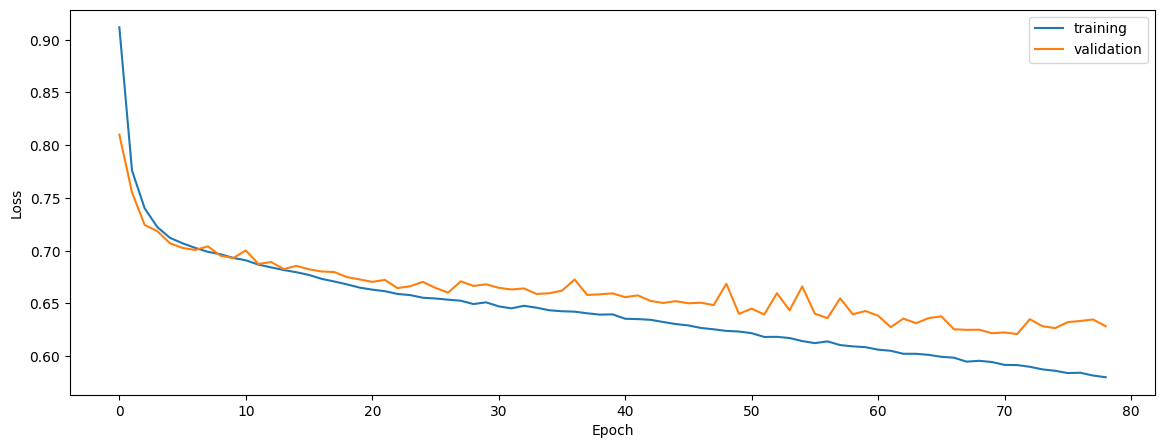

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7467137357558195


0.724956564582631


0.7320261145842177


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.7600430697235522


0.7522734770875806


0.7636220545345123


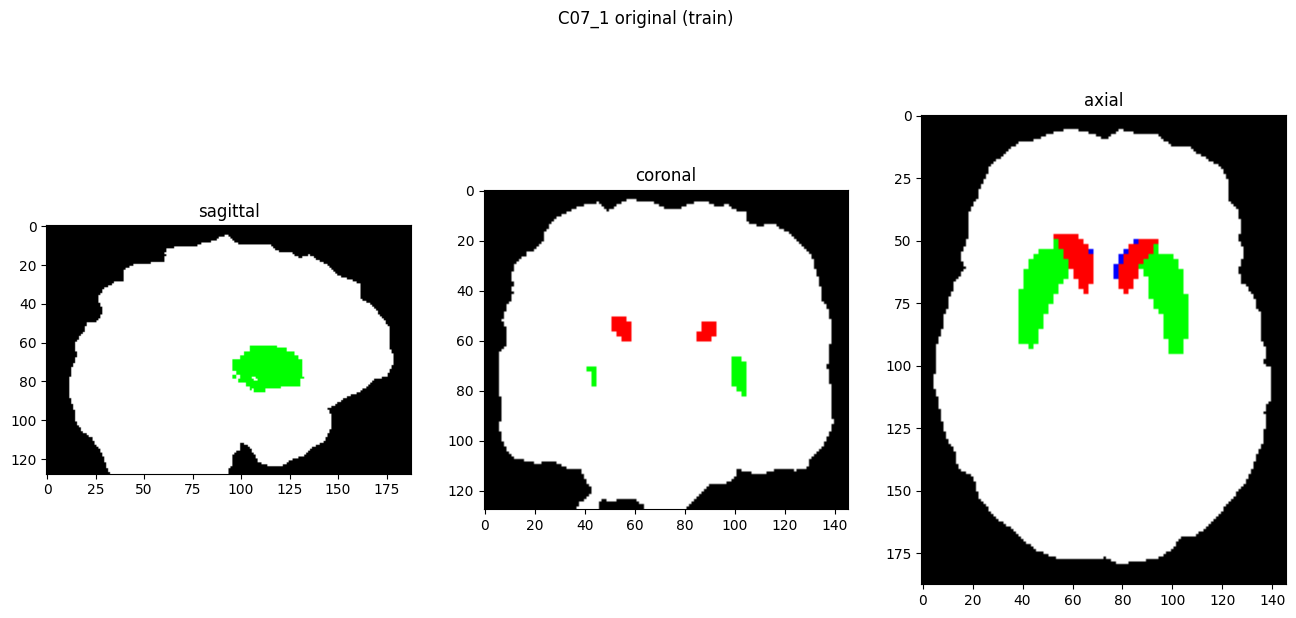

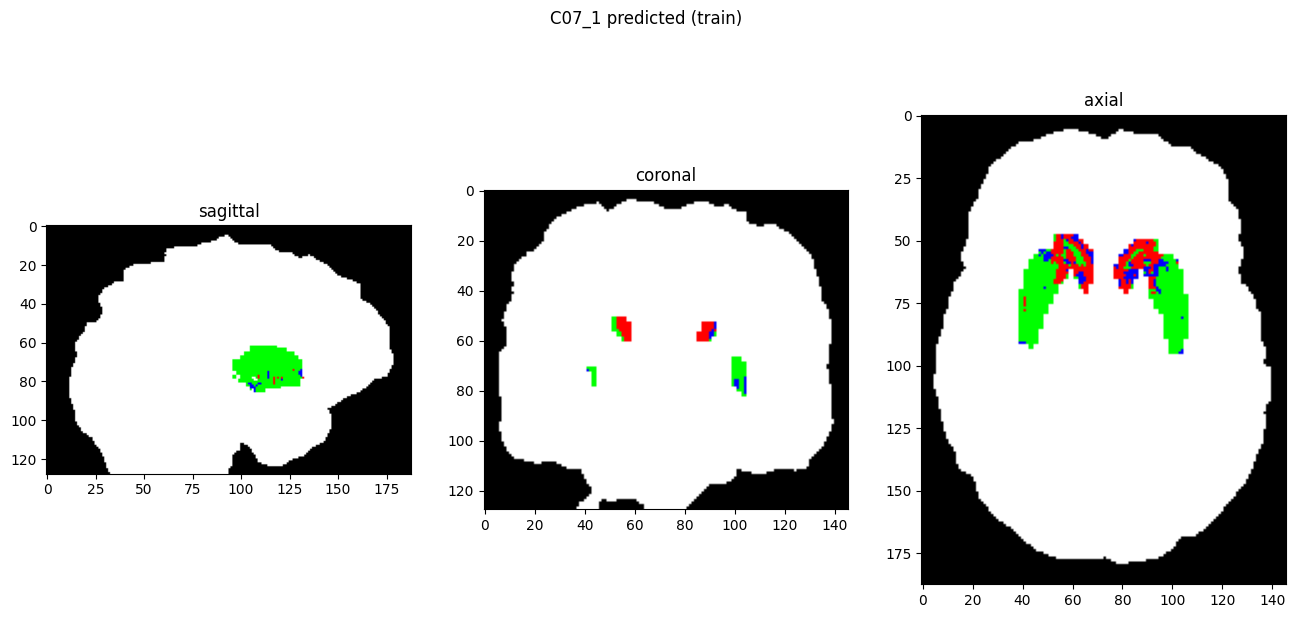

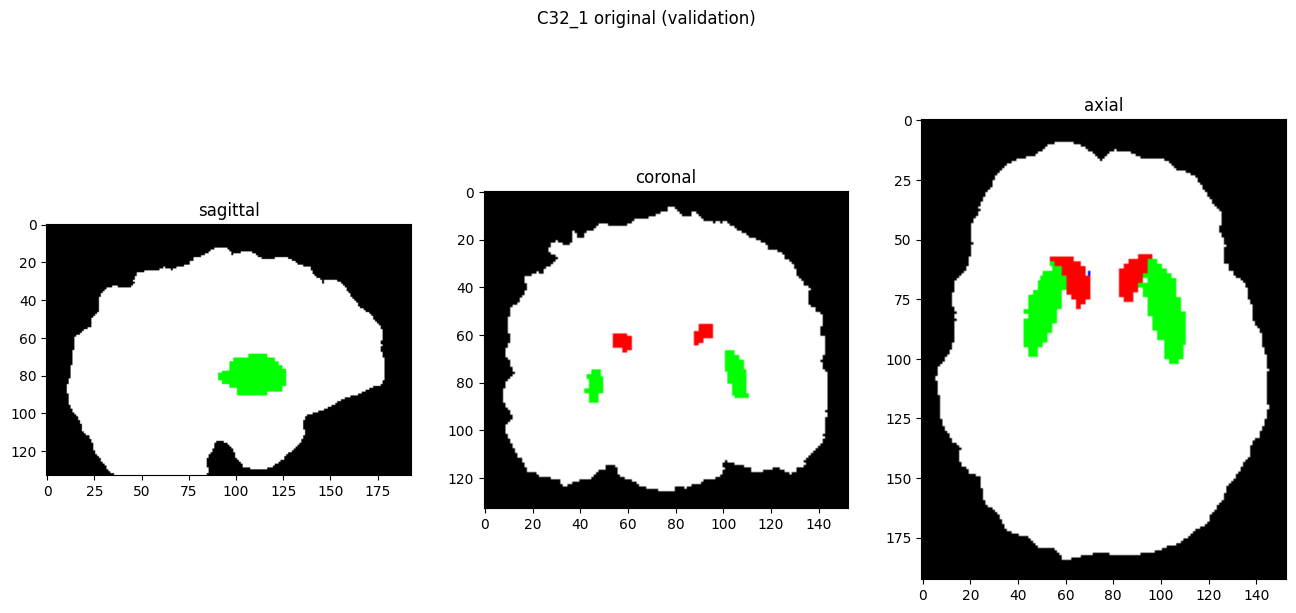

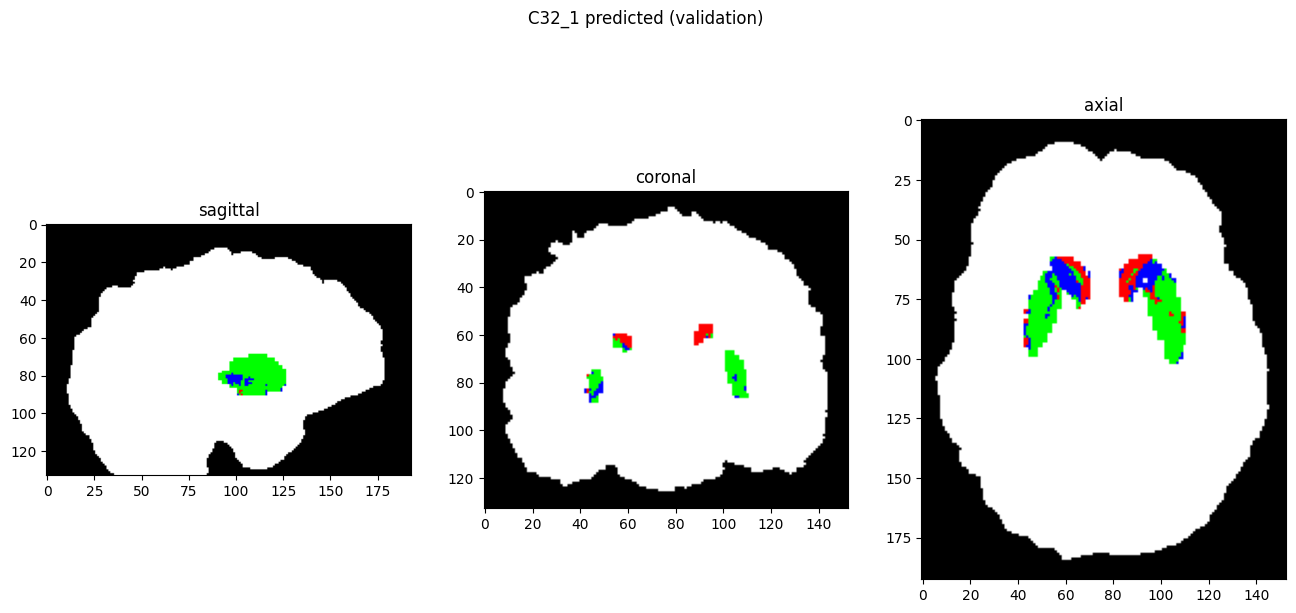

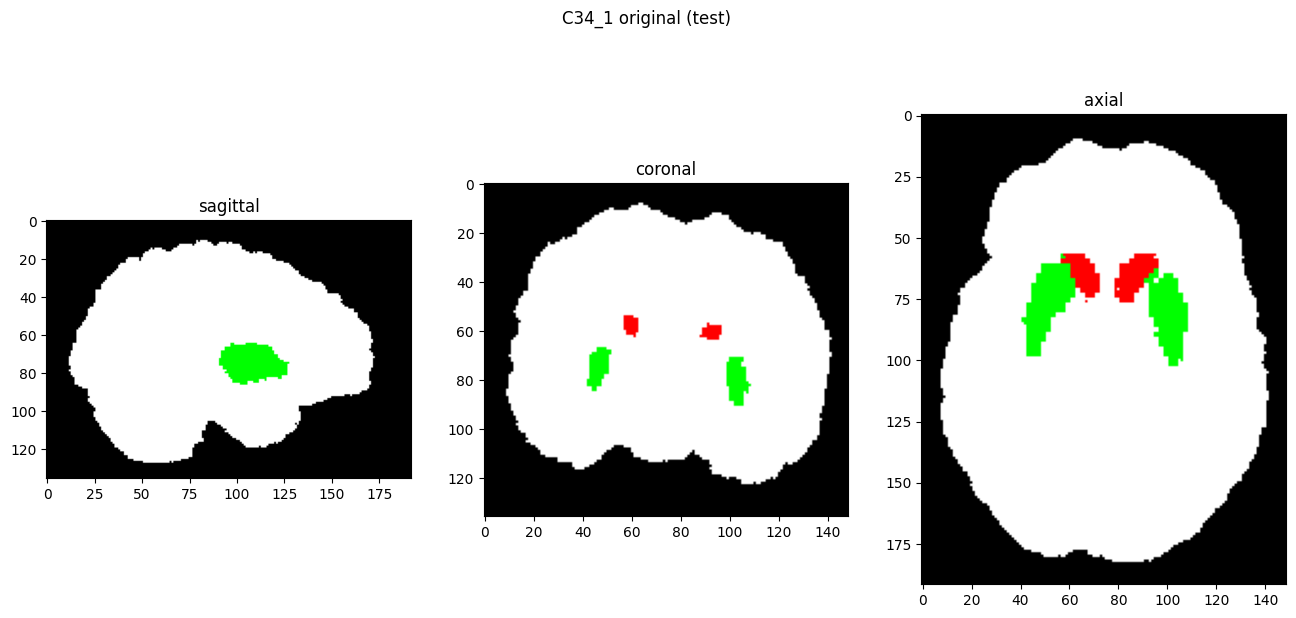

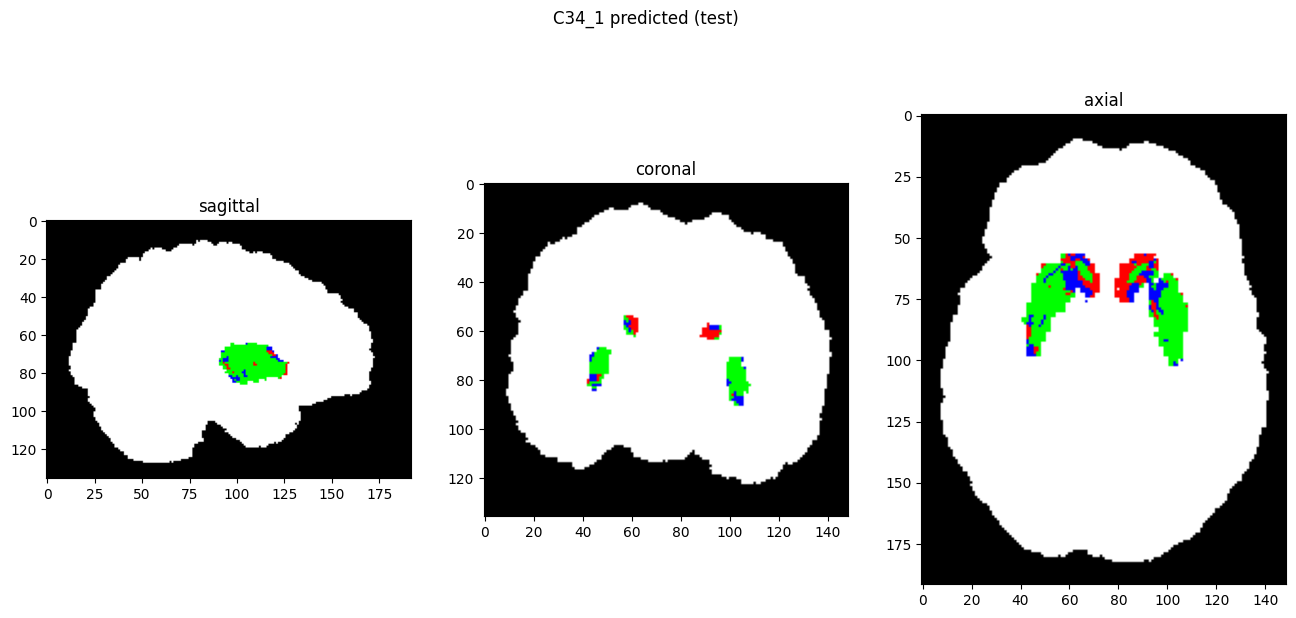

In [9]:
showResults(model, gen, threshold=0)